In [1]:
import gym
from collections import deque
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

seed = 0

# Helper Function for Visualization

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# PPO Agent with softmax policy and value network

In [3]:
class PPOAgent_softmax(object):
    def __init__(self, obs_dim, n_act,
                 epochs=10, policy_lr=1e-3, value_lr=1e-4, hdim=64,
                 clip_value=0.2,
                 seed=0):
        
        self.seed=0
        
        self.obs_dim = obs_dim
        self.n_act = n_act
        
        self.epochs = epochs
        self.policy_lr = policy_lr
        self.value_lr = value_lr
        self.hdim = hdim
        
        self.clip_value = clip_value
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._value_nn()
            self._logprob()
            self._loss_train_op()
            self._kl_entropy()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.int32, (None, ), 'act')
        self.adv_ph = tf.placeholder(tf.float32, (None,), 'adv')
        self.ret_ph = tf.placeholder(tf.float32, (None,), 'ret')

        # learning rate:
        self.policy_lr_ph = tf.placeholder(tf.float32, (), 'policy_lr')
        self.value_lr_ph = tf.placeholder(tf.float32, (), 'value_lr')
        
        self.old_logits_ph = tf.placeholder(tf.float32, (None, self.n_act), 'old_logits')
        
    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        with tf.variable_scope("policy"):
            # TWO HIDDEN LAYERS
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
            self.logits = tf.layers.dense(out, self.n_act, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="logits")

            # SOFTMAX POLICY
            self.pi = tf.nn.softmax(self.logits)

            # SAMPLE OPERATION
            categorical = tf.contrib.distributions.Categorical(logits=self.logits)
            self.sample_action = categorical.sample(1,seed=self.seed)
        
    def _value_nn(self):
        hid1_size = self.hdim 
        hid2_size = self.hdim
        with tf.variable_scope("value"):
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h2")
            value = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name='output')
            self.value = tf.squeeze(value)
            
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER        
        one_hot_act = tf.one_hot(self.act_ph,self.n_act)
        
        # 
        self.log_p = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_act,logits=self.logits)
        
        #
        self.log_p_old = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_act,logits=self.old_logits_ph)
            
    def _loss_train_op(self):
        
        # REINFORCE OBJECTIVE
        ratio = tf.exp(self.log_p - self.log_p_old)
        cliped_ratio = tf.clip_by_value(ratio,clip_value_min=1-self.clip_value,clip_value_max=1+self.clip_value)
        self.policy_loss = -tf.reduce_mean(tf.minimum(self.adv_ph*ratio,self.adv_ph*cliped_ratio))
        
        # POLICY OPTIMIZER
        self.pol_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="policy")
        optimizer = tf.train.AdamOptimizer(self.policy_lr_ph)
        self.train_policy = optimizer.minimize(self.policy_loss,var_list=self.pol_var_list)
            
        # L2 LOSS
        self.value_loss = tf.reduce_mean(tf.square(self.value - self.ret_ph))
            
        # VALUE OPTIMIZER 
        self.val_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="value")
        optimizer = tf.train.AdamOptimizer(self.value_lr_ph)
        self.train_value = optimizer.minimize(self.value_loss,var_list=self.val_var_list)
    
    def _kl_entropy(self):
        
        pi = self.pi
        pi_old = tf.nn.softmax(self.old_logits_ph)
                
        # KL DIVERGENCE BETWEEN TWO GAUSSIAN
        kl = tf.reduce_sum(pi_old*(tf.log(pi_old)-tf.log(pi)),axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF GAUSSIAN
        entropy = -tf.reduce_sum(pi*tf.log(pi),axis=1) # sum -p*log(p)
        self.entropy = tf.reduce_mean(entropy) # average over Batch
        
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
    
    def get_value(self, obs):
        feed_dict = {self.obs_ph: obs}
        value = self.sess.run(self.value, feed_dict=feed_dict)
        return value
    
    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action, = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action[0]
    
    def control(self, obs): # COMPUTE MEAN
        feed_dict = {self.obs_ph: obs}
        best_action = np.argmax(self.sess.run(self.pi,feed_dict=feed_dict))
        return best_action        
    
    def update(self, observes, actions, advantages, returns, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        old_logits = self.sess.run(self.logits,{self.obs_ph: observes}) # COMPUTE OLD PARAMTER
        for e in range(self.epochs):
            observes, actions, advantages, returns, old_logits = shuffle(observes, actions, advantages, returns, old_logits, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end],
                     self.adv_ph: advantages[start:end],
                     self.ret_ph: returns[start:end],
                     self.old_logits_ph: old_logits[start:end,:],
                     self.policy_lr_ph: self.policy_lr,
                     self.value_lr_ph: self.value_lr}        
                self.sess.run([self.train_policy,self.train_value], feed_dict)
            
        feed_dict = {self.obs_ph: observes,
             self.act_ph: actions,
             self.adv_ph: advantages,
             self.ret_ph: returns,
             self.old_logits_ph: old_logits,
             self.policy_lr_ph: self.policy_lr,
             self.value_lr_ph: self.value_lr}               
        policy_loss, value_loss, kl, entropy  = self.sess.run([self.policy_loss, self.value_loss, self.kl, self.entropy], feed_dict)
        return policy_loss, value_loss, kl, entropy
    
    def close_sess(self):
        self.sess.close()

# Helper Function for Training 

### Generalized Advantage Estimation

### 1. Sample batch of trajectories
### $\mathcal{D} = \{\tau_i\}_{i=1}^{B}$ and $\tau_{i} = \{s_0^{i},a_0^{i},r_1^{i},s_1^{i},a_1^{i},r_2^{i},\cdots,s_T^{i},a_T^{i},r_{T+1}^{i}\}$

### 2. Compute value using $v_{\phi}$
### $\{\{V_{t}^{i}\}_{t=0}^{T}\}_{i=1}^{B}$ and $V_{t}^{i} = v_{\phi}(s_{t}^{i})$

### 3. Compute TD error
### $\delta_{t} = r_{t+1} + \gamma V_{t+1} - V_{t}$

### 4. Compute GAE
### $A^{(\lambda)}_{t} = \delta_{t} + \lambda \gamma \delta_{t+1}$

In [4]:
def run_episode(env, policy, animate=False): # Run policy and collect (state, action, reward) pairs
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        
        action = agent.get_action(obs)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.array(actions), np.array(rewards, dtype=np.float32), infos)

def run_policy(env, agent, episodes): # collect trajectories
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, agent)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories
        
def add_value(trajectories, val_func): # Add value estimation for each trajectories
    for trajectory in trajectories:
        observes = trajectory['observes']
        values = val_func.get_value(observes)
        trajectory['values'] = values

def add_gae(trajectories, gamma=0.99, lam=0.98): # generalized advantage estimation (for training stability)
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        values = trajectory['values']
        
        # temporal differences
        tds = rewards + np.append(values[1:],0) * gamma - values
        advantages = np.zeros_like(tds)
        advantage = 0
        for t in reversed(range(len(tds))):
            advantage = tds[t] + lam*gamma*advantage
            advantages[t] = advantage
        trajectory['advantages'] = advantages

def add_rets(trajectories, gamma=0.99): # compute the returns
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        
        returns = np.zeros_like(rewards)
        ret = 0
        for t in reversed(range(len(rewards))):
            ret = rewards[t] + gamma*ret
            returns[t] = ret            
        trajectory['returns'] = returns

def build_train_set(trajectories):
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    returns = np.concatenate([t['returns'] for t in trajectories])
    advantages = np.concatenate([t['advantages'] for t in trajectories])

    # Normalization of advantages 
    # In baselines, which is a github repo including implementation of PPO coded by OpenAI, 
    # all policy gradient methods use advantage normalization trick as belows.
    # The insight under this trick is that it tries to move policy parameter towards locally maximum point.
    # Sometimes, this trick doesnot work.
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-6)

    return observes, actions, advantages, returns

# Training PPO Agent

In [5]:
env = gym.make('CartPole-v1')

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
n_act = env.action_space.n

agent = PPOAgent_softmax(obs_dim, n_act, epochs=5, hdim=32, clip_value=0.5, policy_lr=3e-4, value_lr=7e-4, seed=seed)

#
avg_return_list = deque(maxlen=10)
avg_pol_loss_list = deque(maxlen=10)
avg_val_loss_list = deque(maxlen=10)

episode_size = 1
batch_size = 32
nupdates = 1000

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episodes=episode_size)
    add_value(trajectories, agent)
    add_gae(trajectories)
    add_rets(trajectories)
    observes, actions, advantages, returns = build_train_set(trajectories)

    pol_loss, val_loss, kl, entropy = agent.update(observes, actions, advantages, returns, batch_size=batch_size)

    avg_pol_loss_list.append(pol_loss)
    avg_val_loss_list.append(val_loss)
    
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%200) == 0:
        print('[{}/{}] return : {:.3f}, value loss : {:.3f}, policy loss : {:.3f}, policy kl : {:.5f}, policy entropy : {:.3f}'.format(
            update, nupdates, np.mean(avg_return_list), np.mean(avg_val_loss_list), np.mean(avg_pol_loss_list), kl, entropy))
        
    if (np.mean(avg_return_list) > 495): # Threshold return to success cartpole
        print('[{}/{}] return : {:.3f}, value loss : {:.3f}, policy loss : {:.3f}'.format(update,nupdates, np.mean(avg_return_list), np.mean(avg_val_loss_list), np.mean(avg_pol_loss_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
Use the retry module or similar alternatives.
[0/1000] return : 14.000, value loss : 65.681, policy loss : -0.000, policy kl : 0.00000, policy entropy : 0.693
[200/1000] return : 109.100, value loss : 571.181, policy loss : -0.022, policy kl : 0.02303, policy entropy : 0.530
[400/1000] return : 142.400, value loss : 486.872, policy loss : -0.019, policy kl : 0.04367, policy entropy : 0.528
[516/1000] return : 499.400, value loss : 601.641, policy loss : -0.010
The problem is solved with 516 episodes


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 500.00



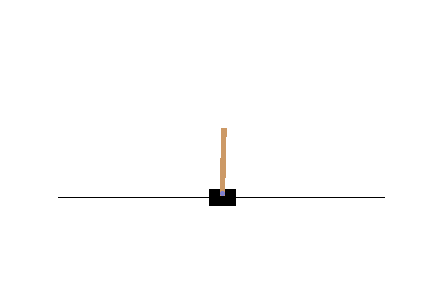
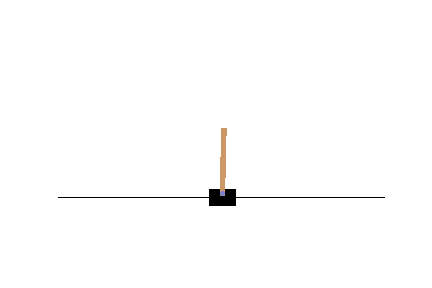
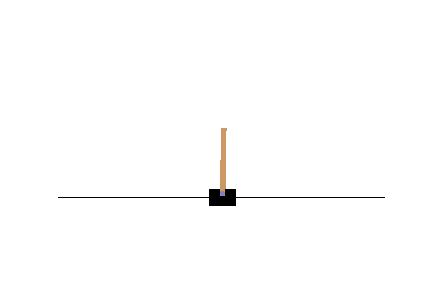
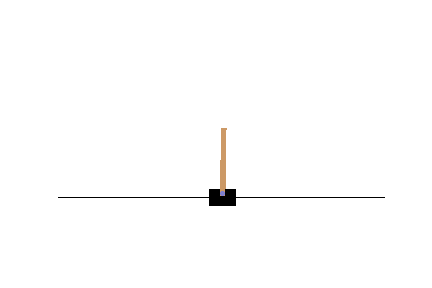
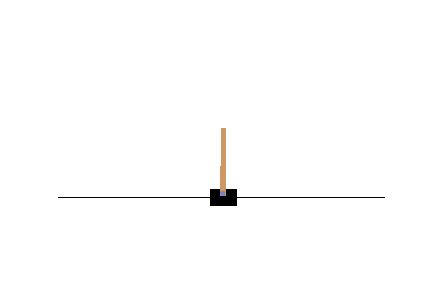
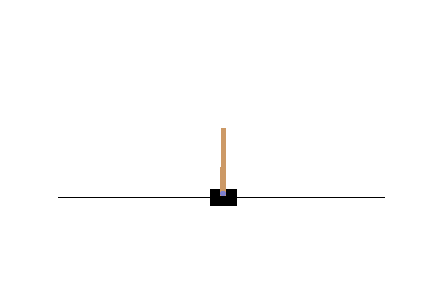
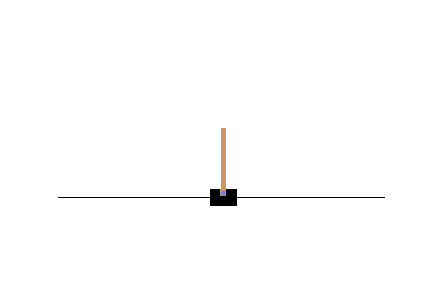
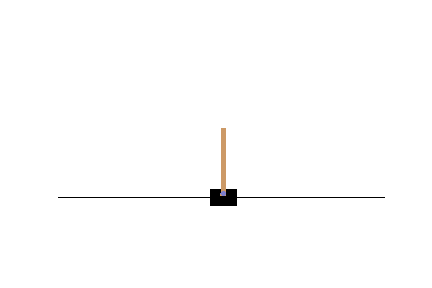
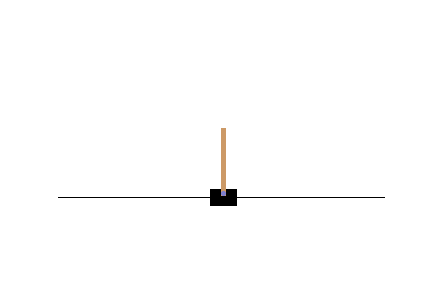
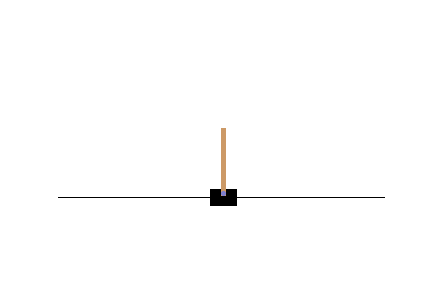
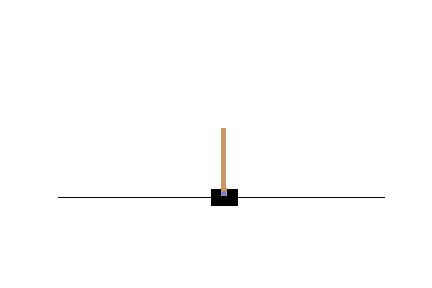
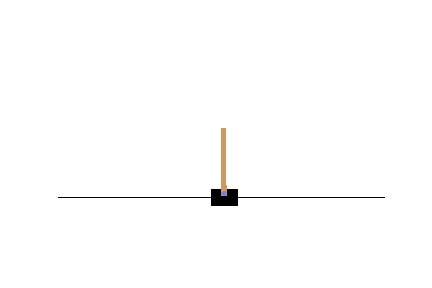
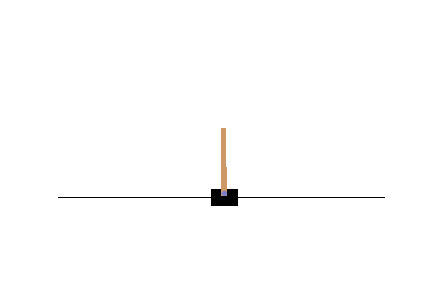
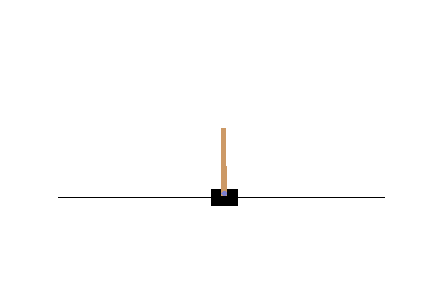
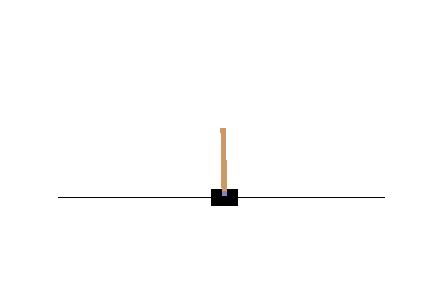
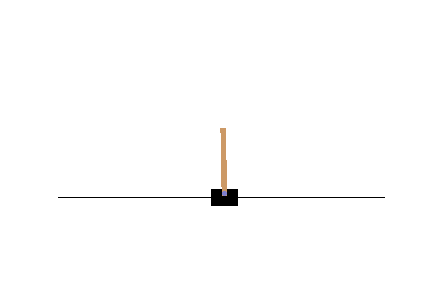
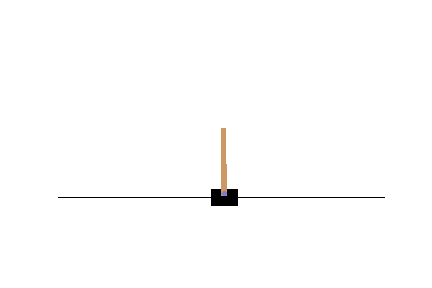
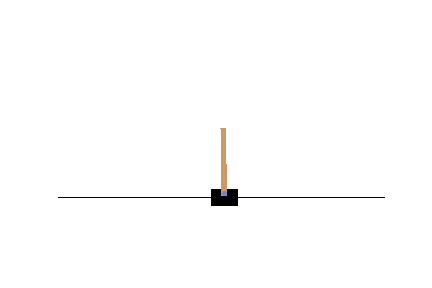
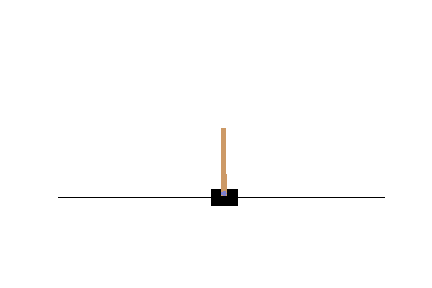
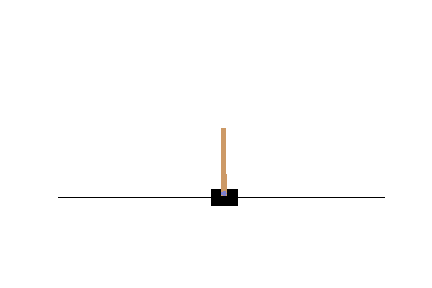
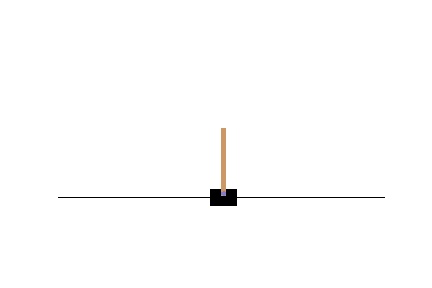
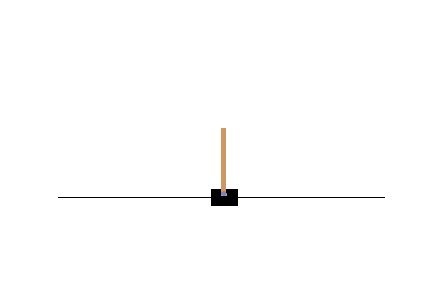
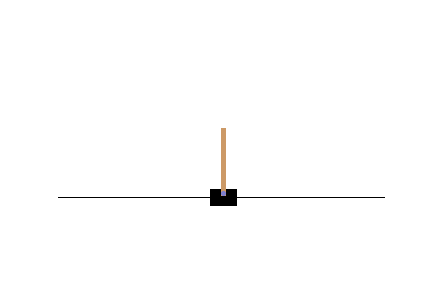
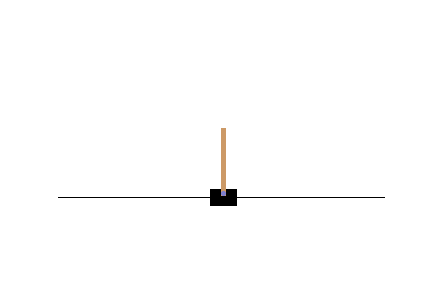
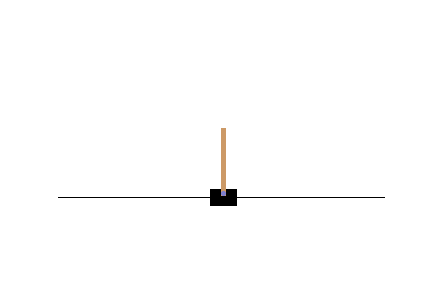
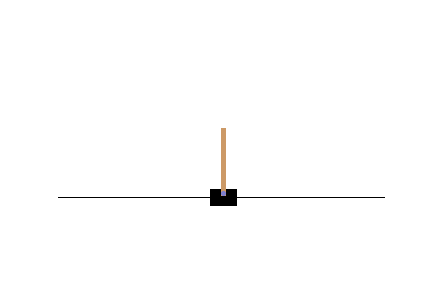
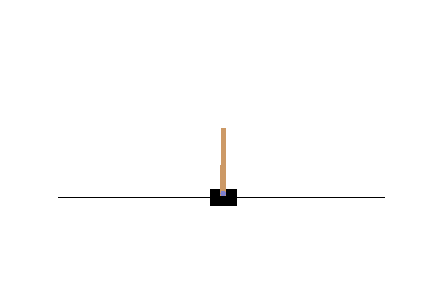
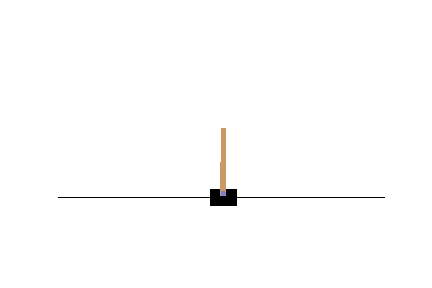
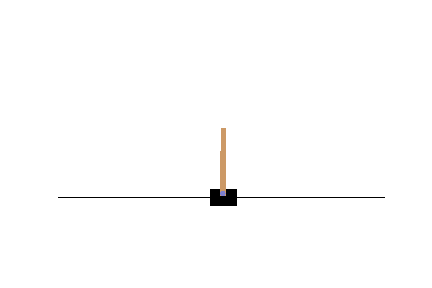
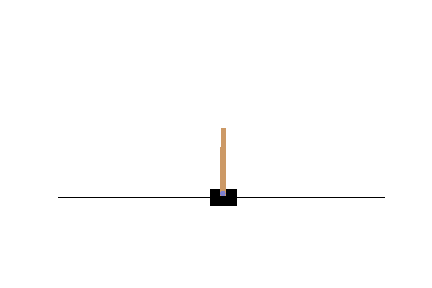
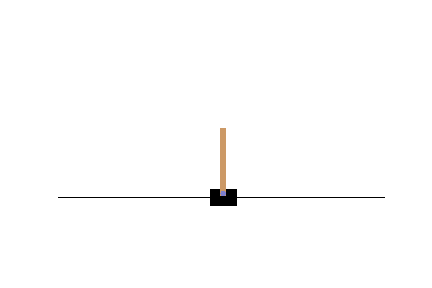
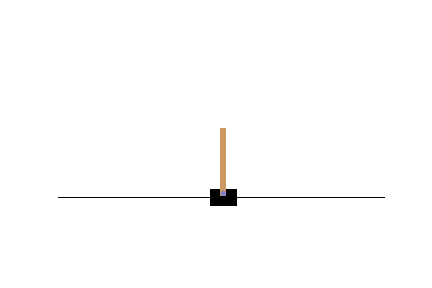
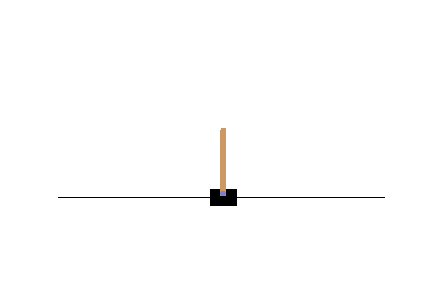
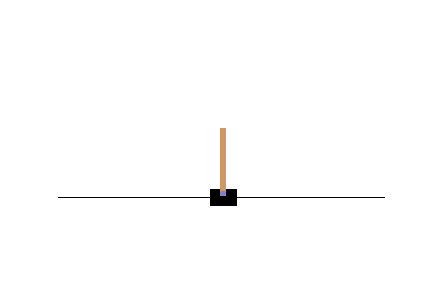
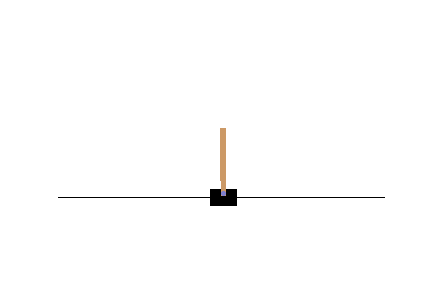
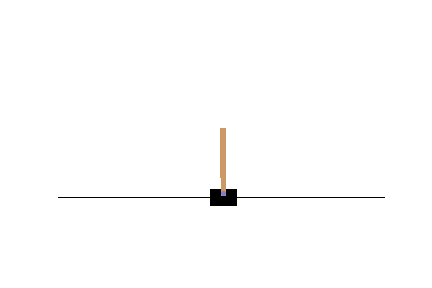
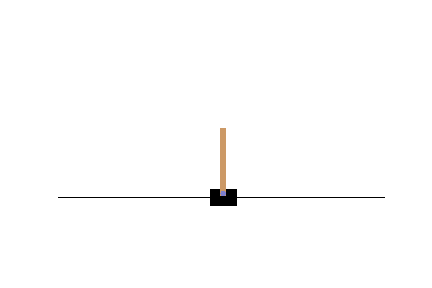
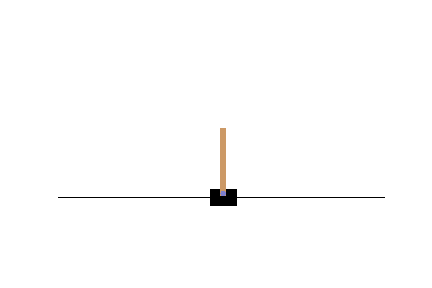
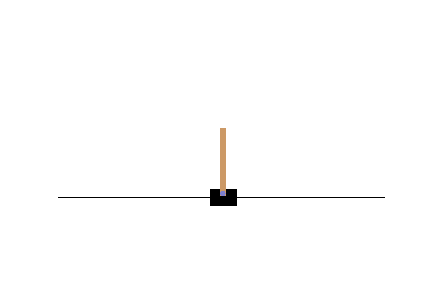
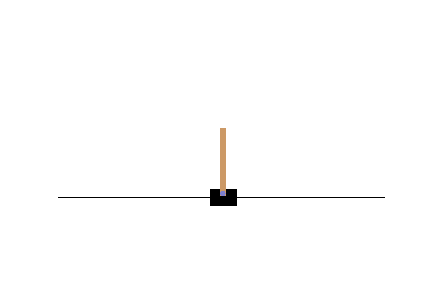
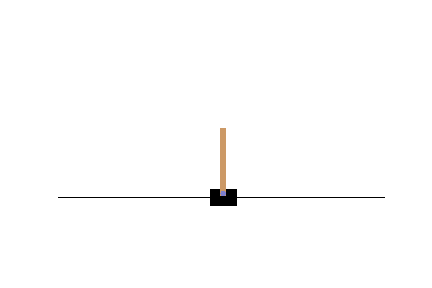
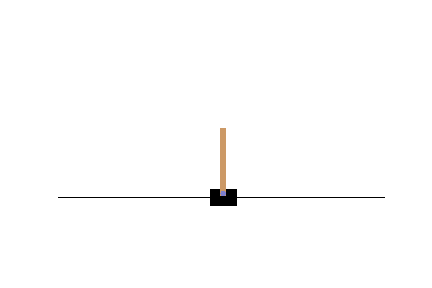
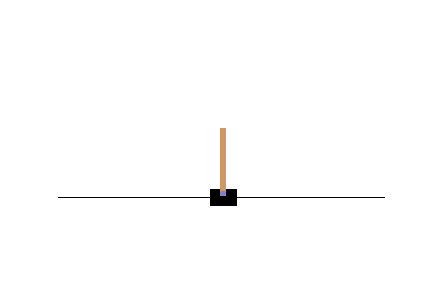
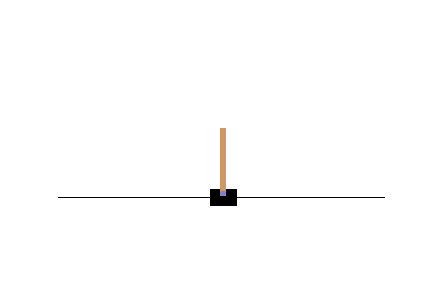
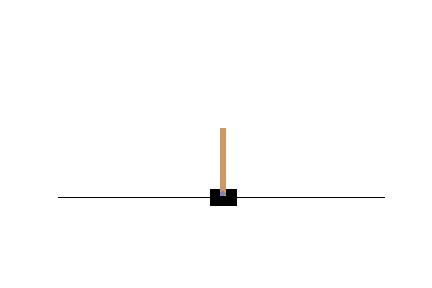
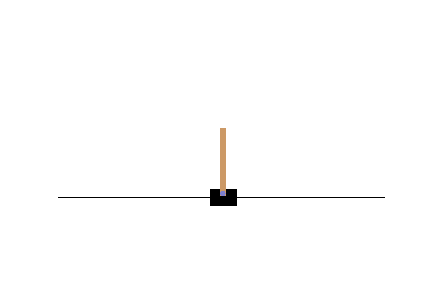
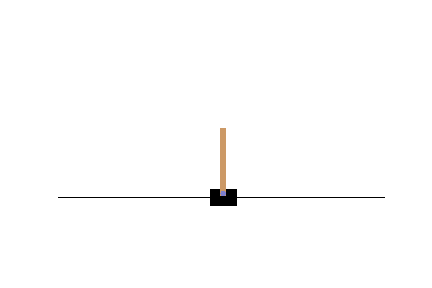
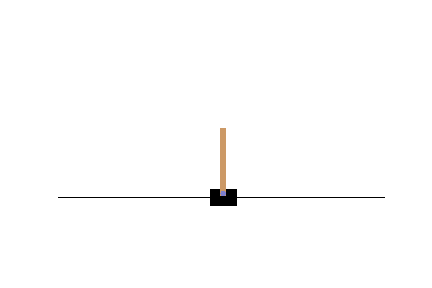
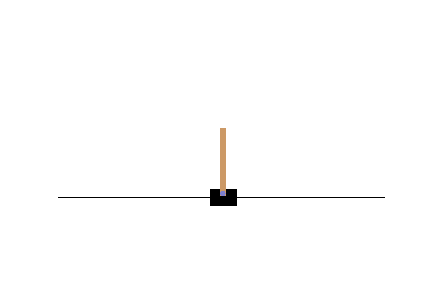
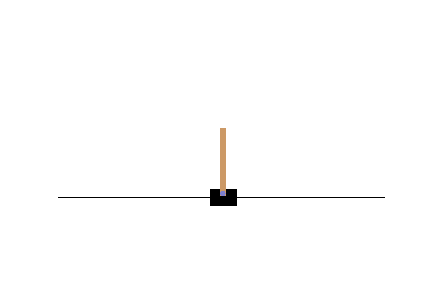
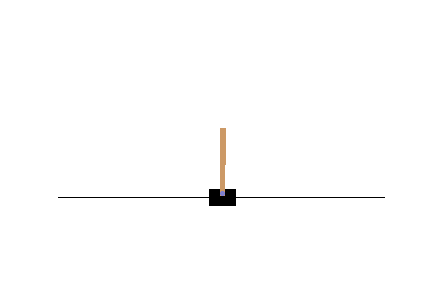
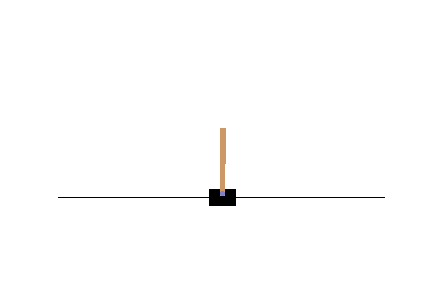
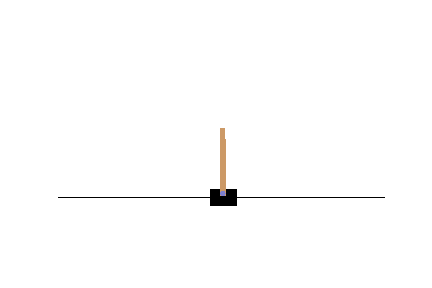
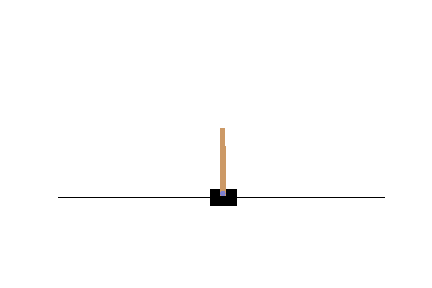
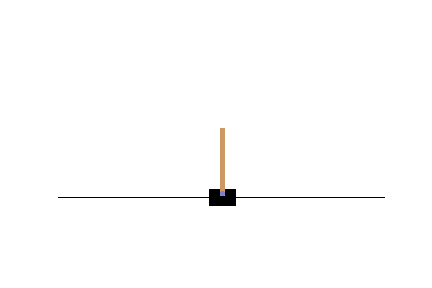
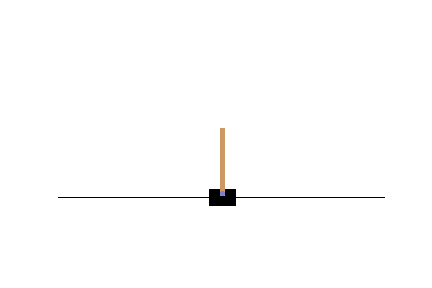
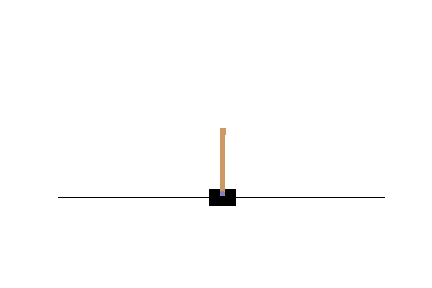
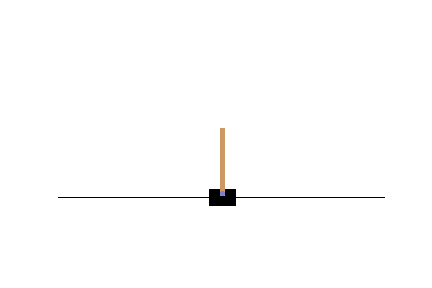
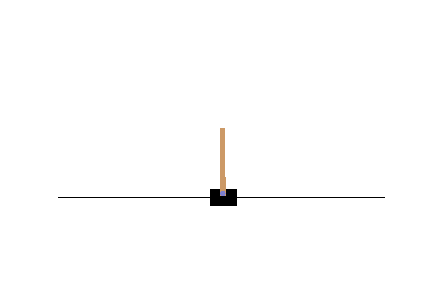
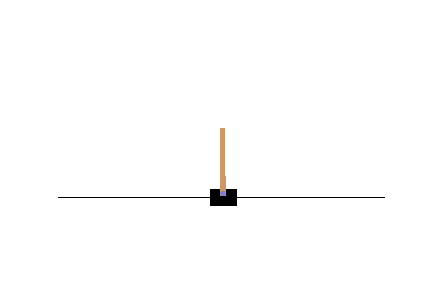
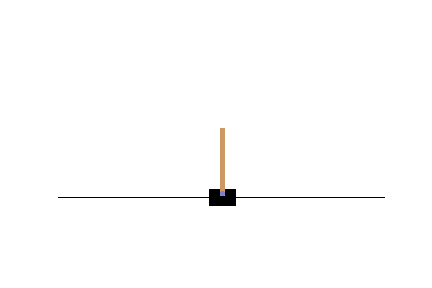
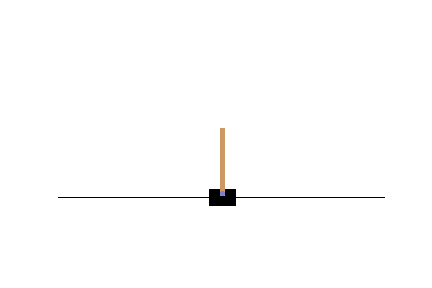
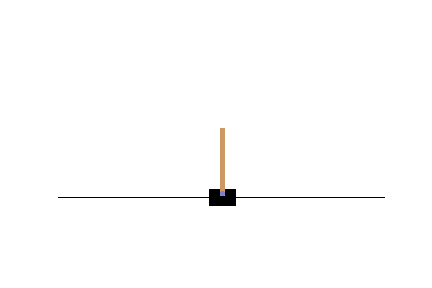
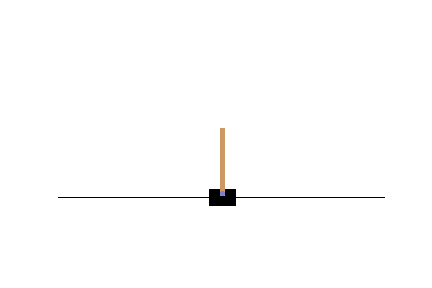
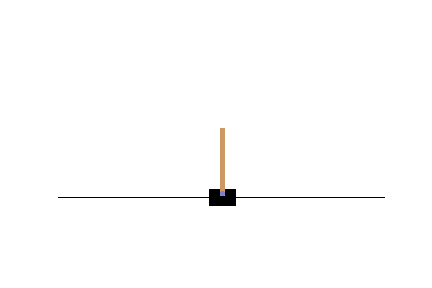
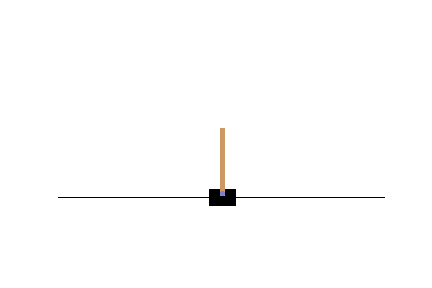
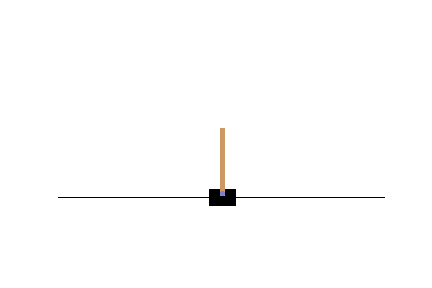
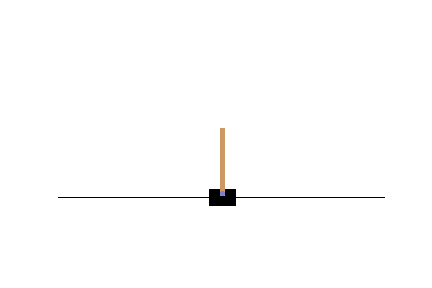
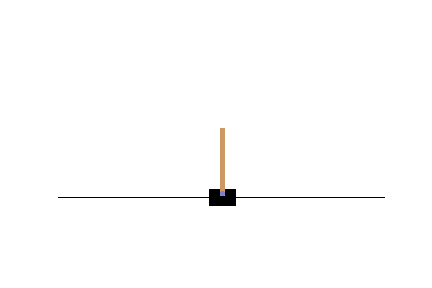
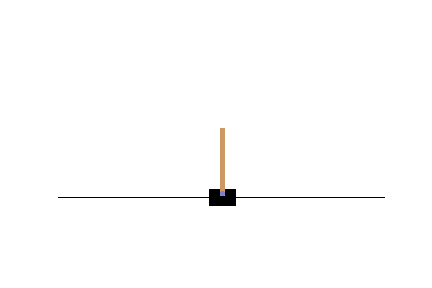
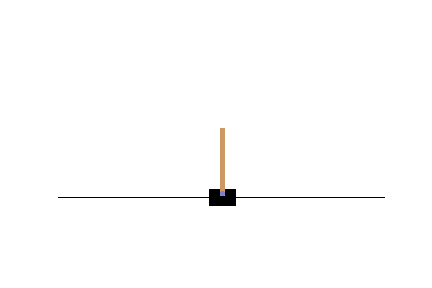
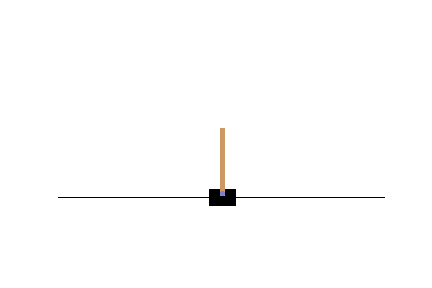
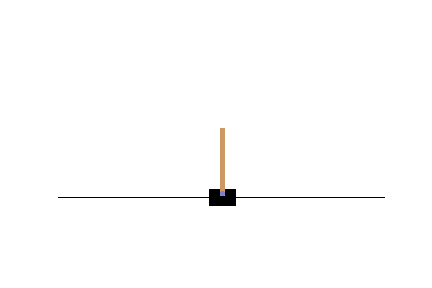
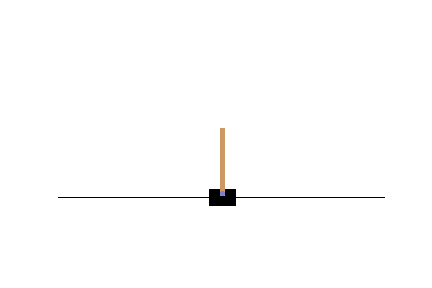
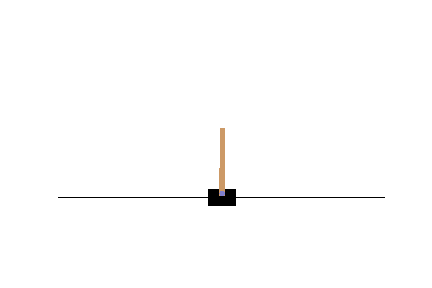
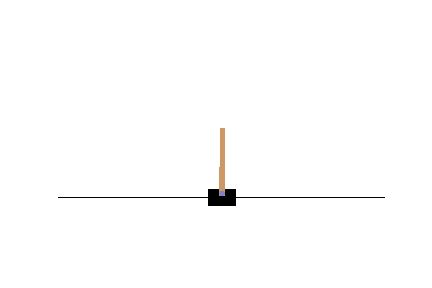
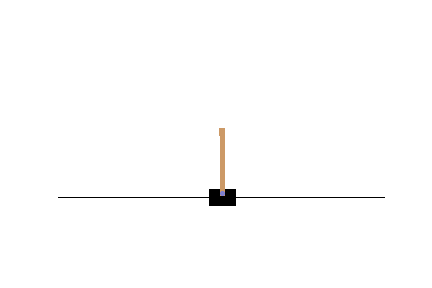
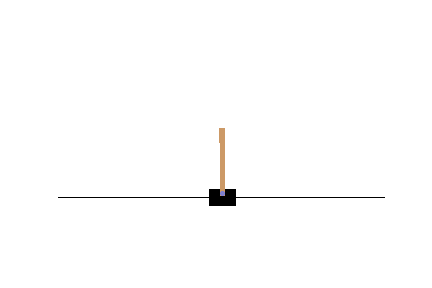
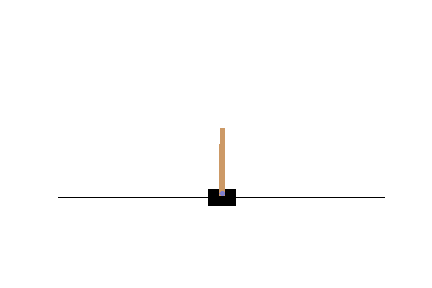
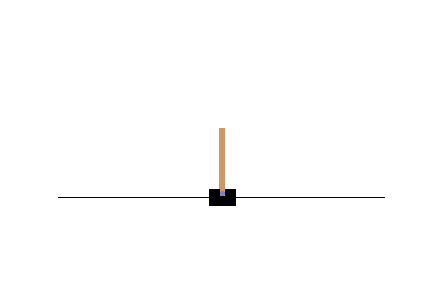
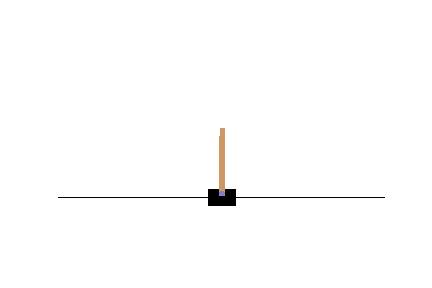
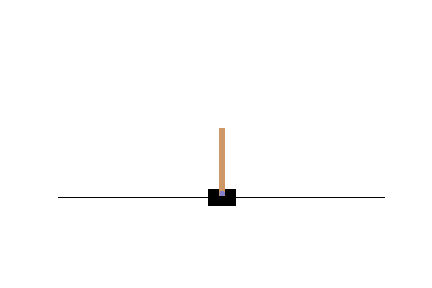
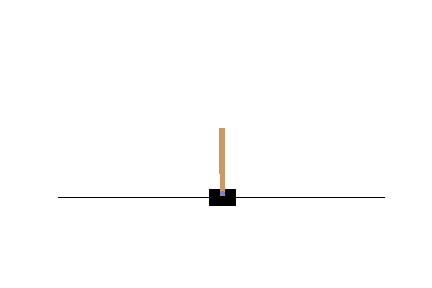
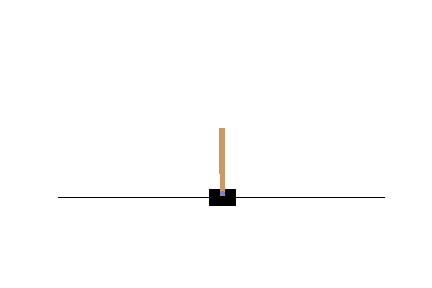
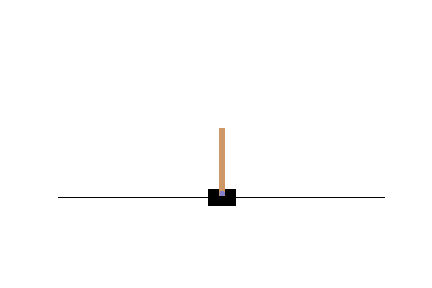
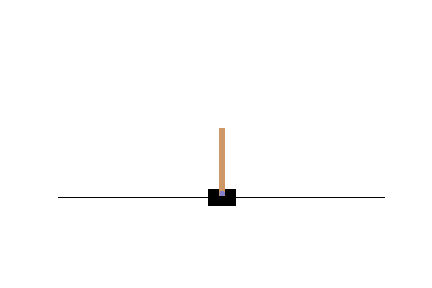
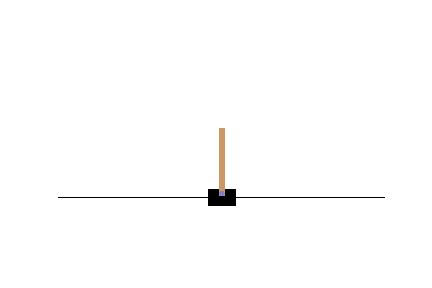
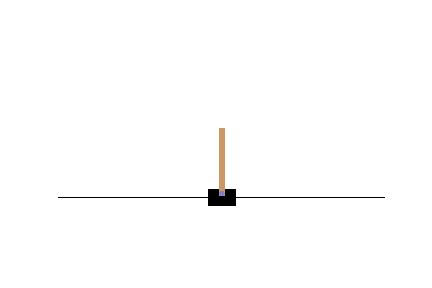
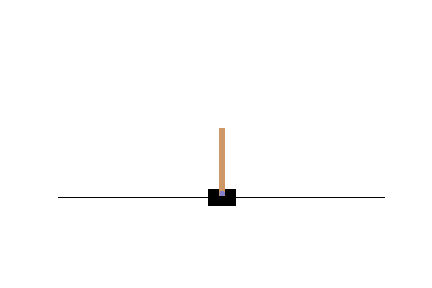
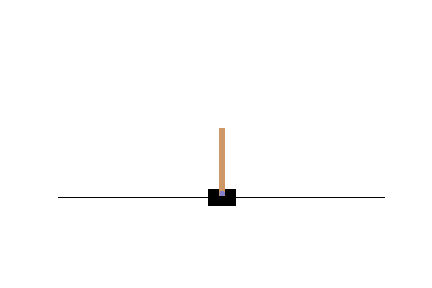
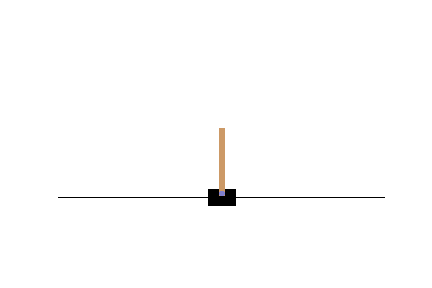
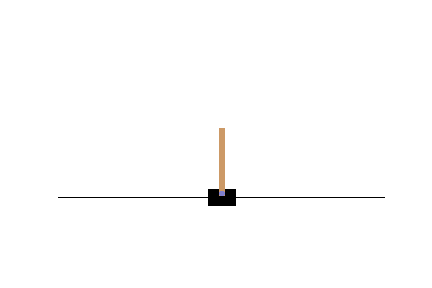
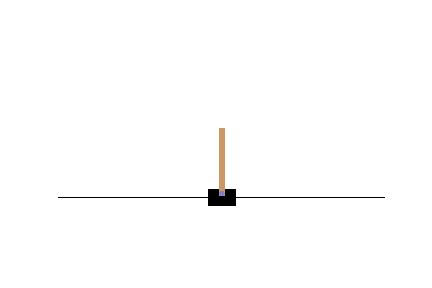
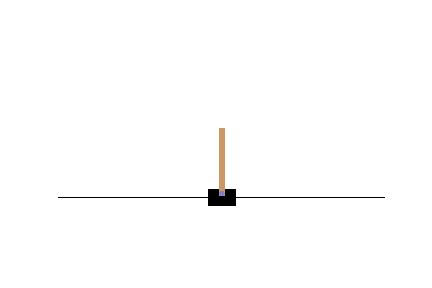
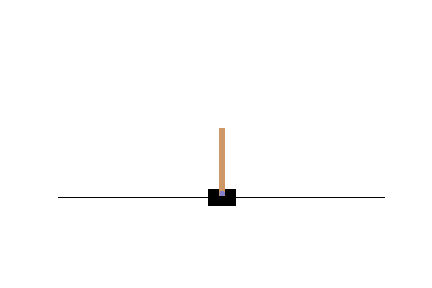
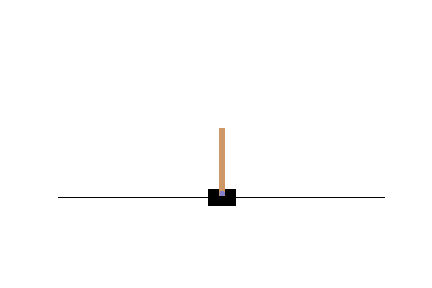
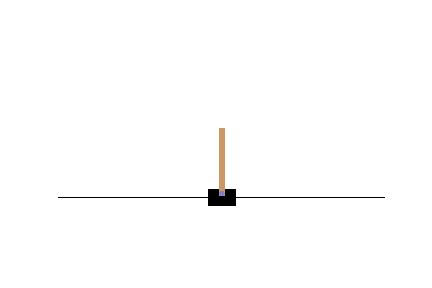
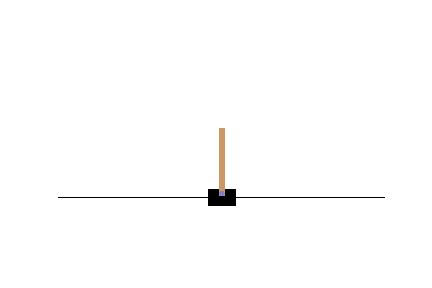
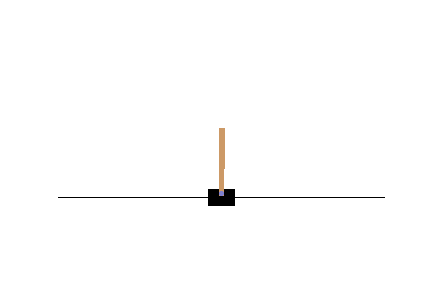
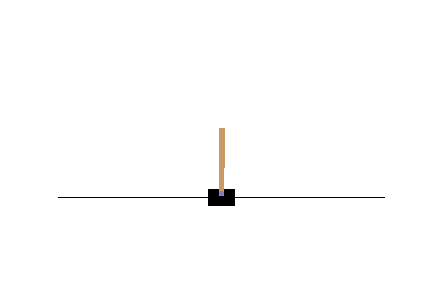
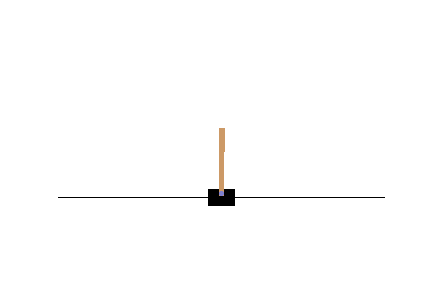
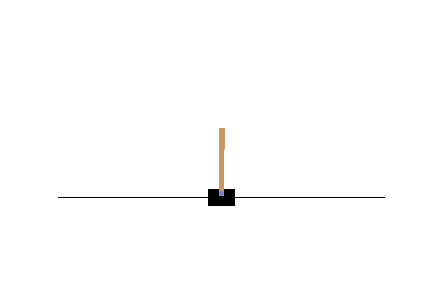
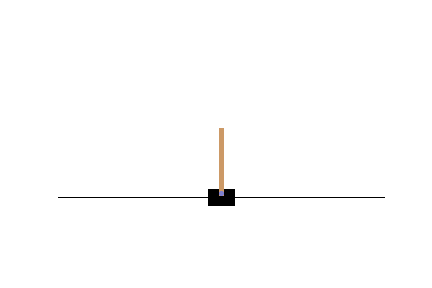
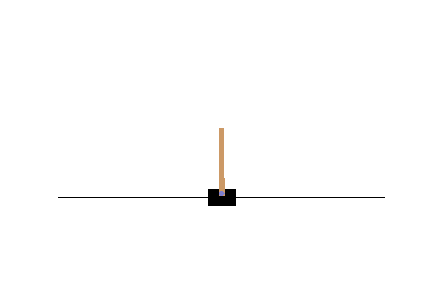
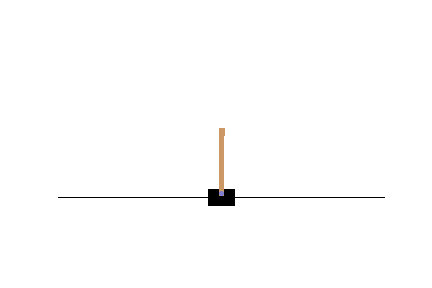
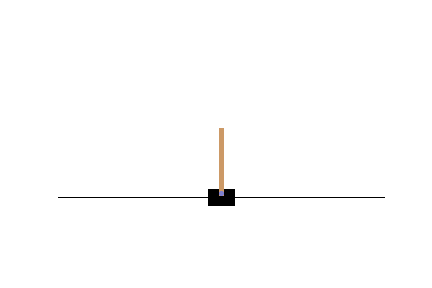
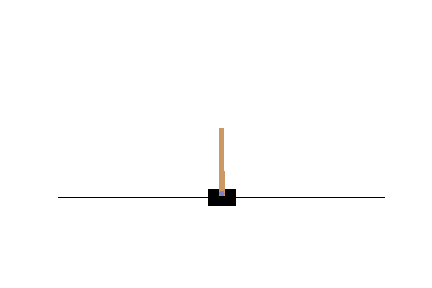
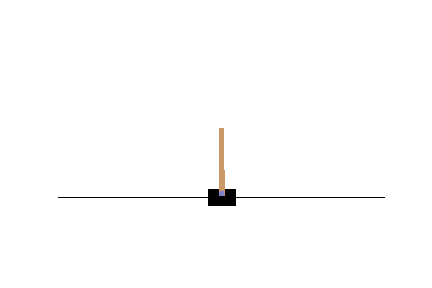
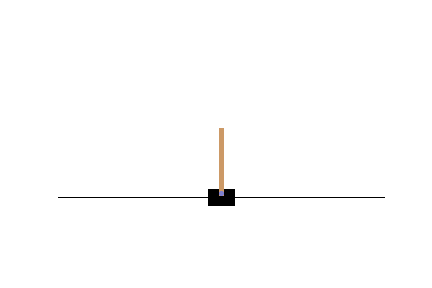
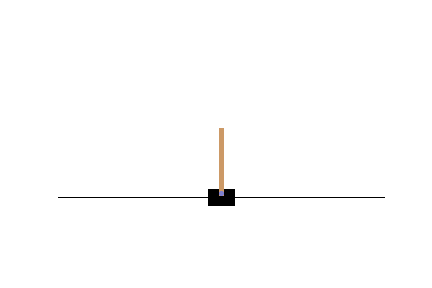
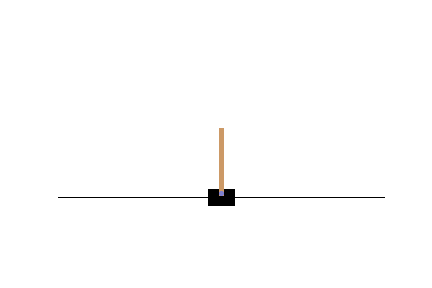
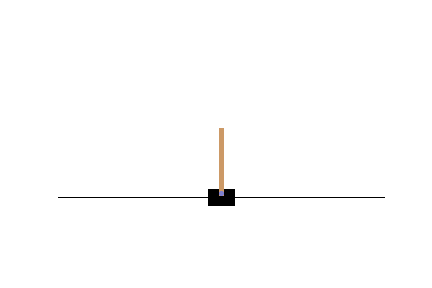
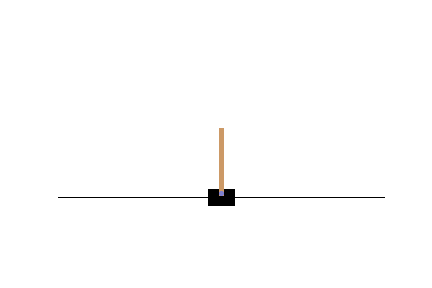
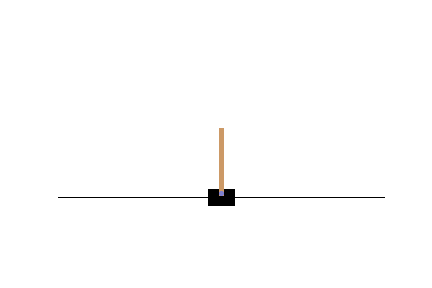
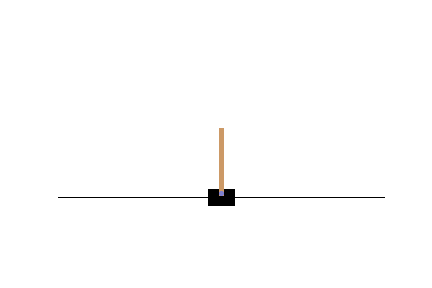
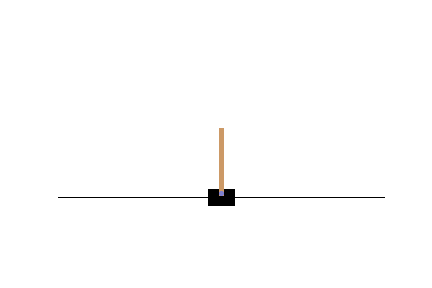
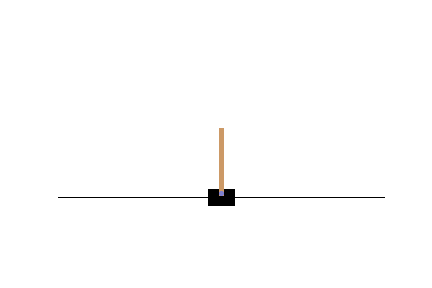
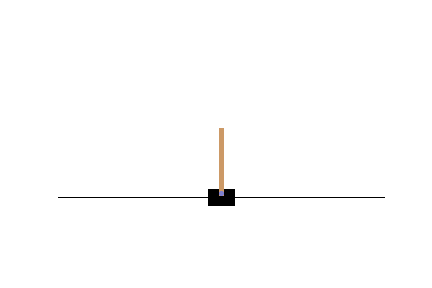
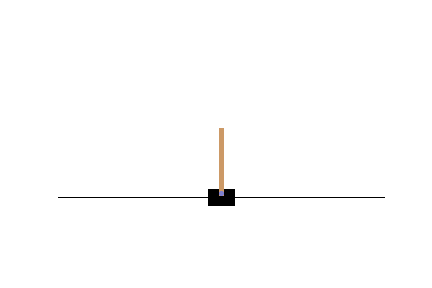
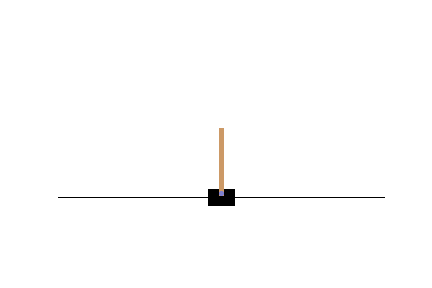
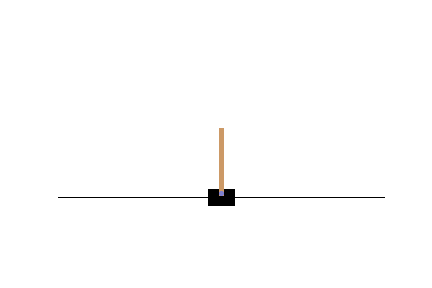
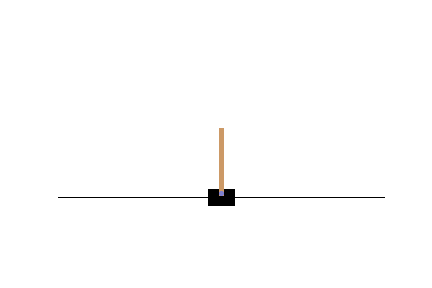
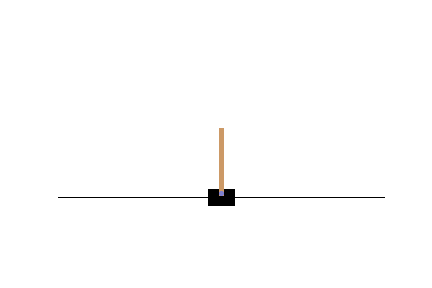
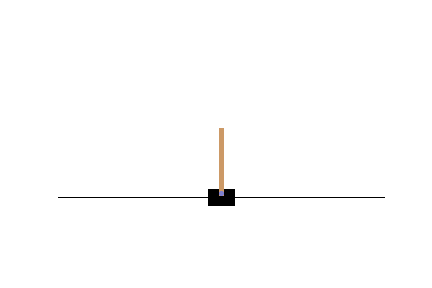
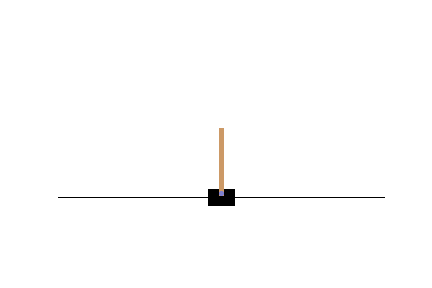
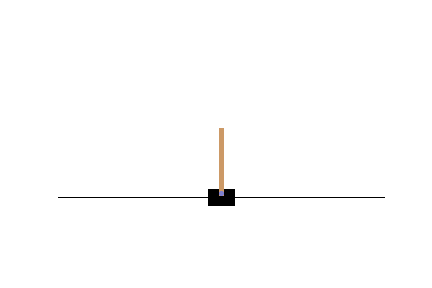
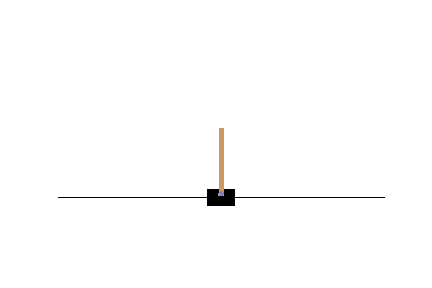
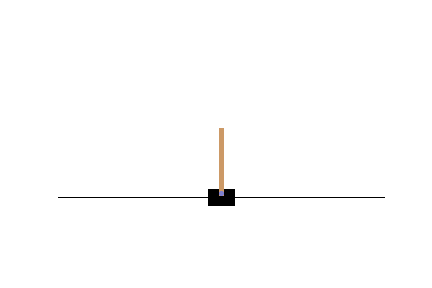
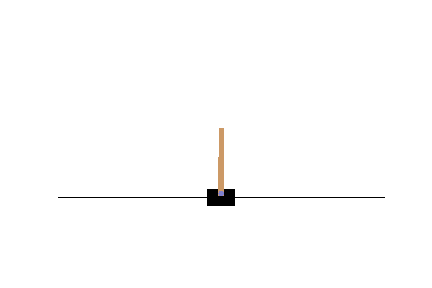
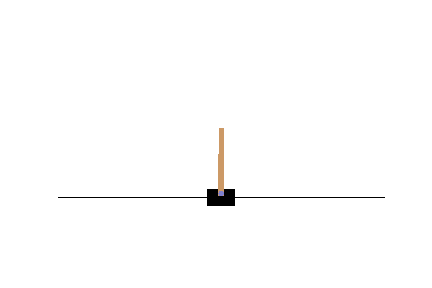
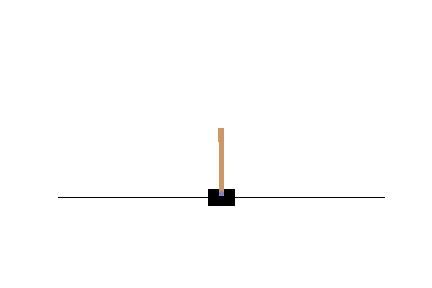
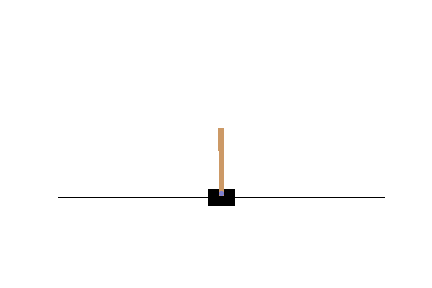
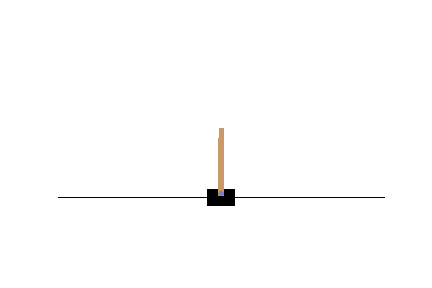
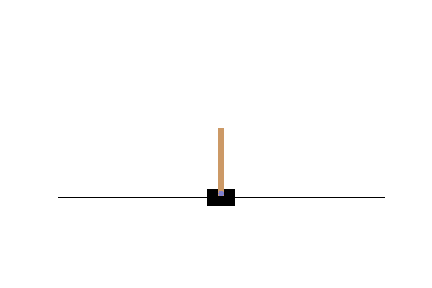
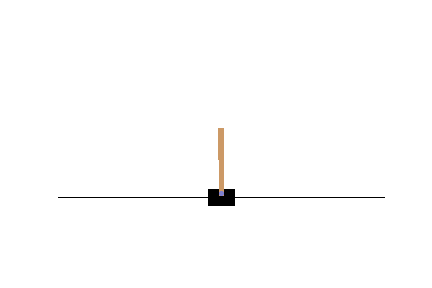
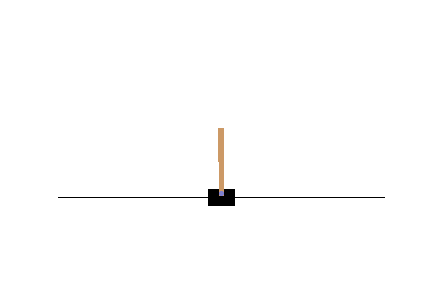
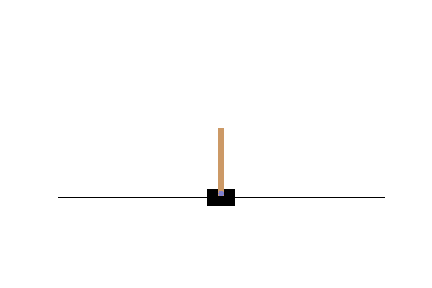
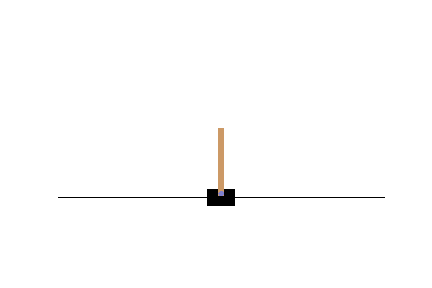
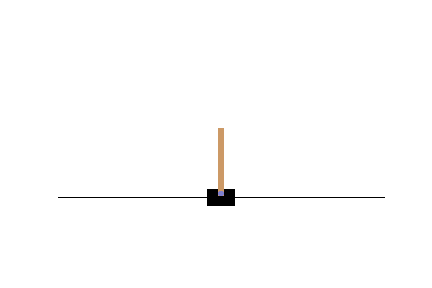
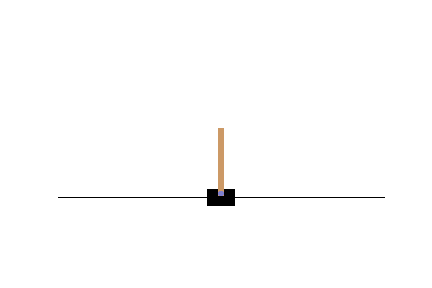
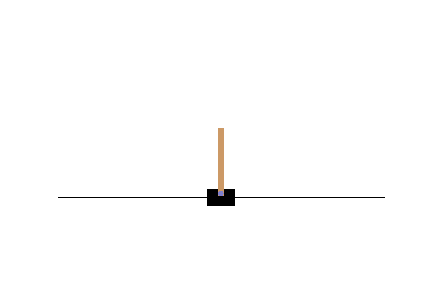
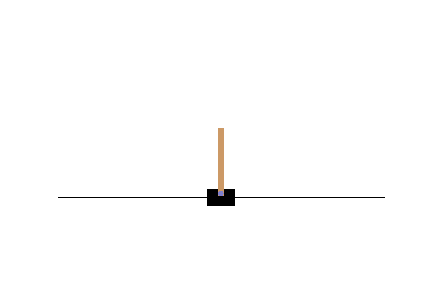
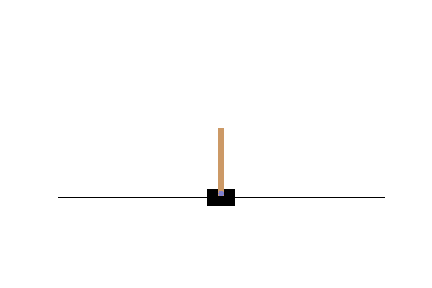
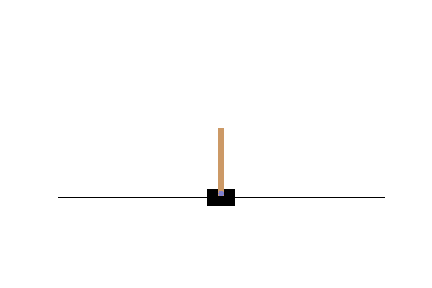
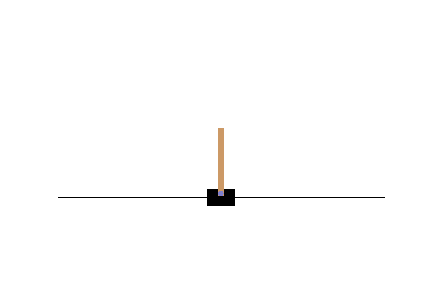
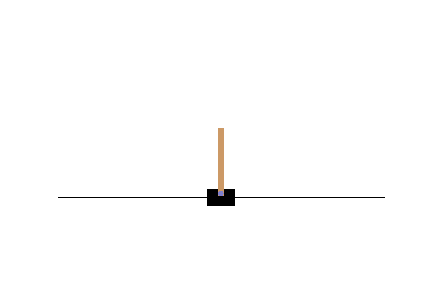
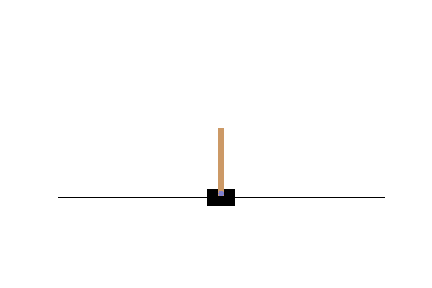
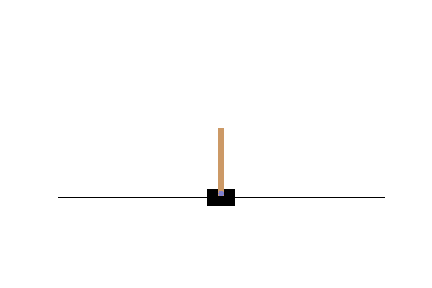
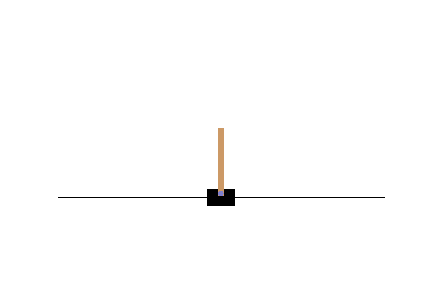
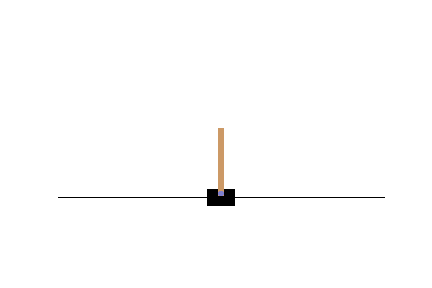
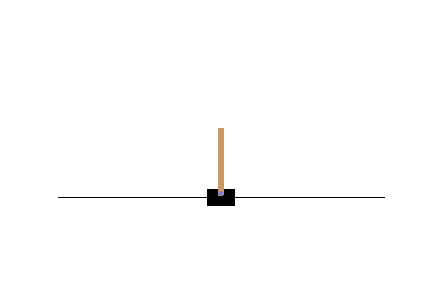
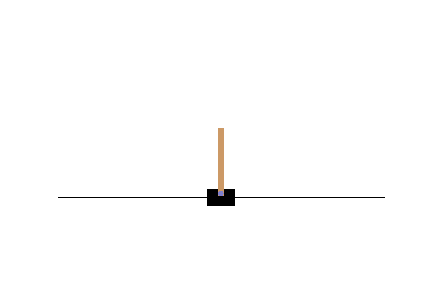
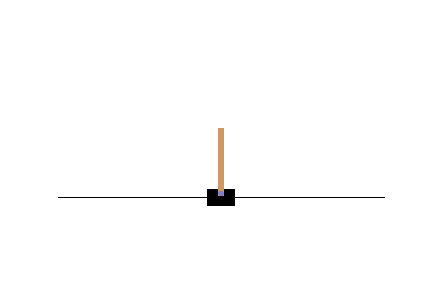
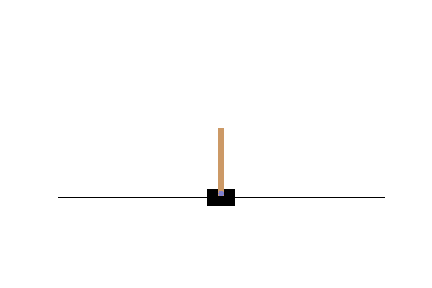
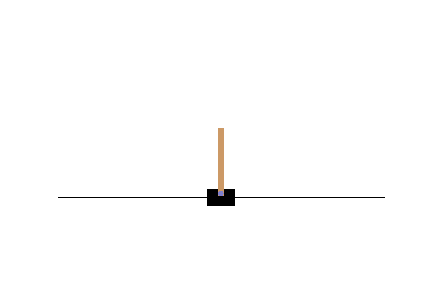
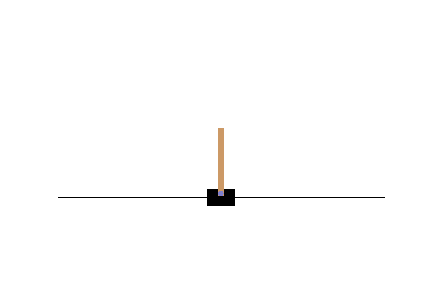
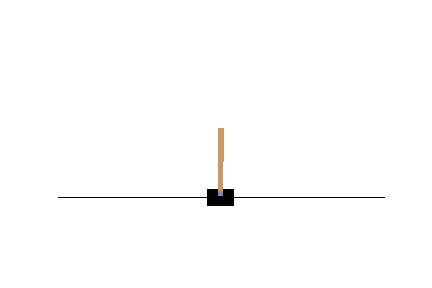
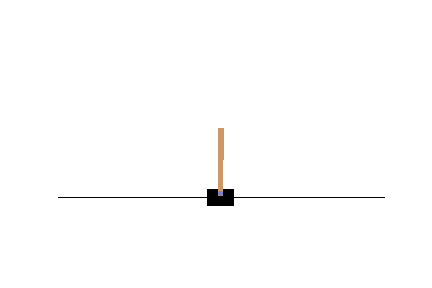
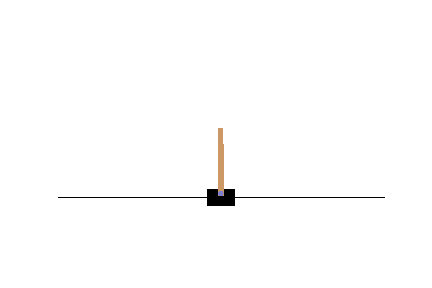
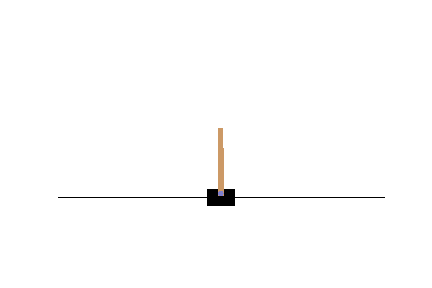
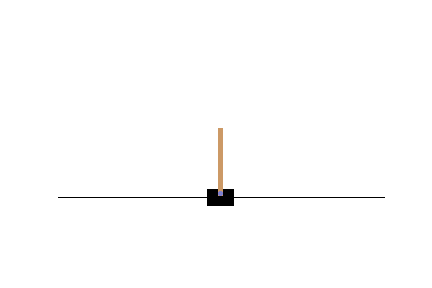
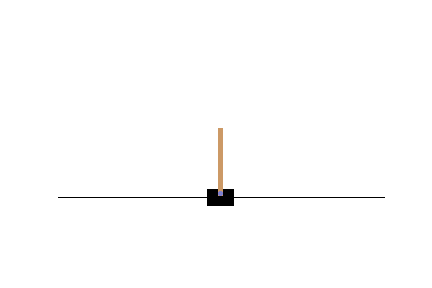
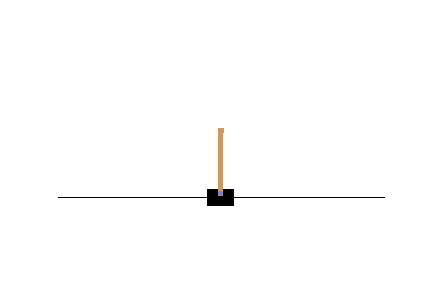
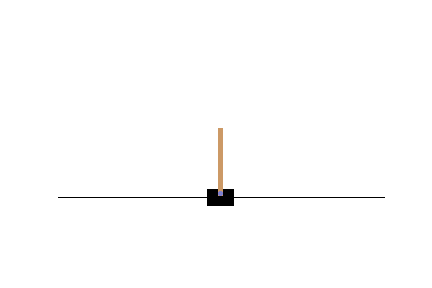
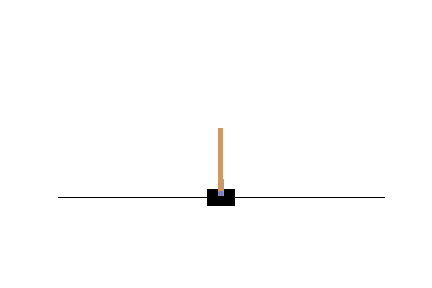
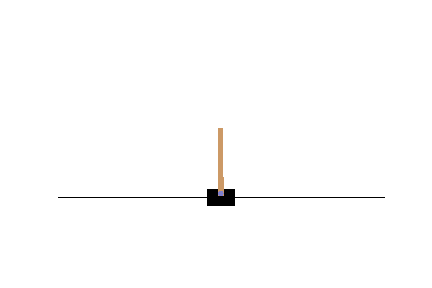
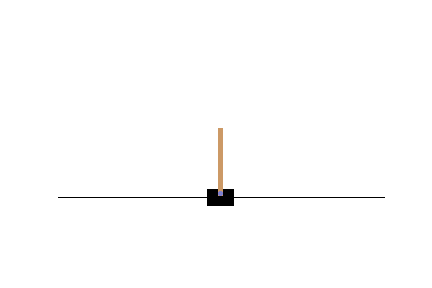
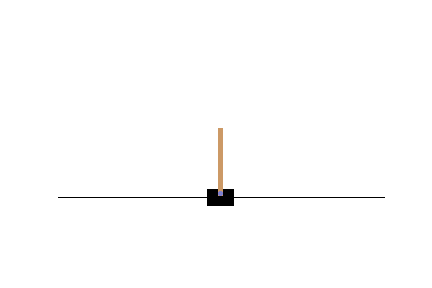
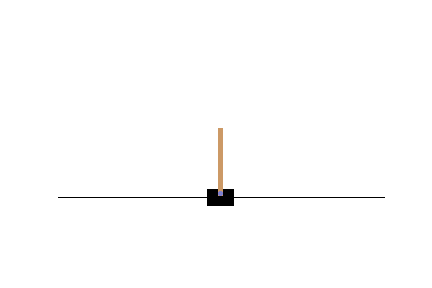
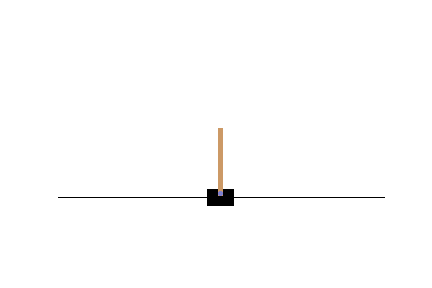
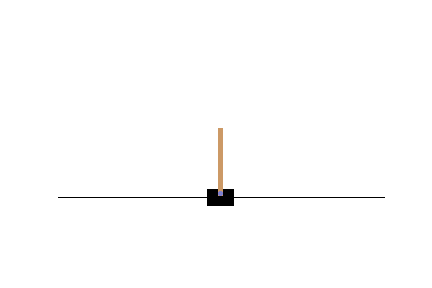
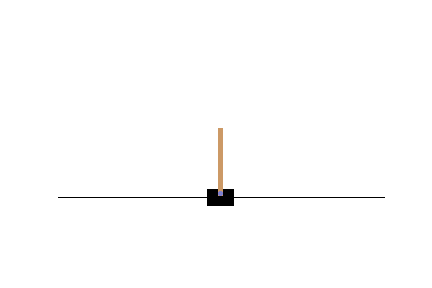
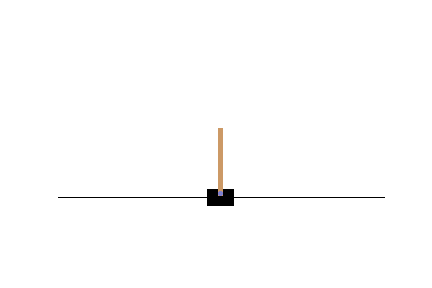
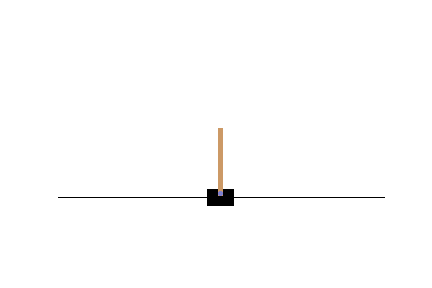
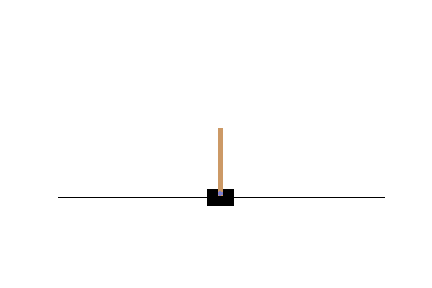
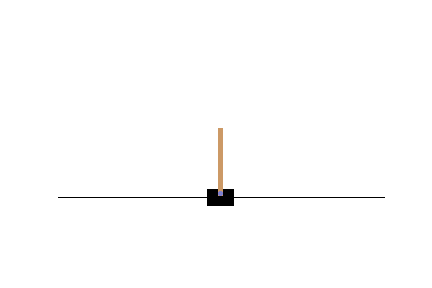
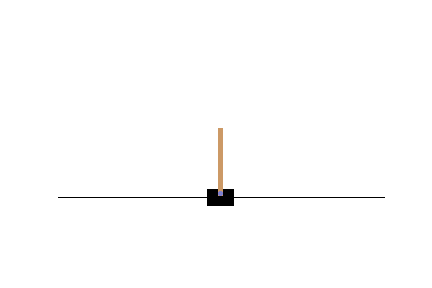
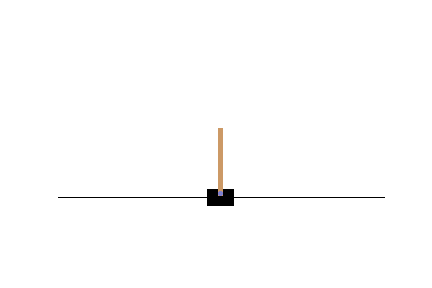
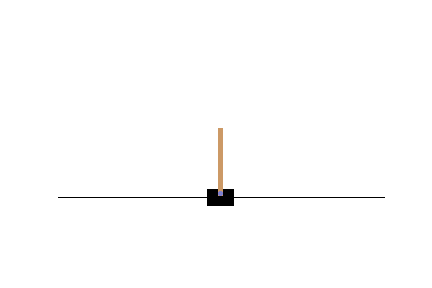
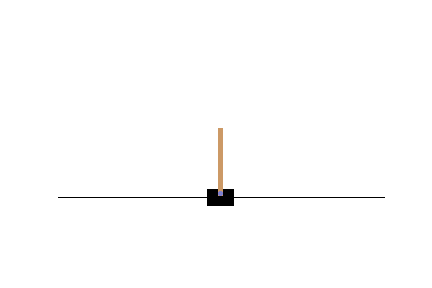
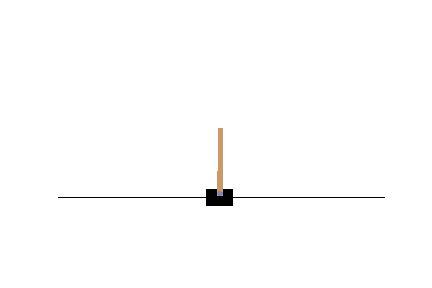
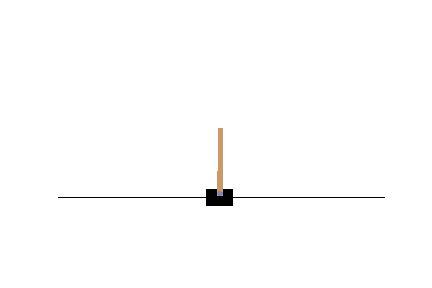
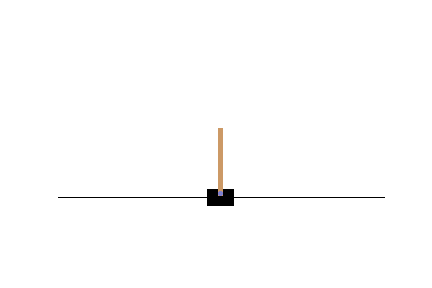
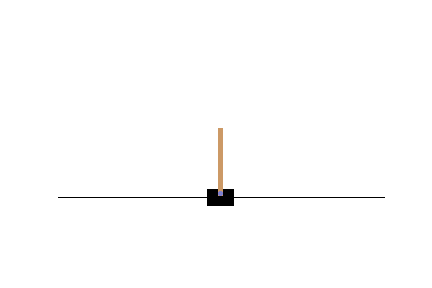
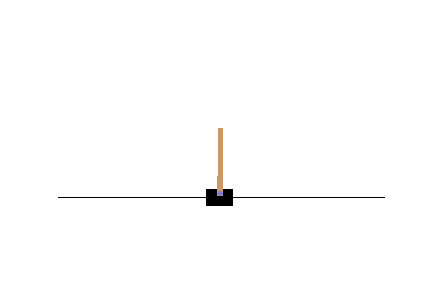
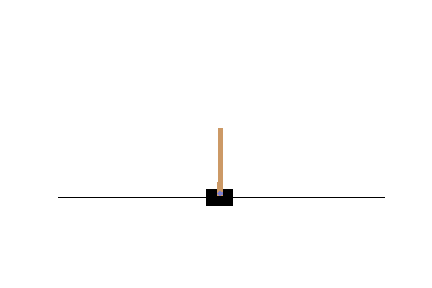
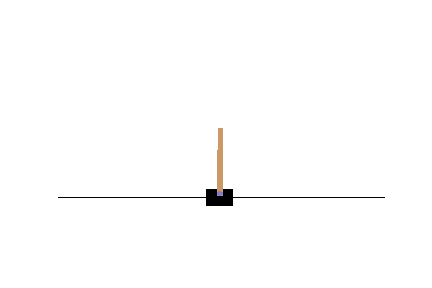
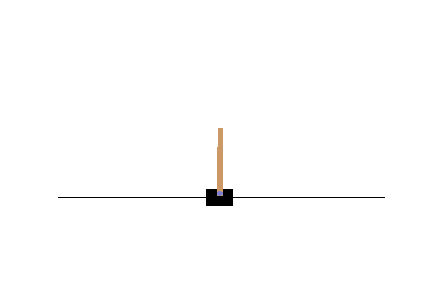
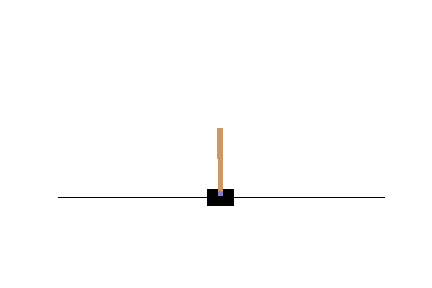
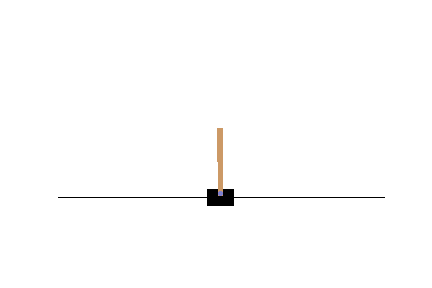
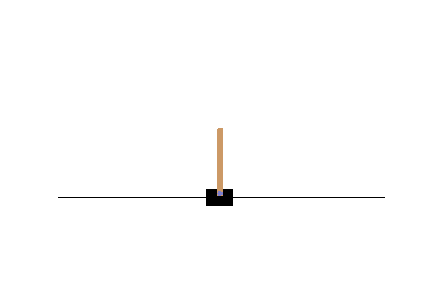
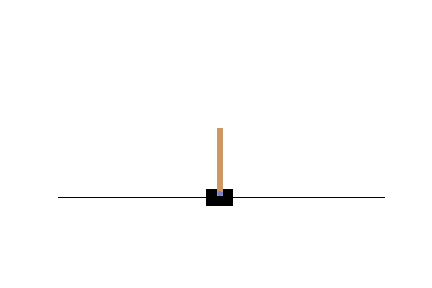
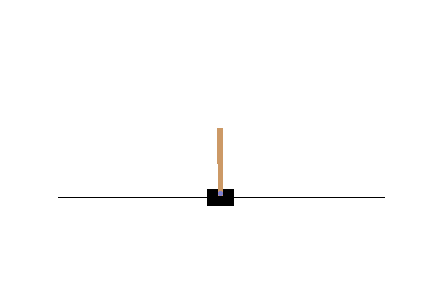
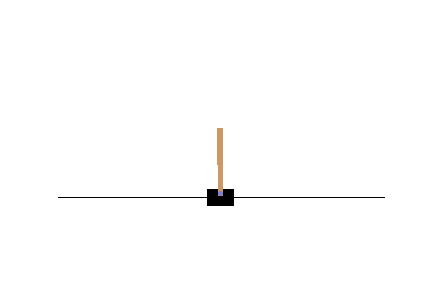
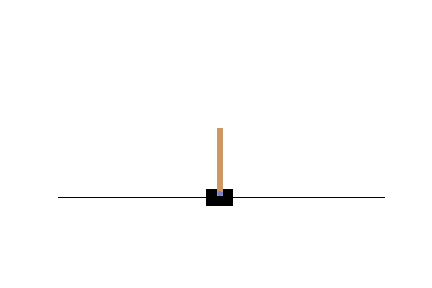
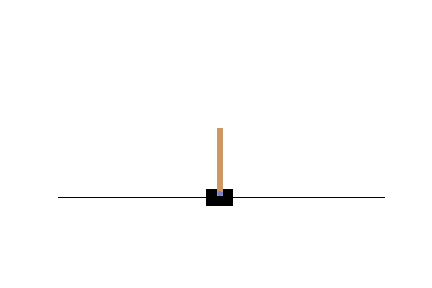
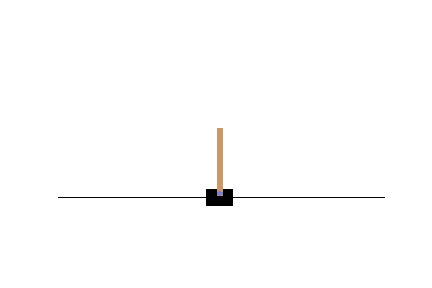
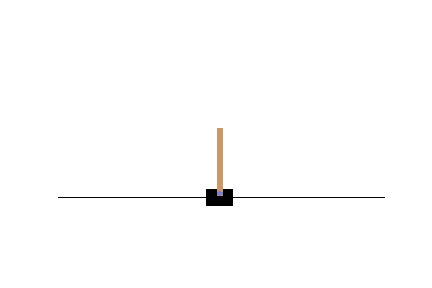
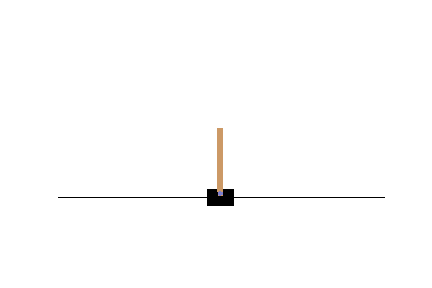
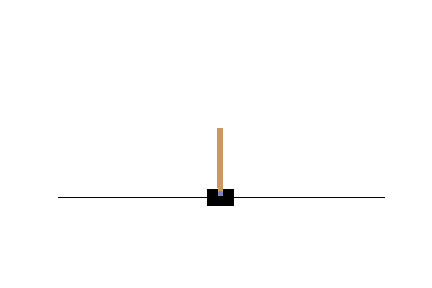
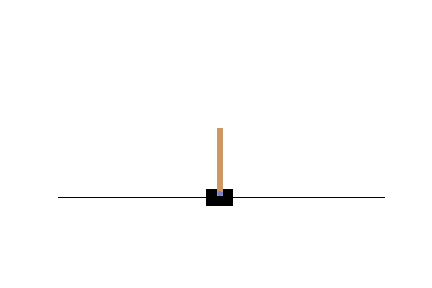
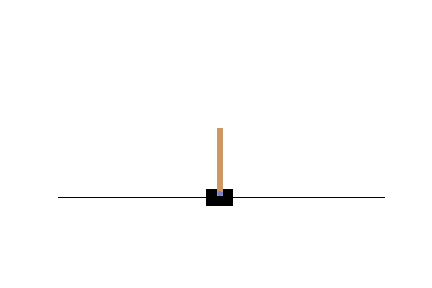
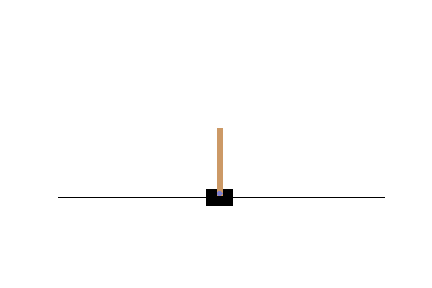
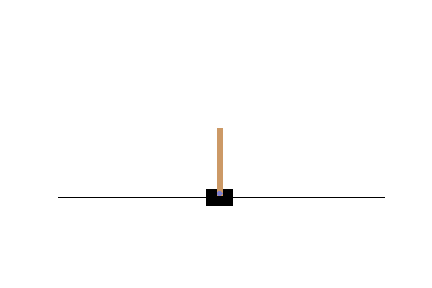
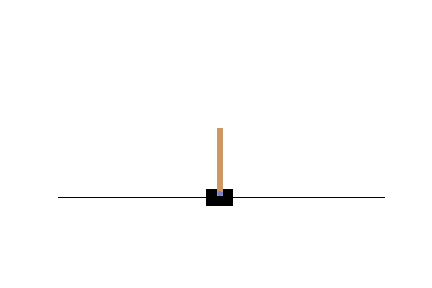
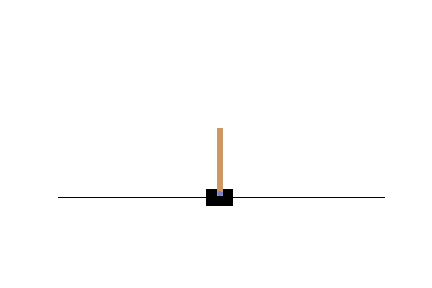
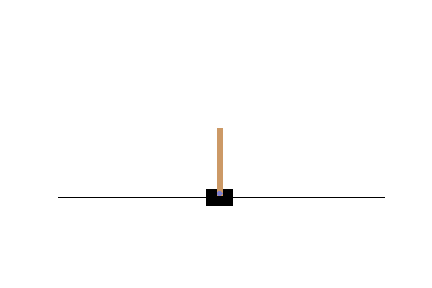
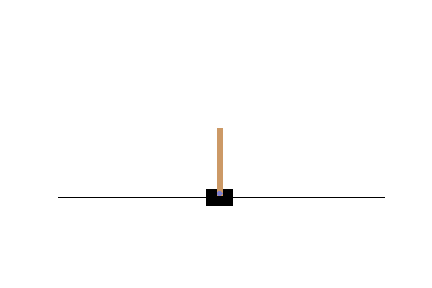
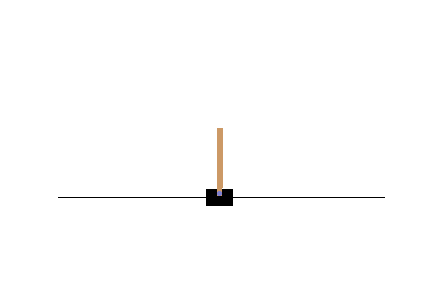
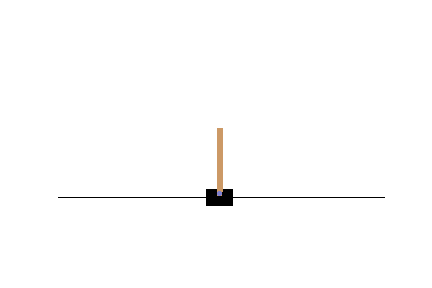
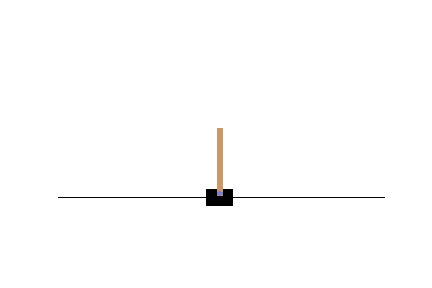
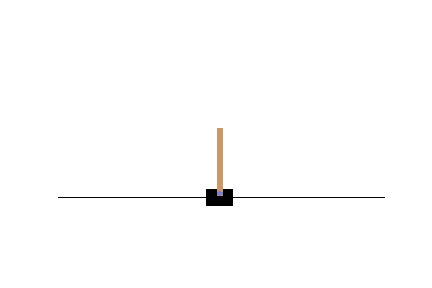
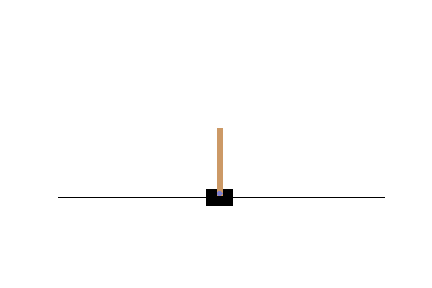
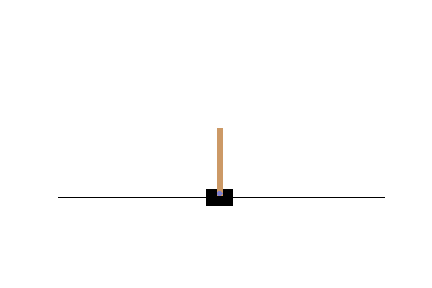
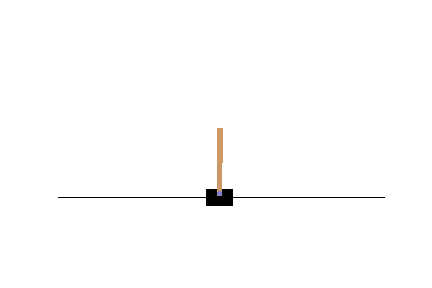
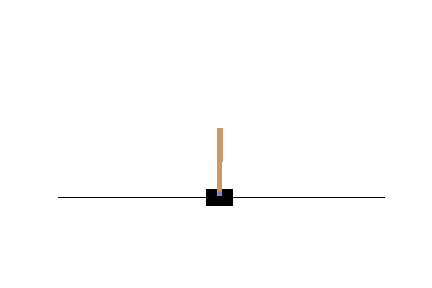
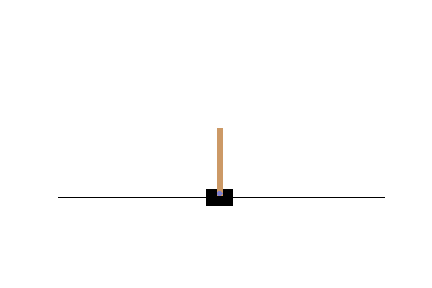
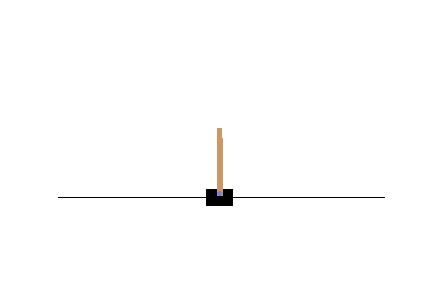
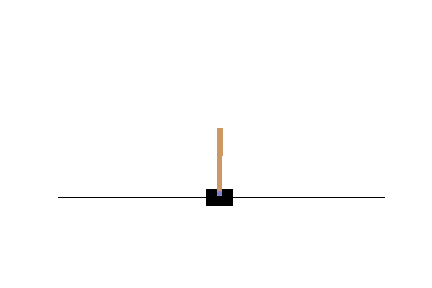
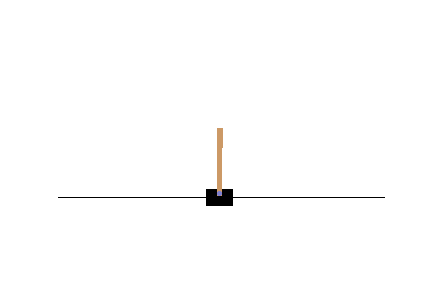
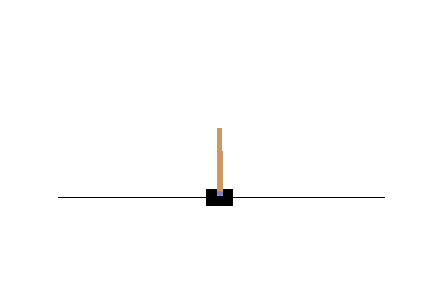
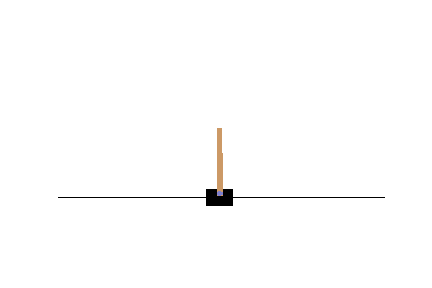
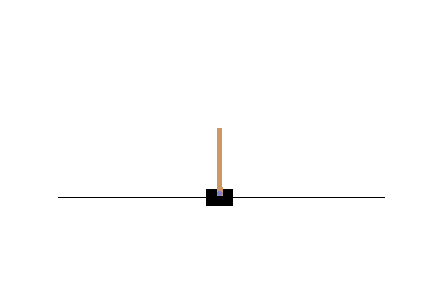
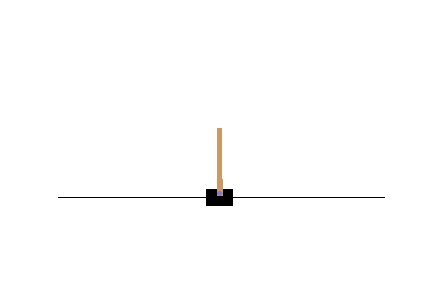
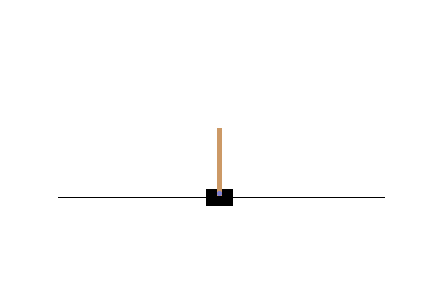
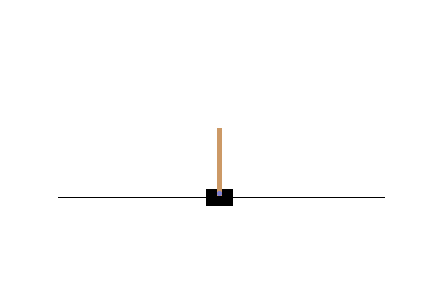
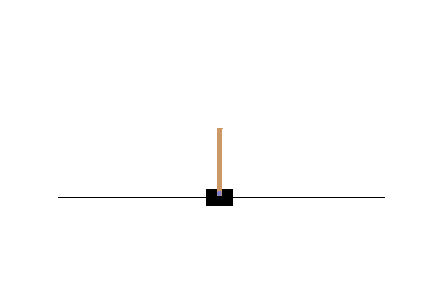
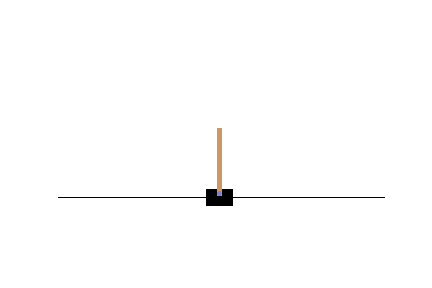
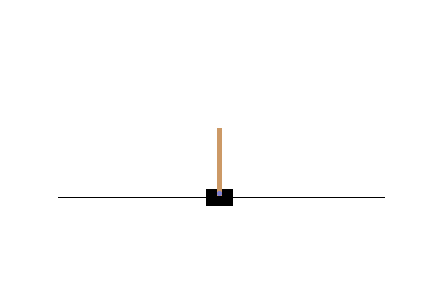
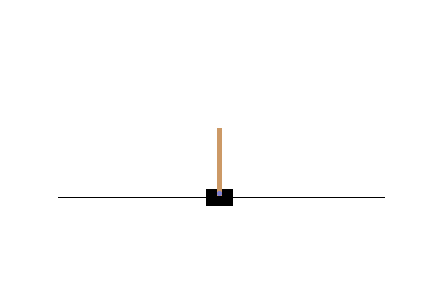
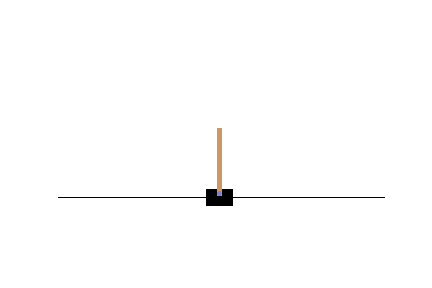
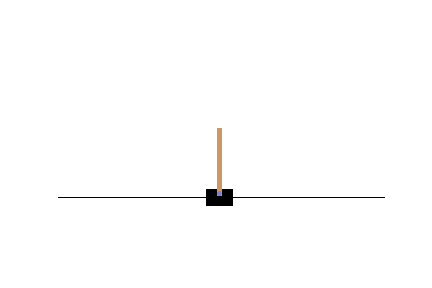
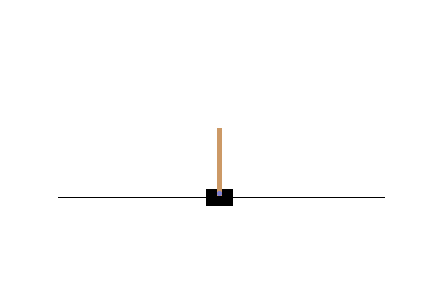
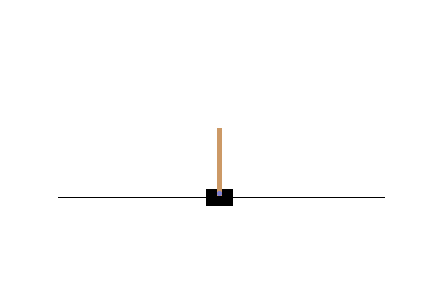
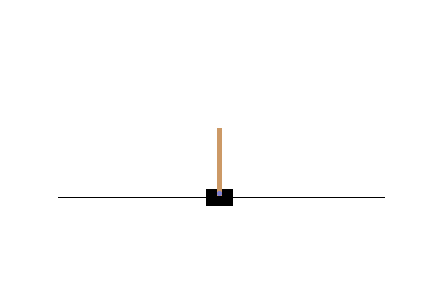
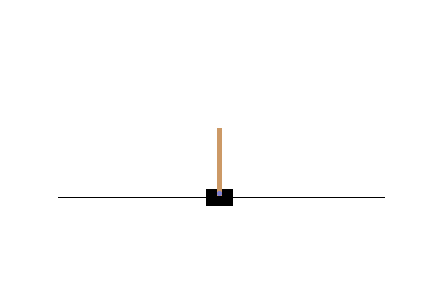
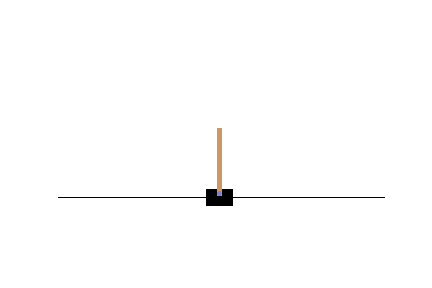
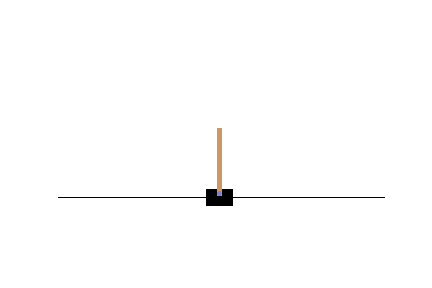
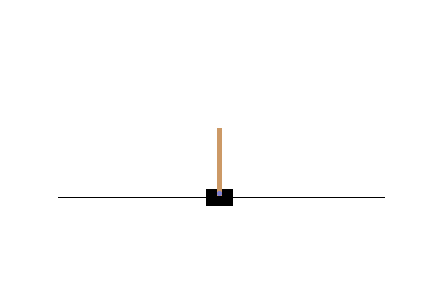
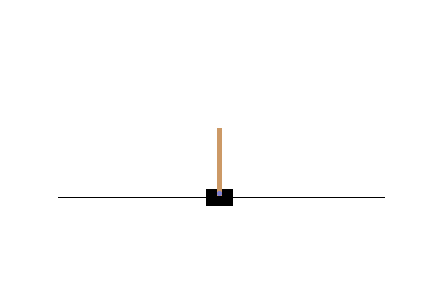
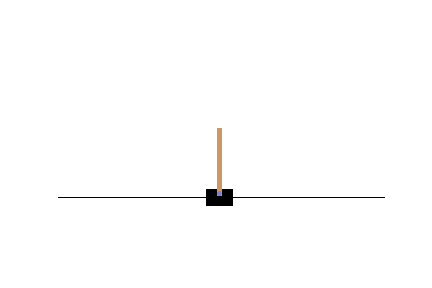
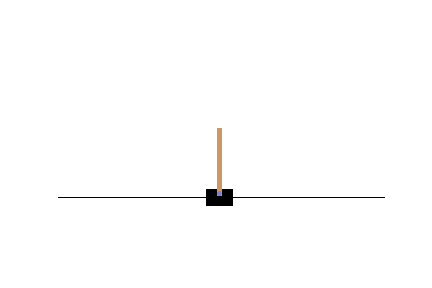
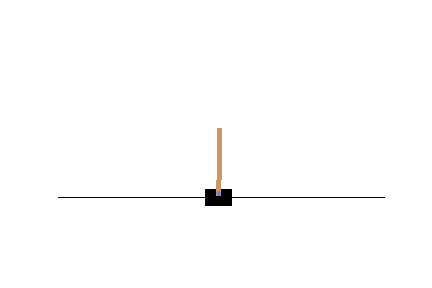
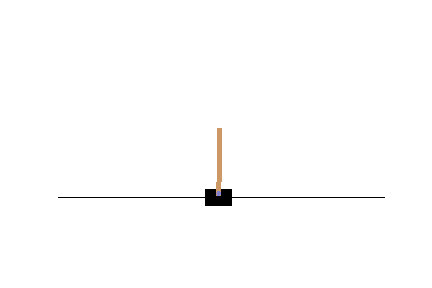
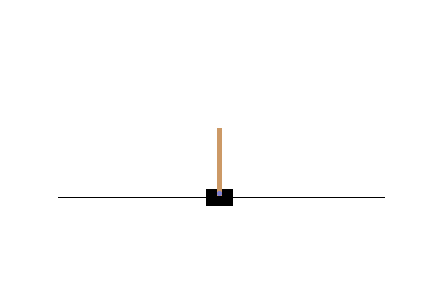
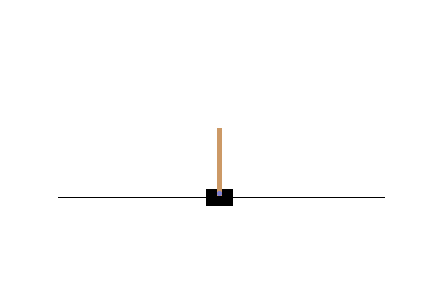
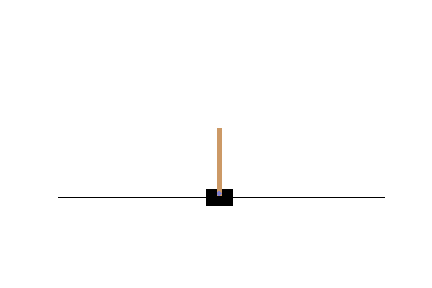
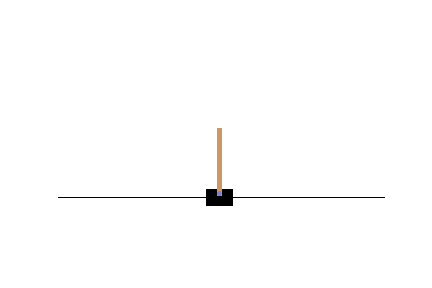
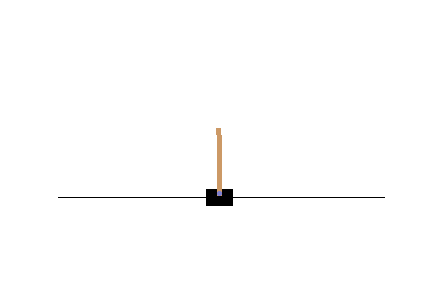
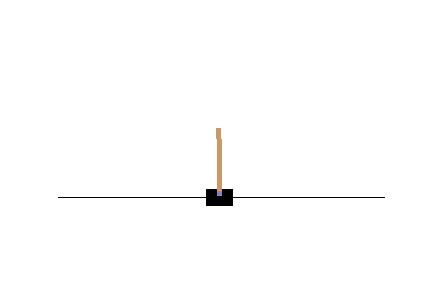
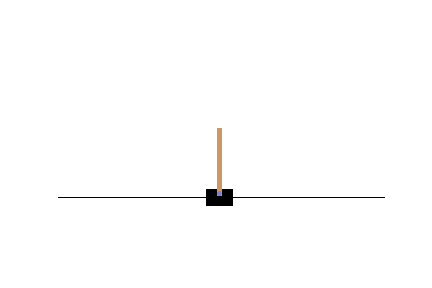
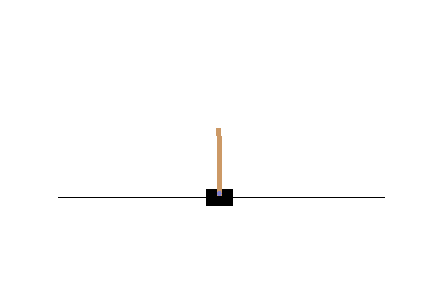
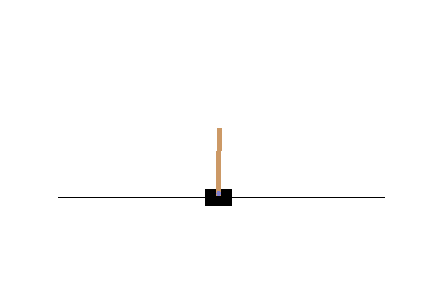
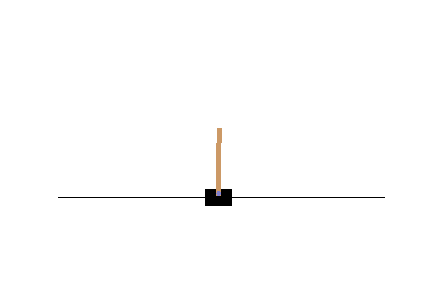
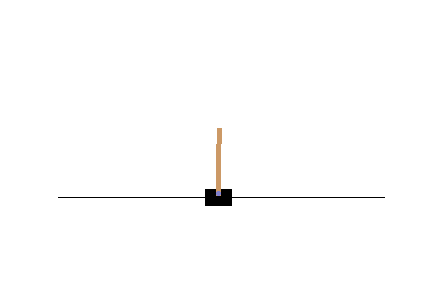
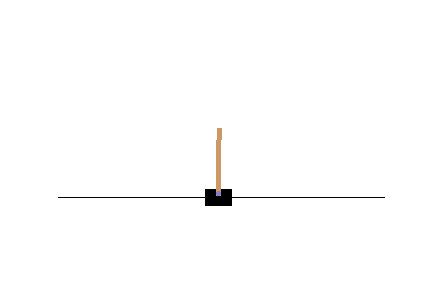
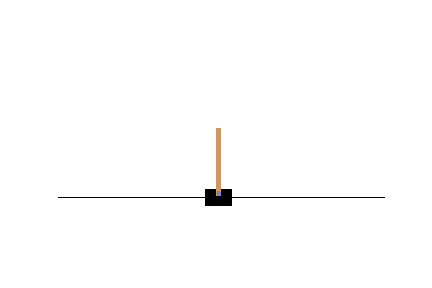
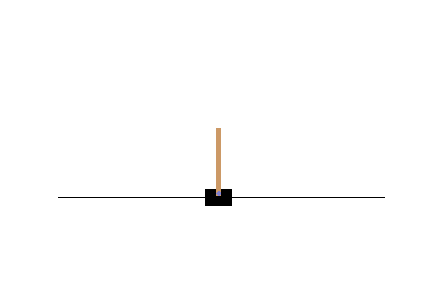
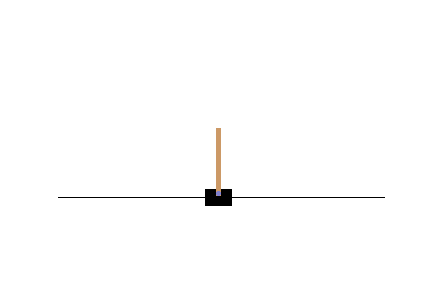
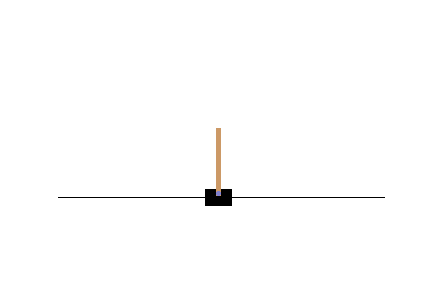
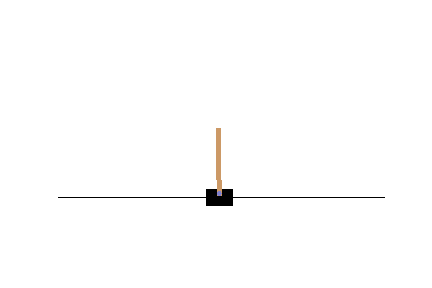
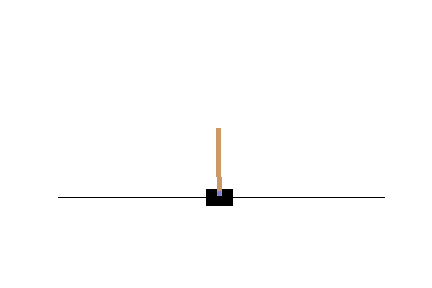
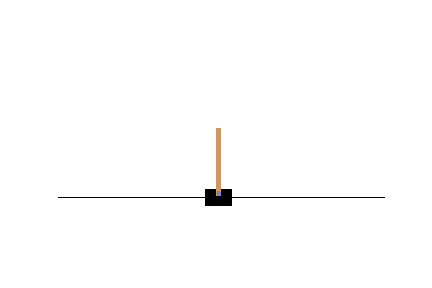
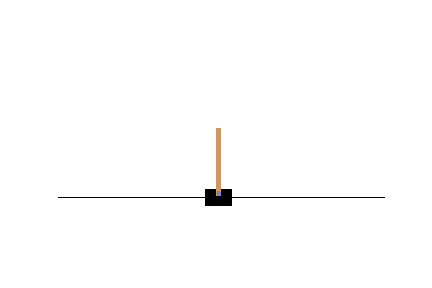
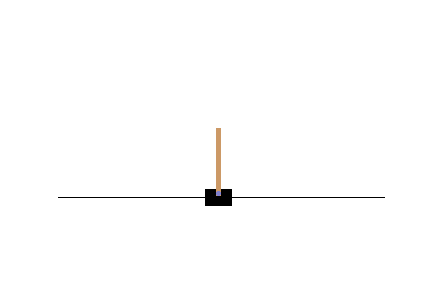
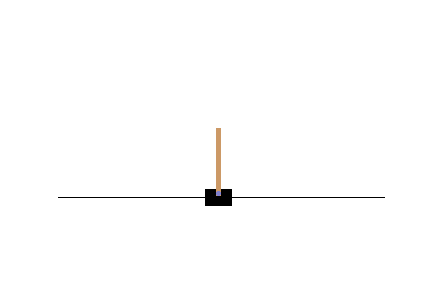
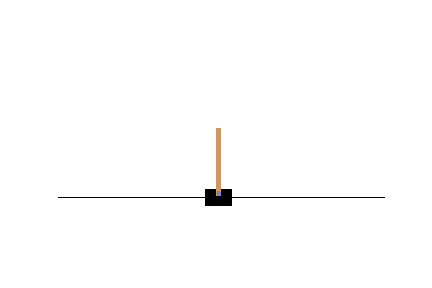
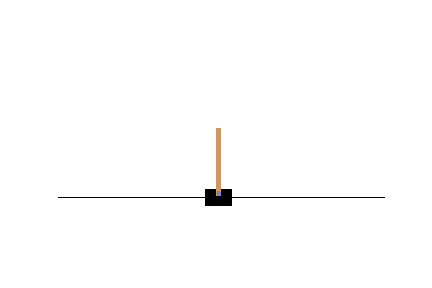
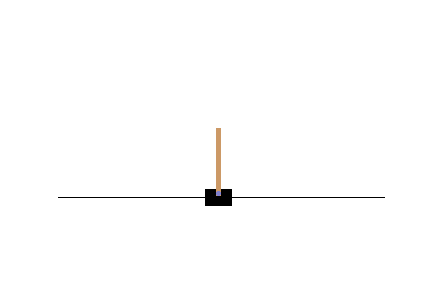
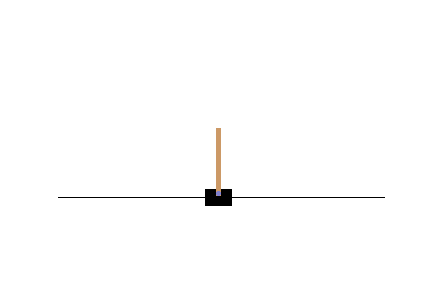
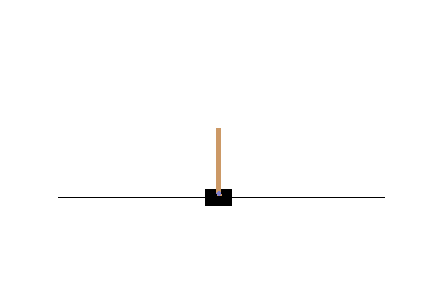
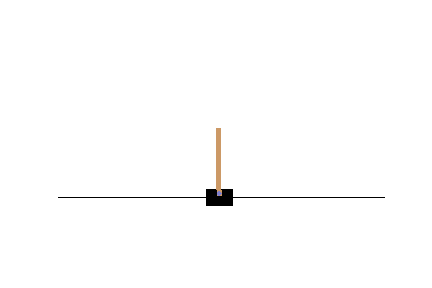
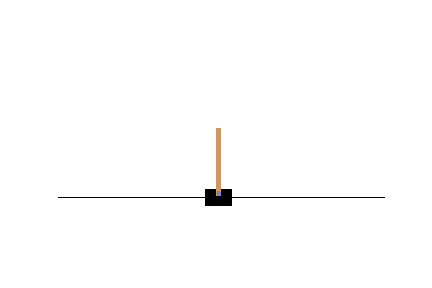
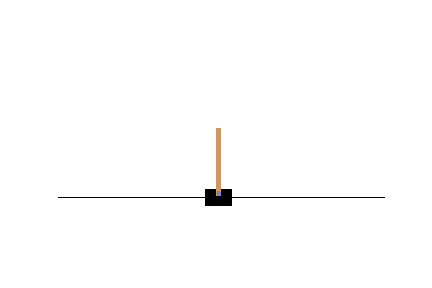
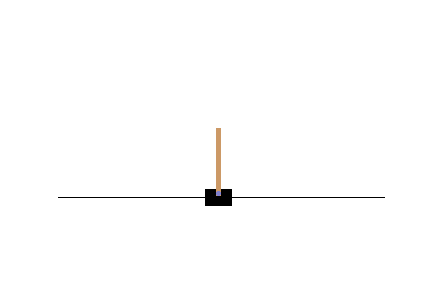
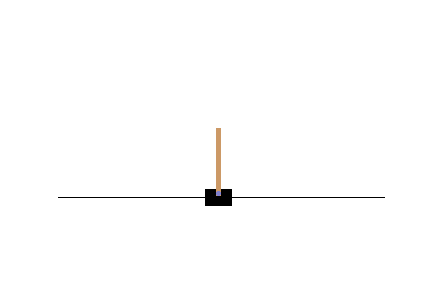
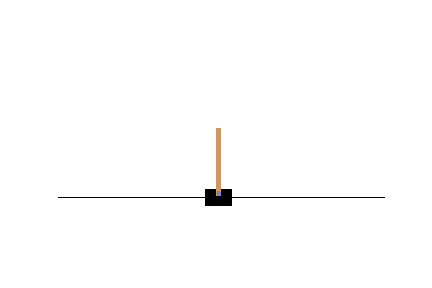
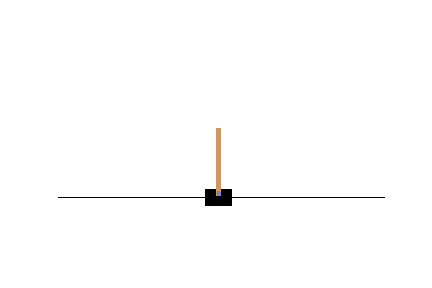
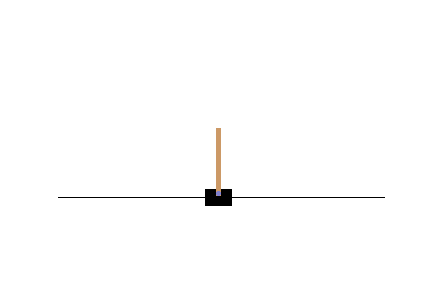
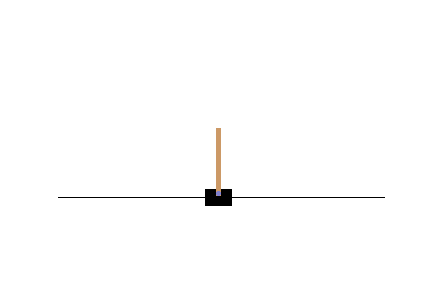
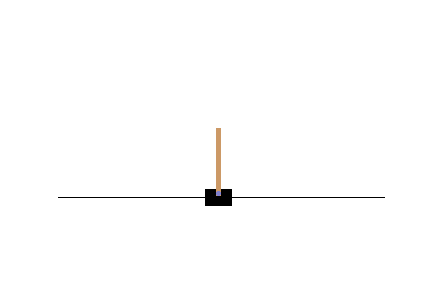
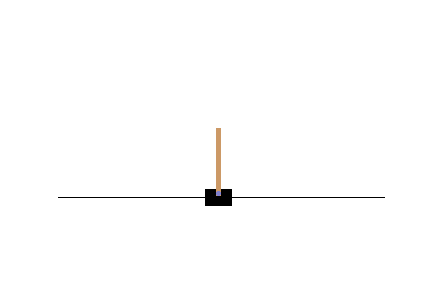
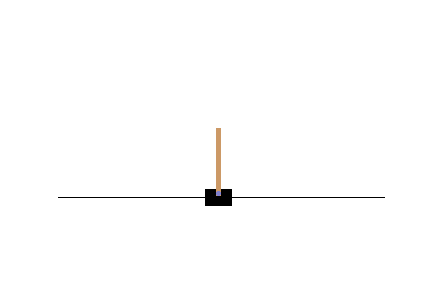
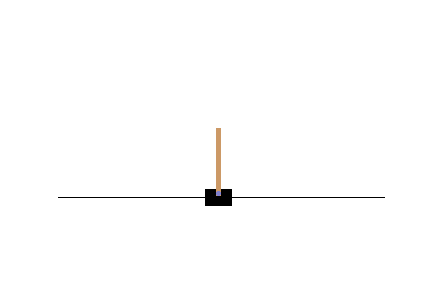
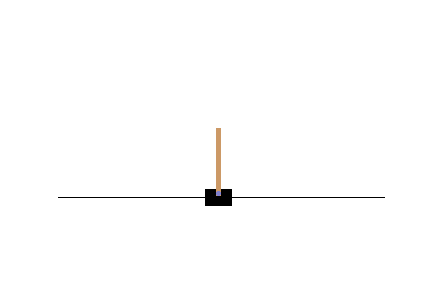
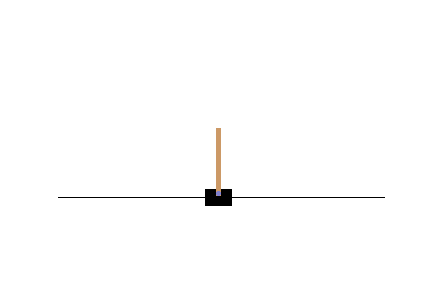
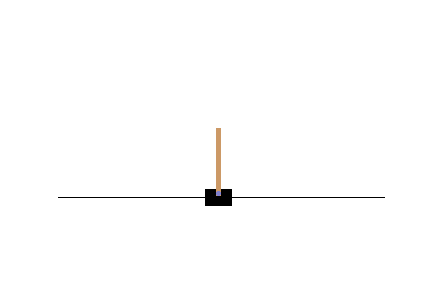
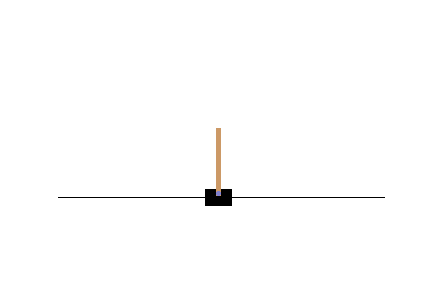
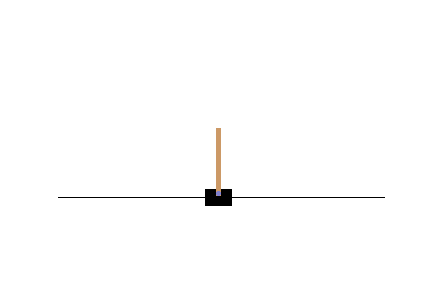
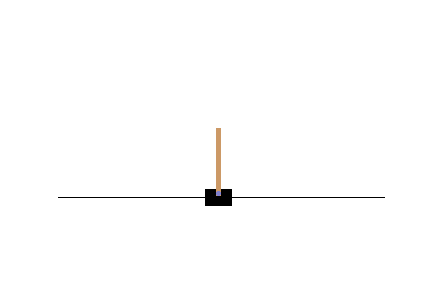
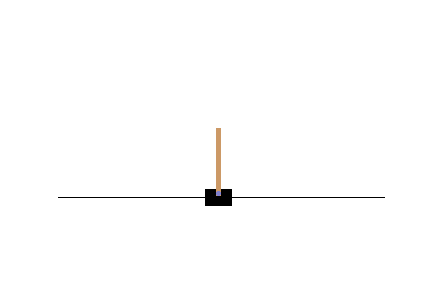
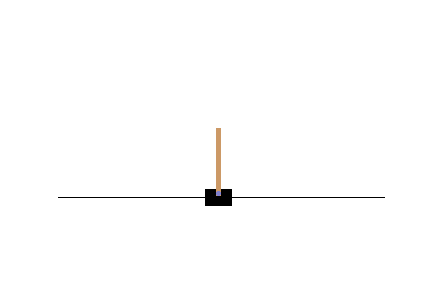
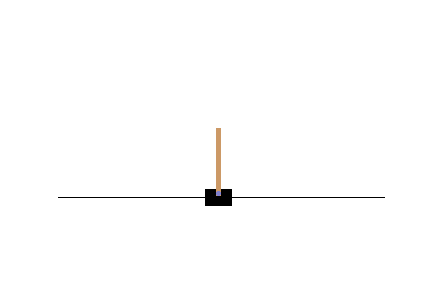
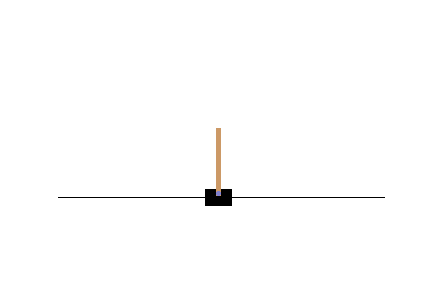
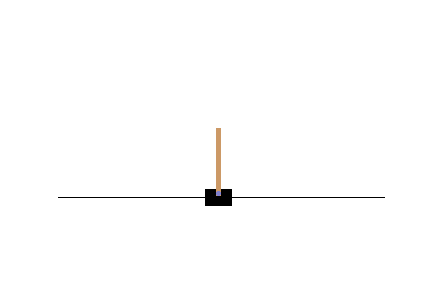
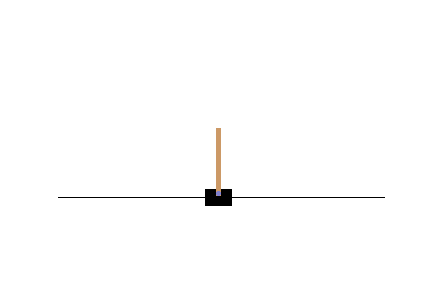
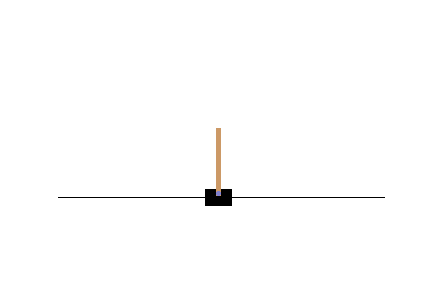
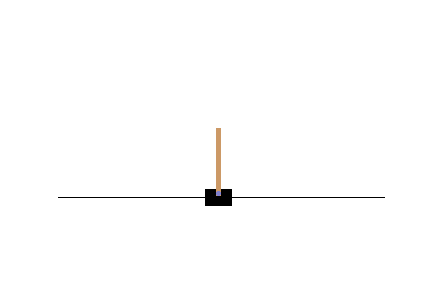
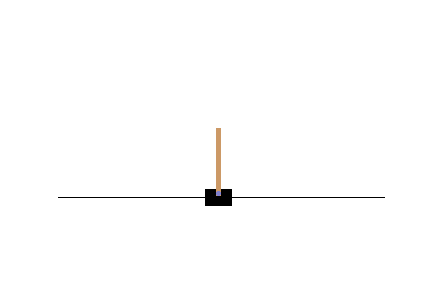
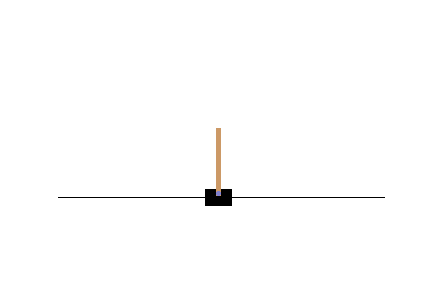
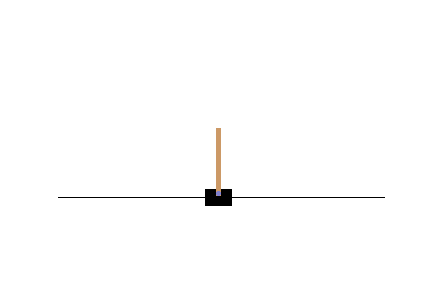
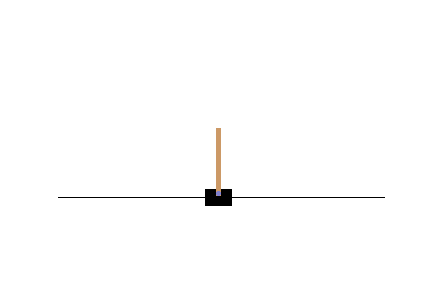
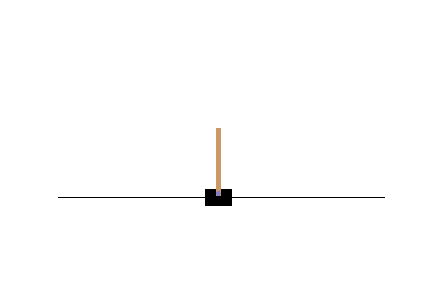
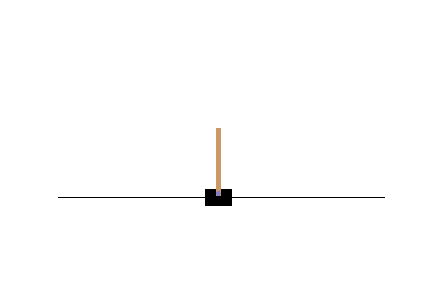
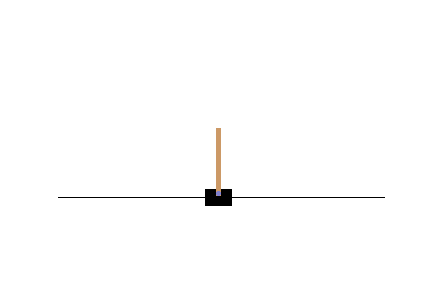
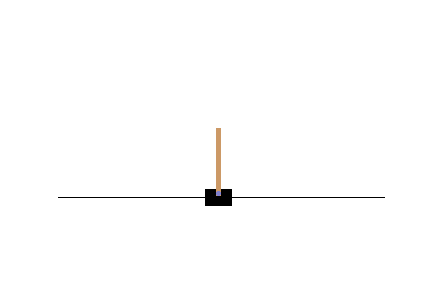
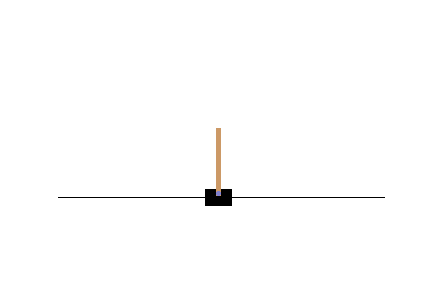
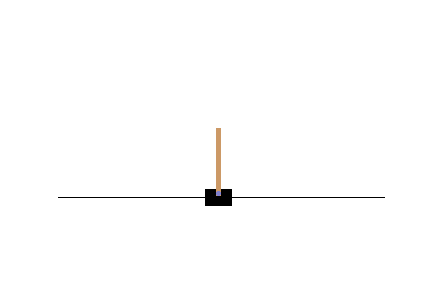
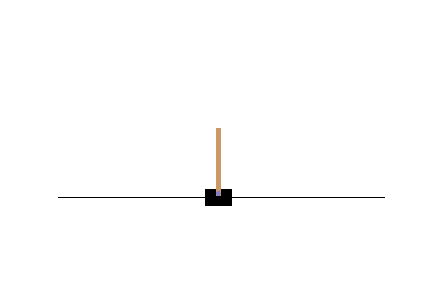
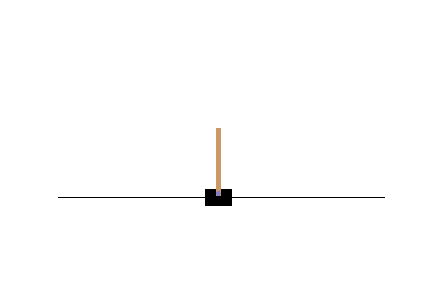
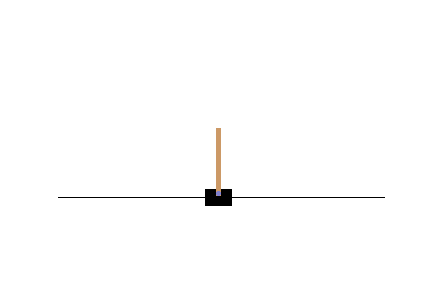
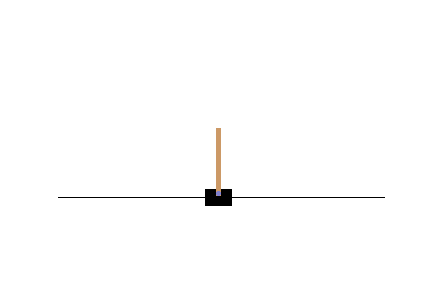
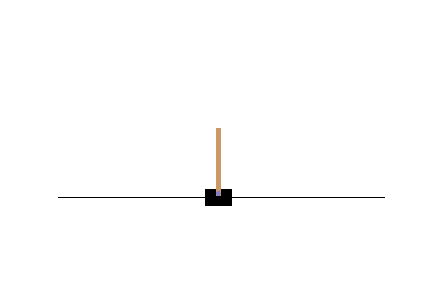
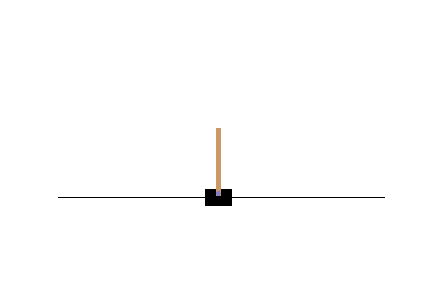
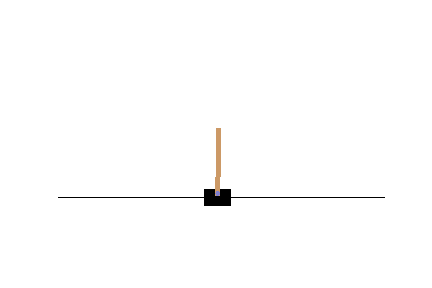
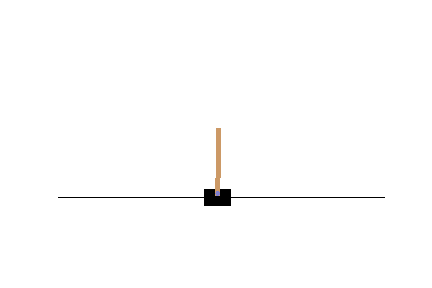
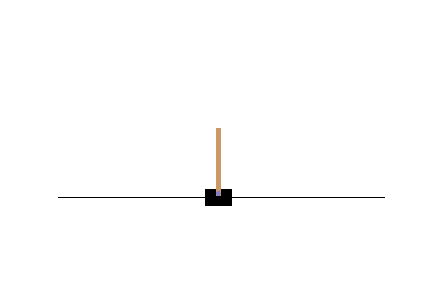
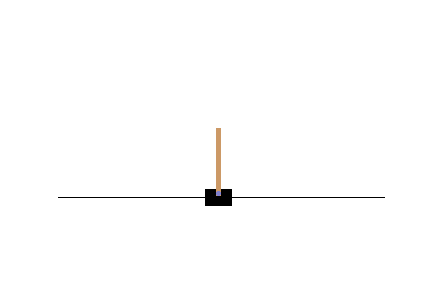
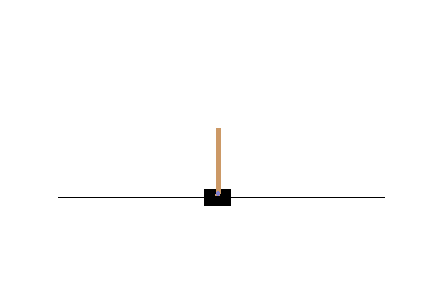
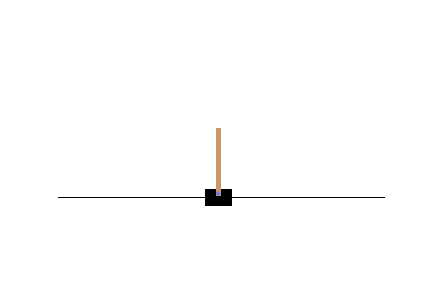
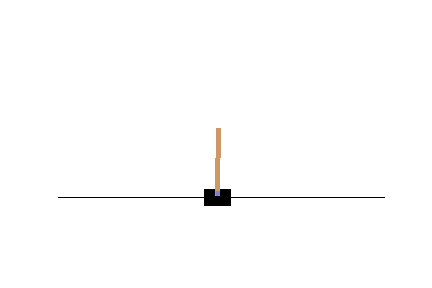
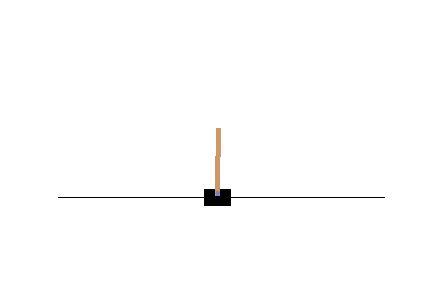
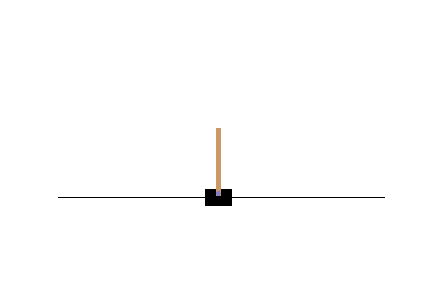
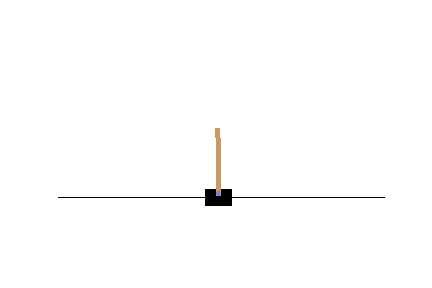
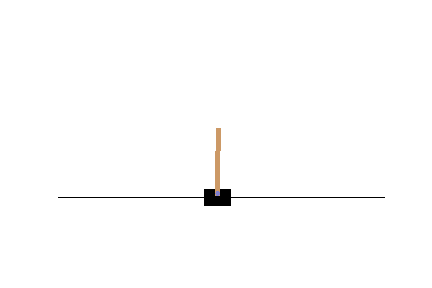
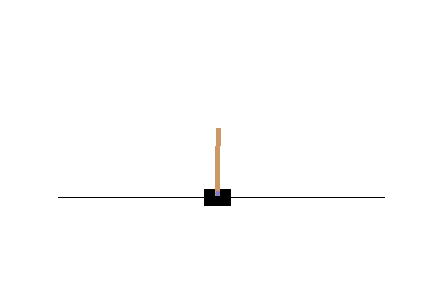
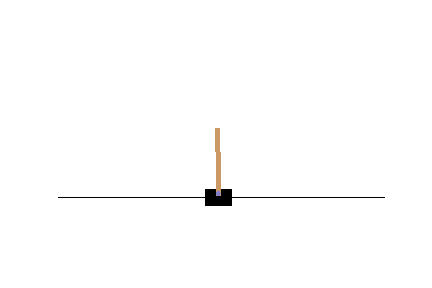
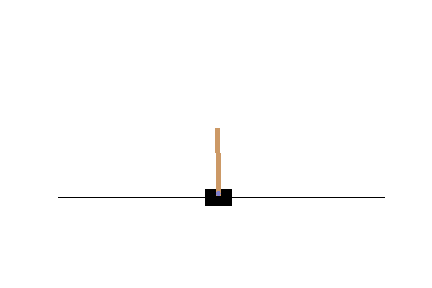
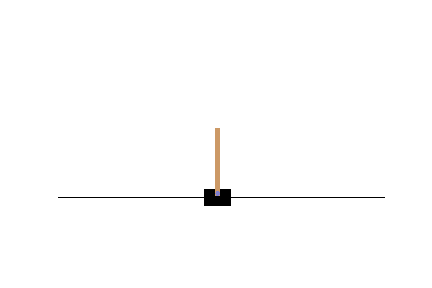
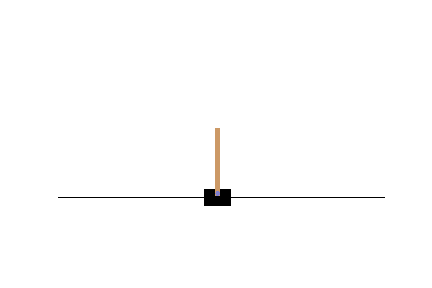
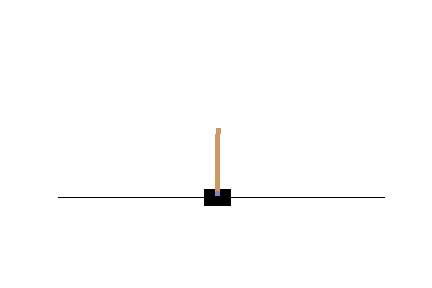
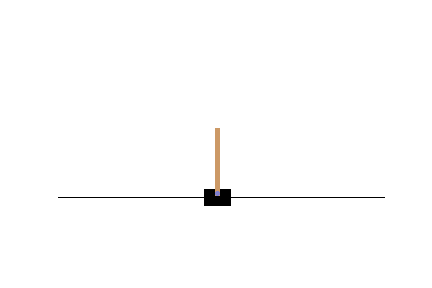
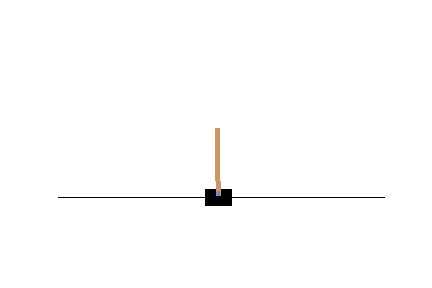
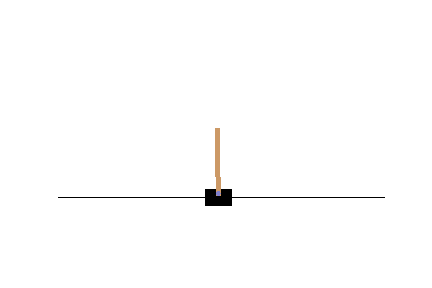
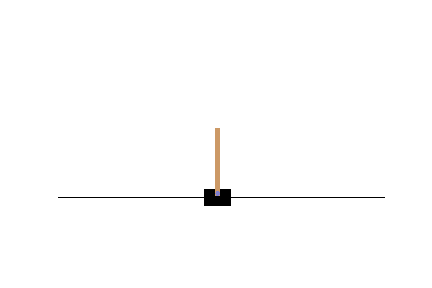
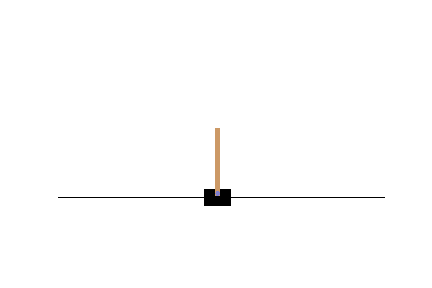
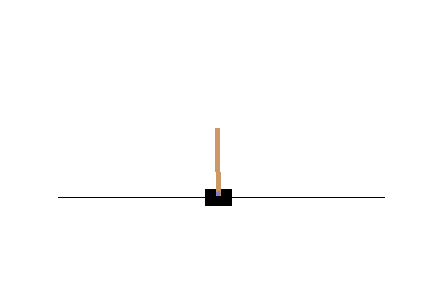
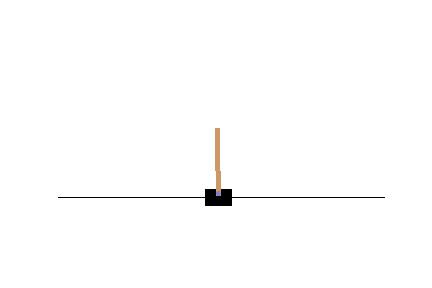
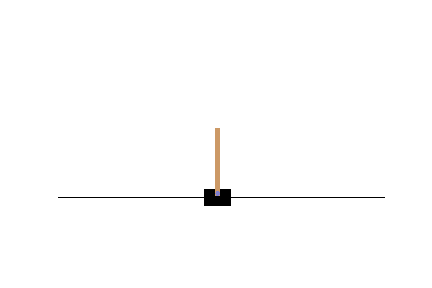
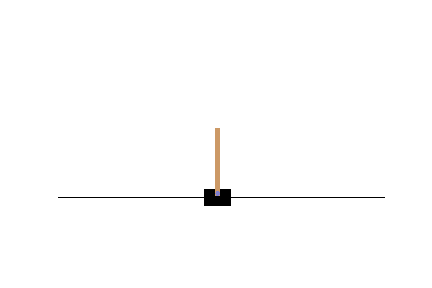
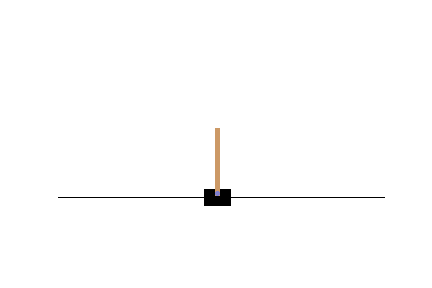
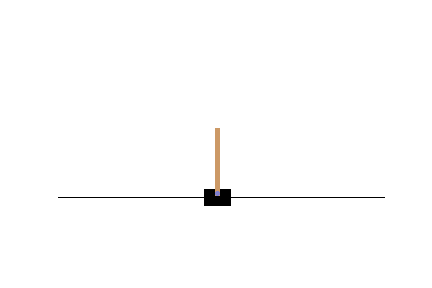
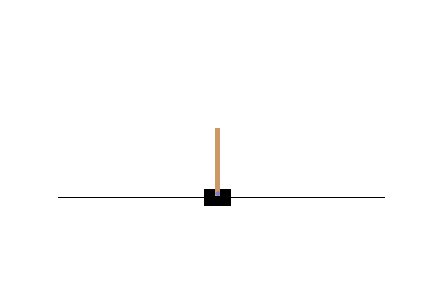
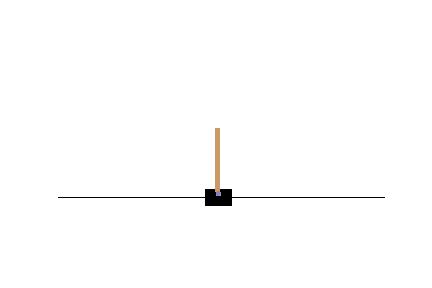
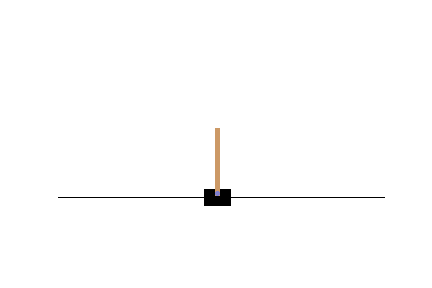
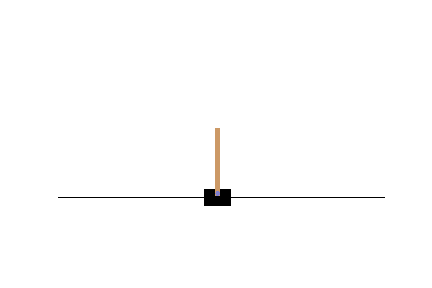
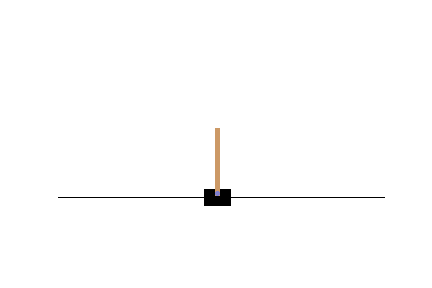
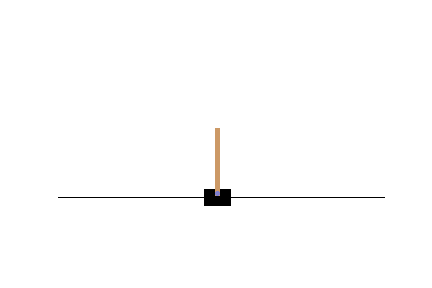
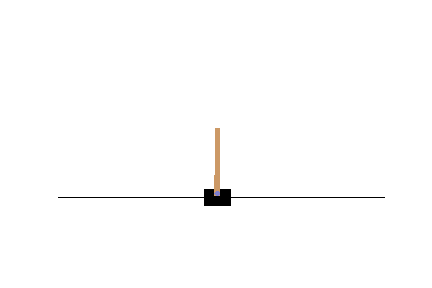
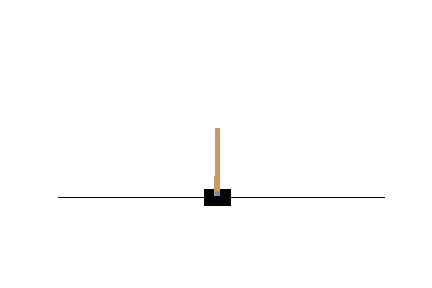
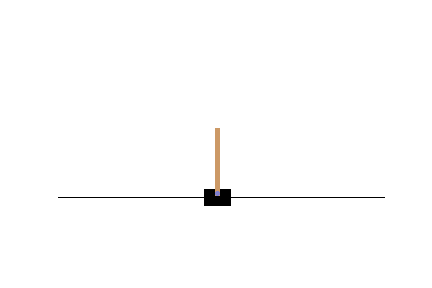
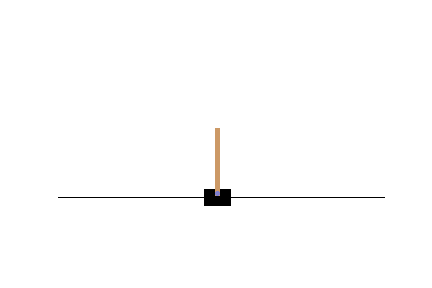
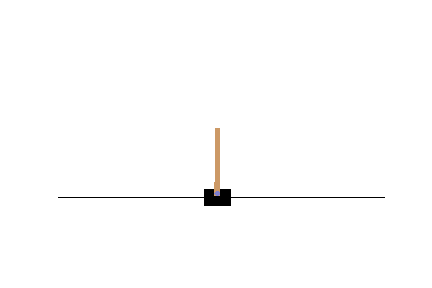
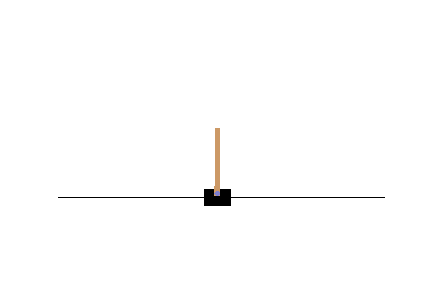
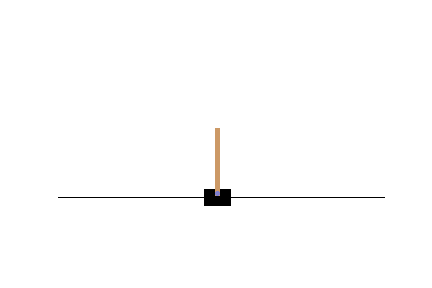
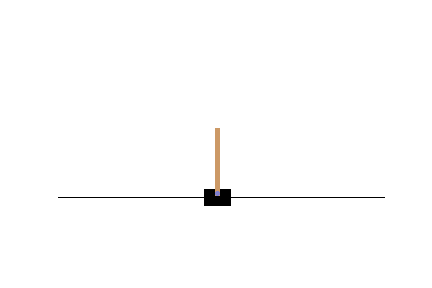
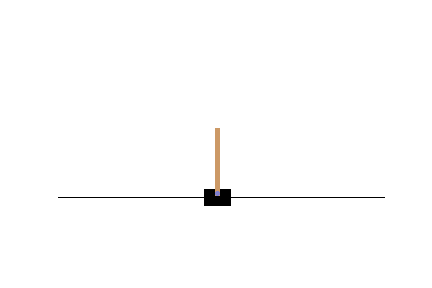
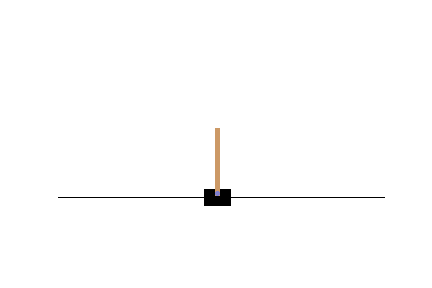
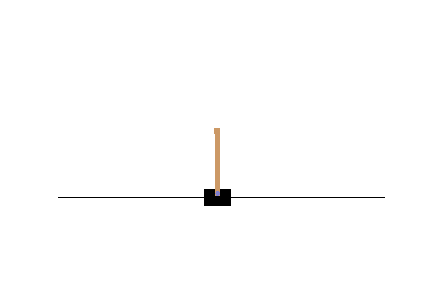
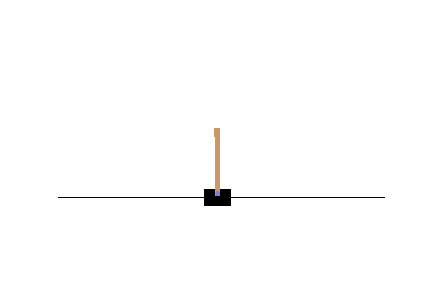
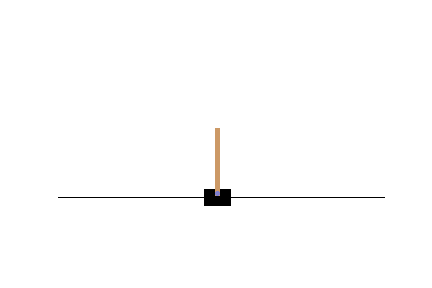
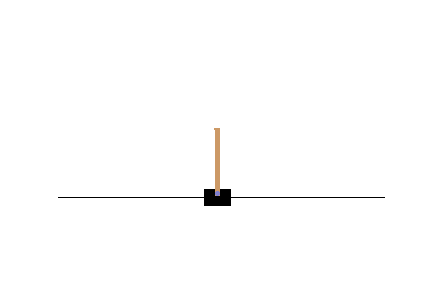
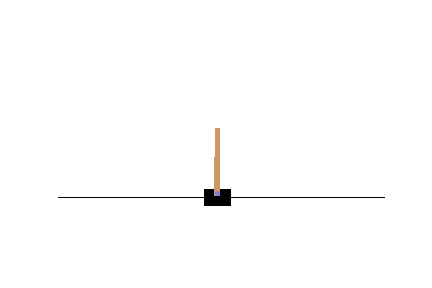
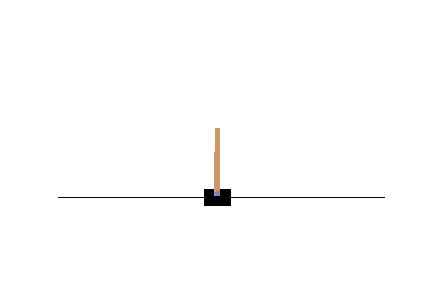
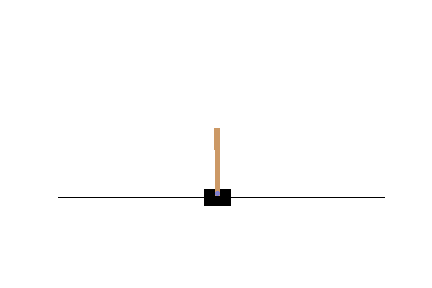
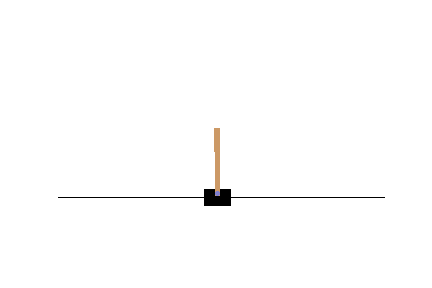
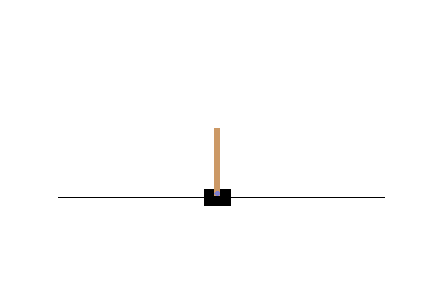
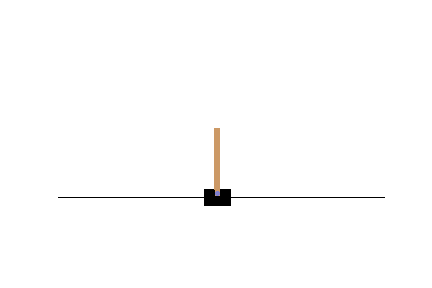
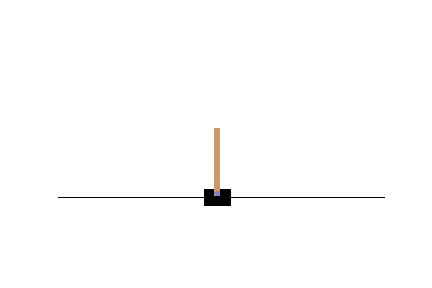
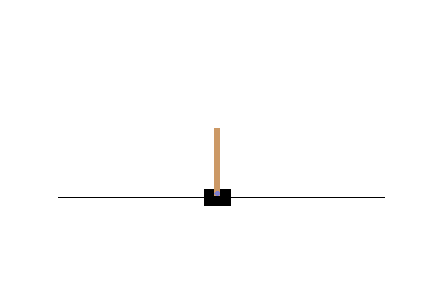
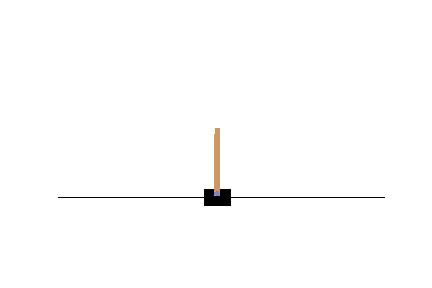
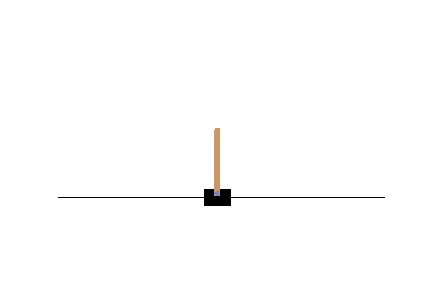
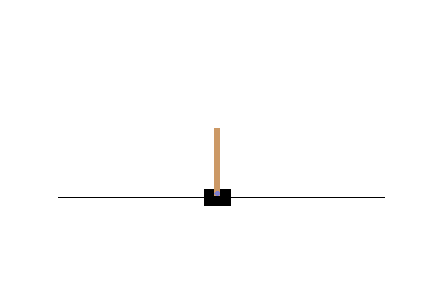
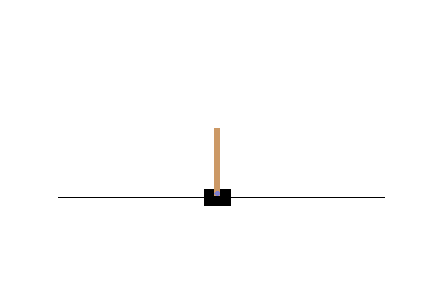
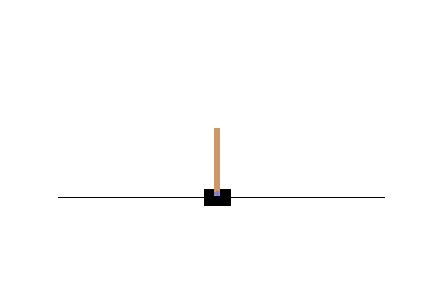
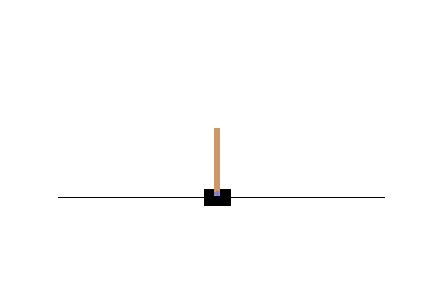
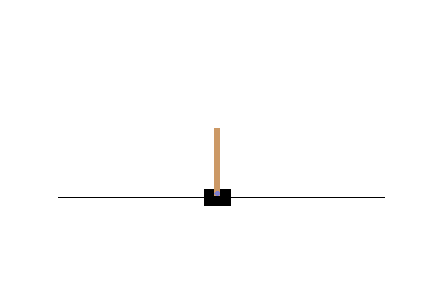
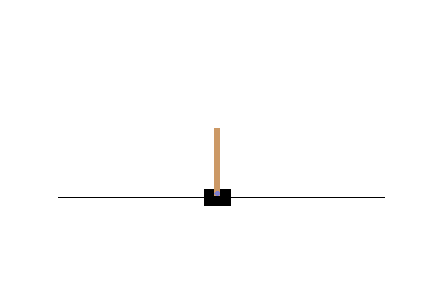
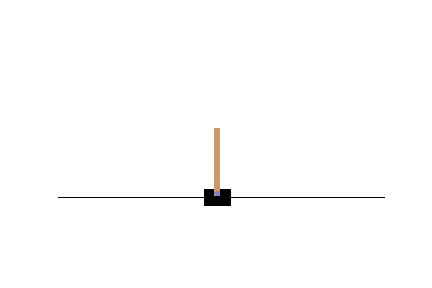
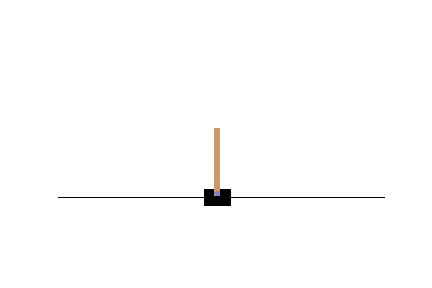
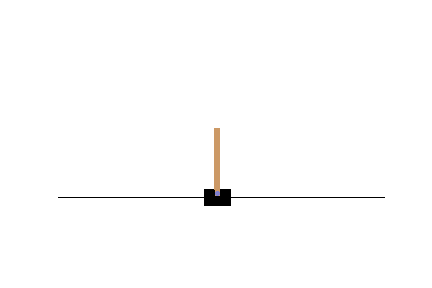
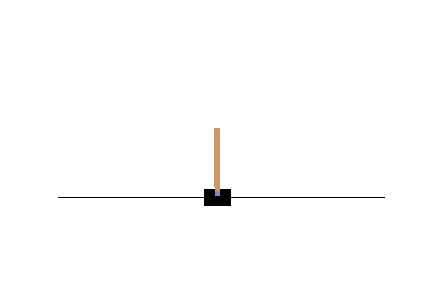
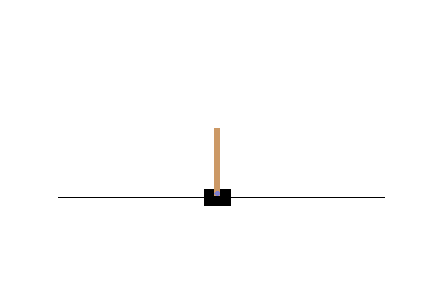
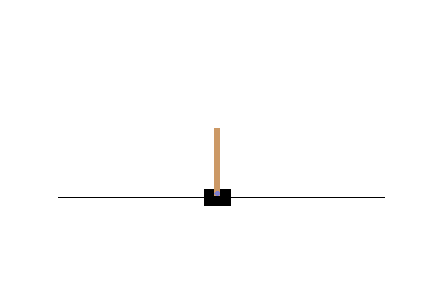
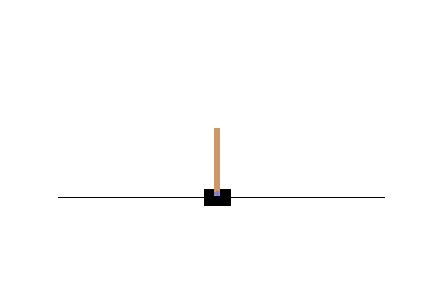
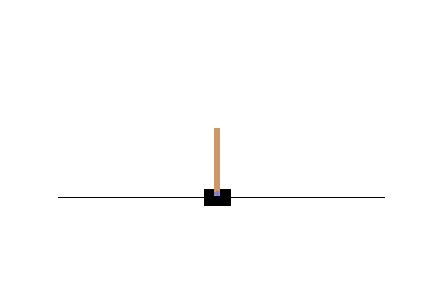
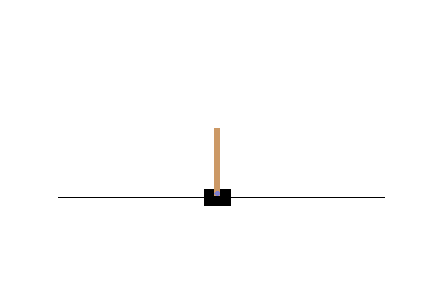
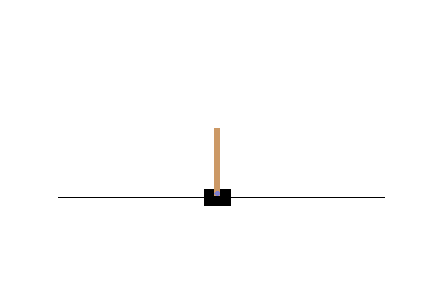
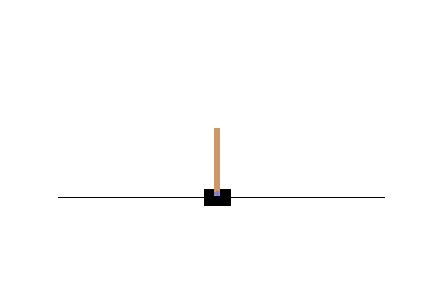
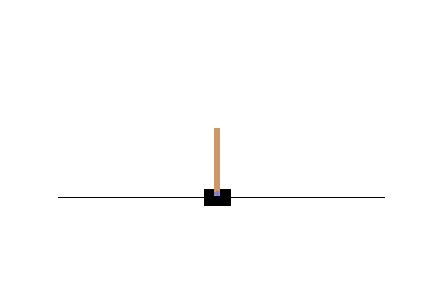
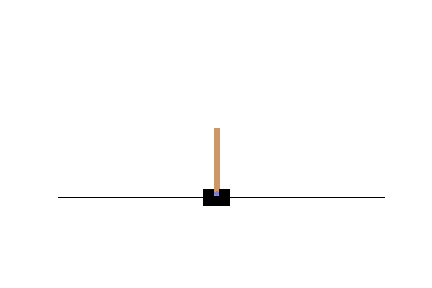
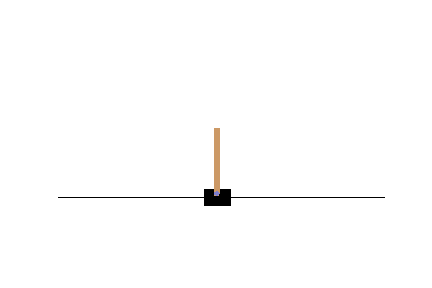
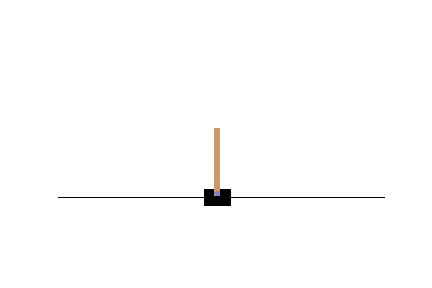
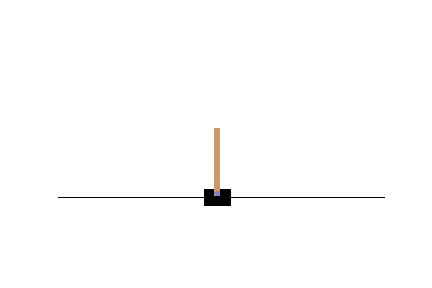
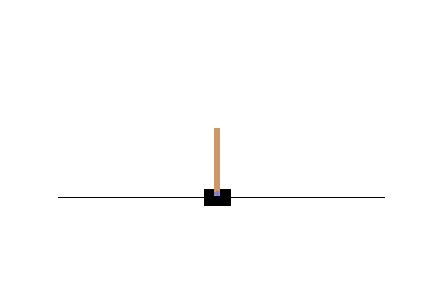
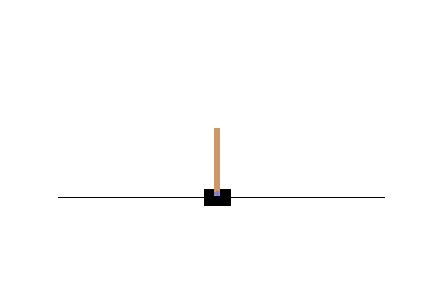
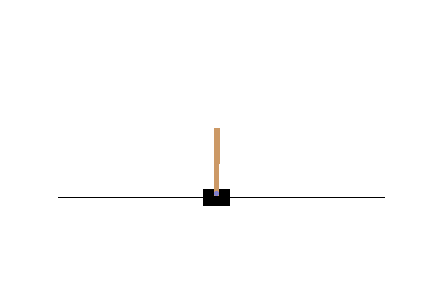
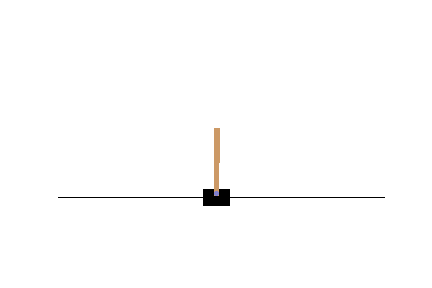
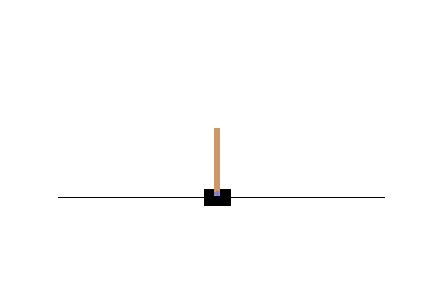
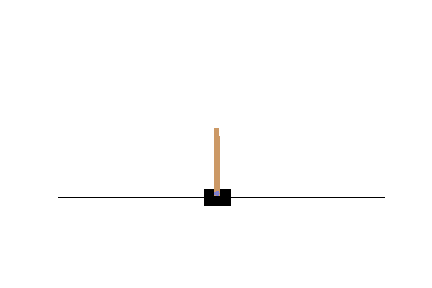
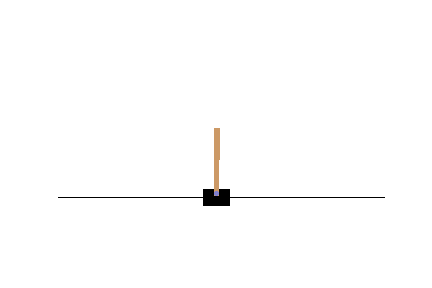
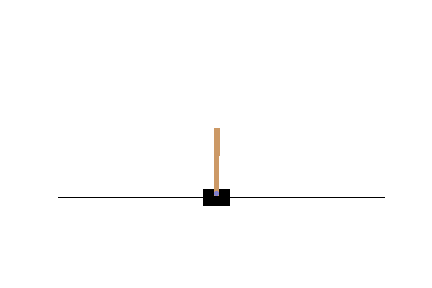
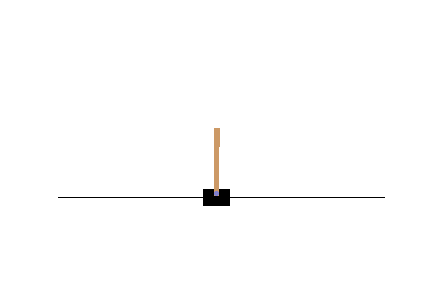
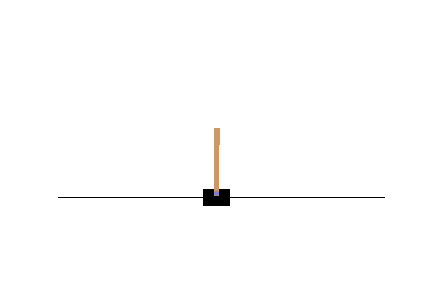
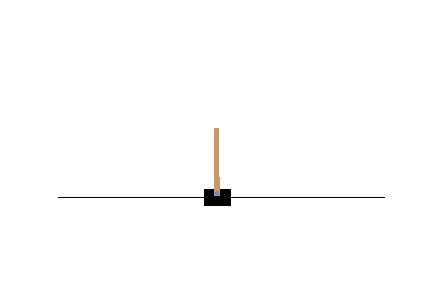
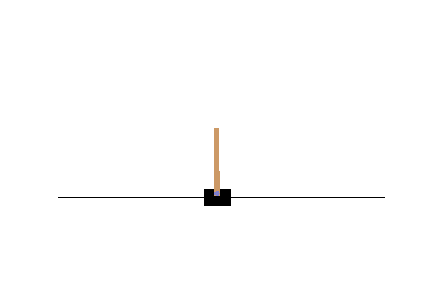
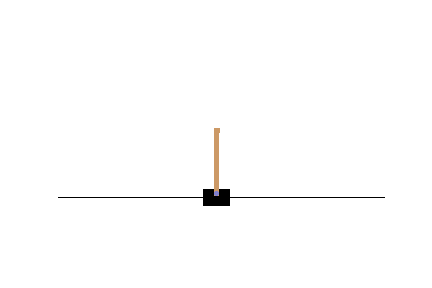
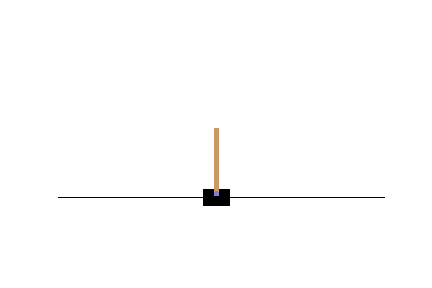
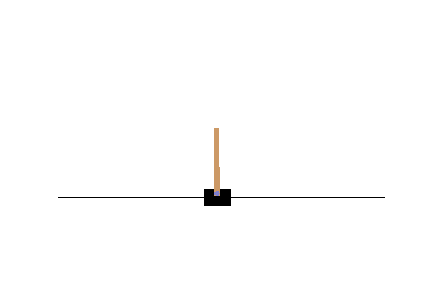
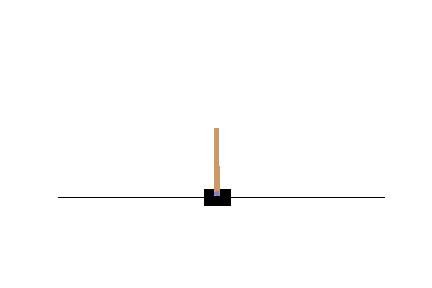
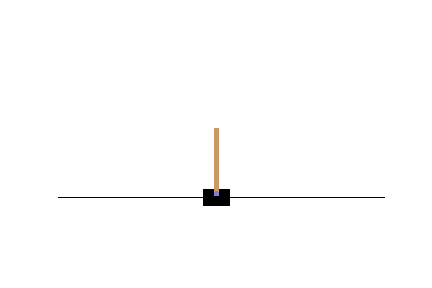
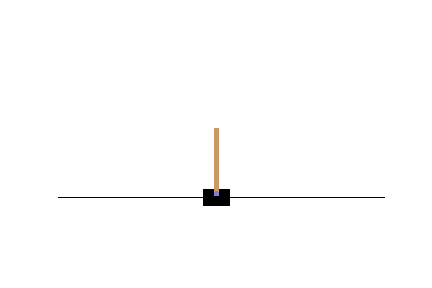
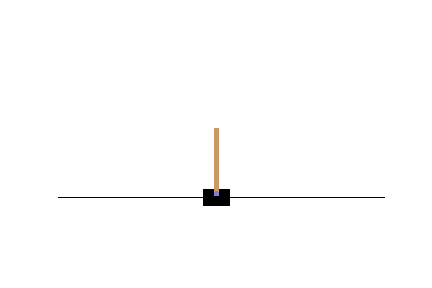
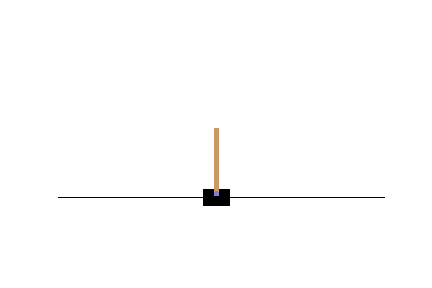
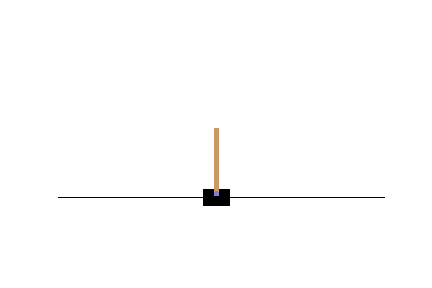
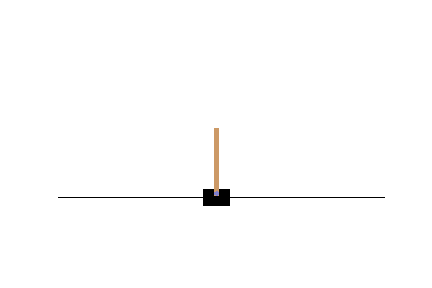
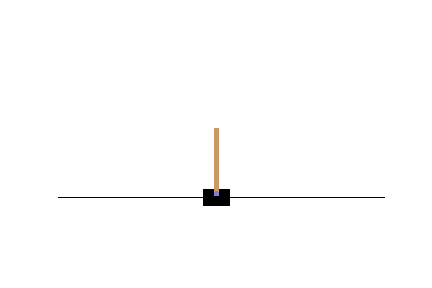
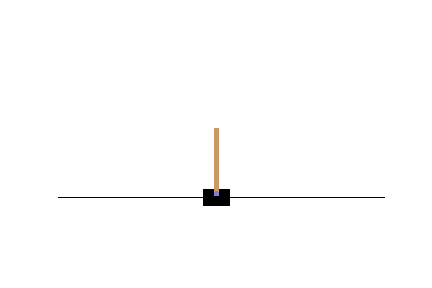
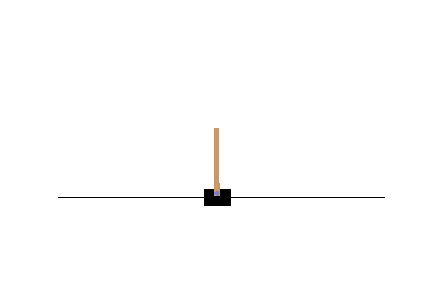
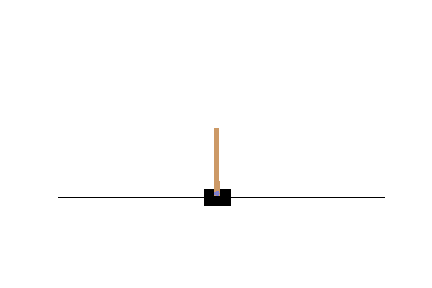
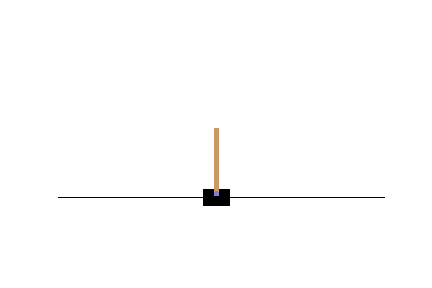
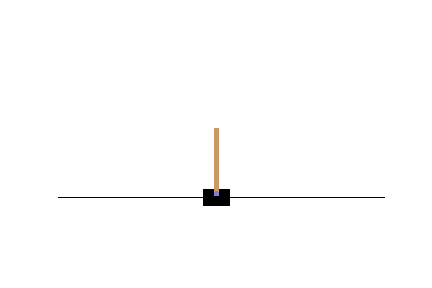
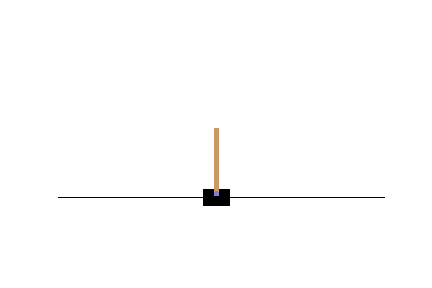
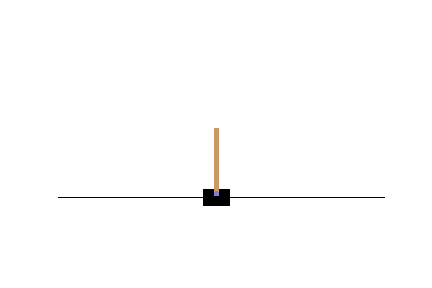
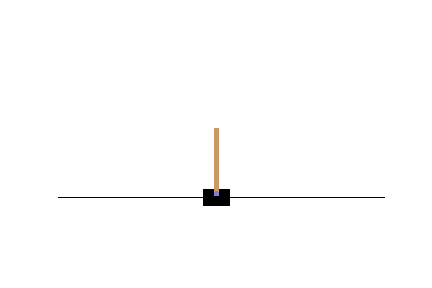
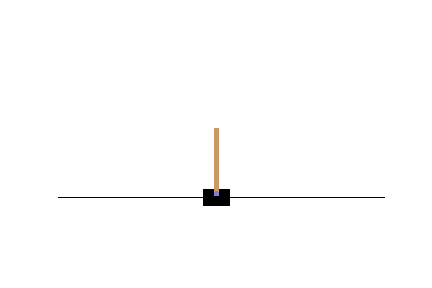
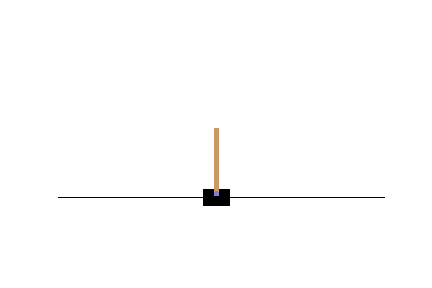
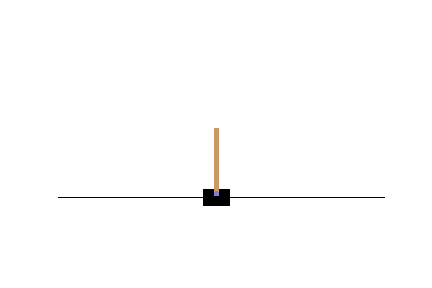
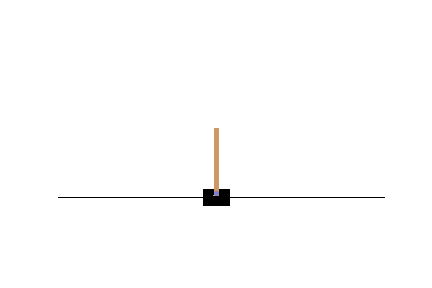
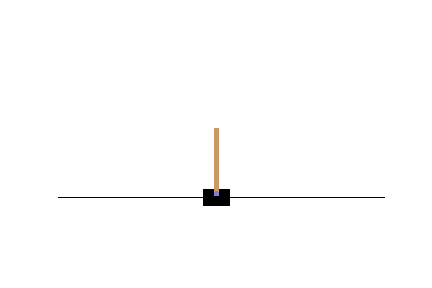
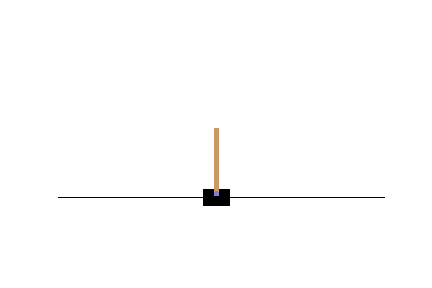
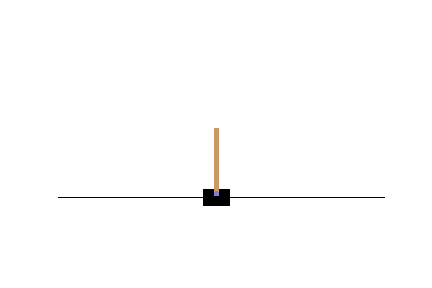
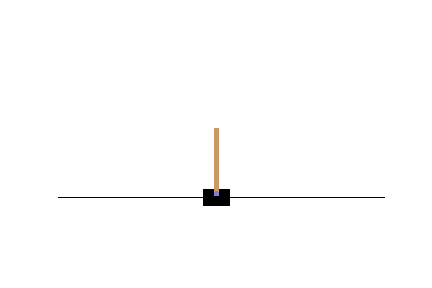
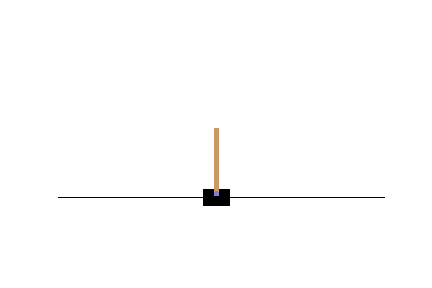
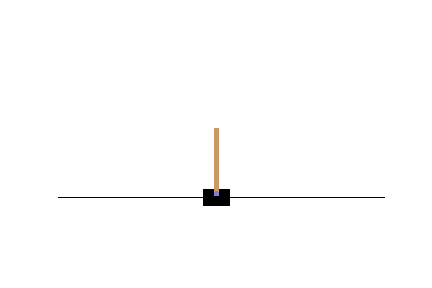
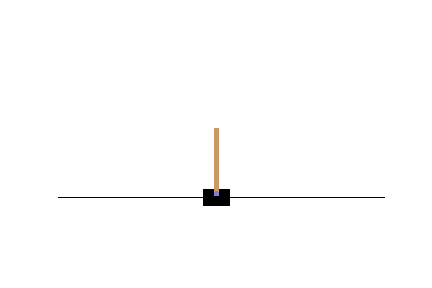
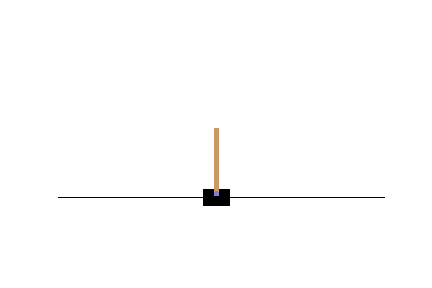
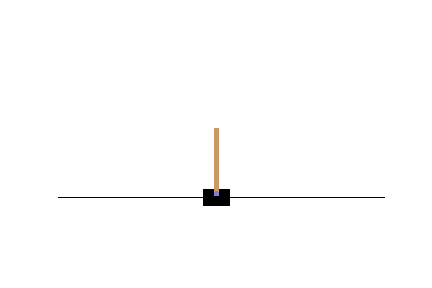
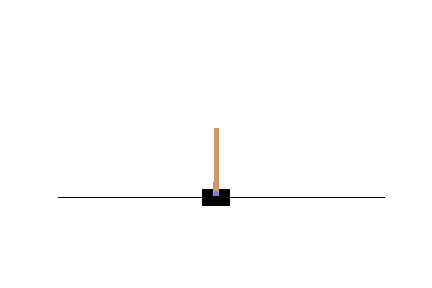
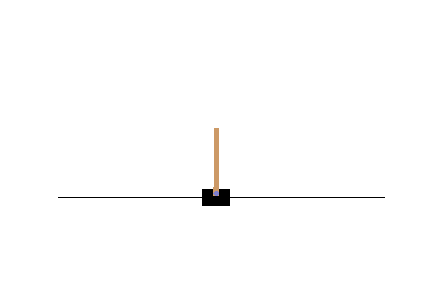
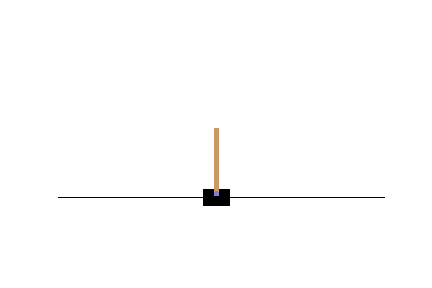
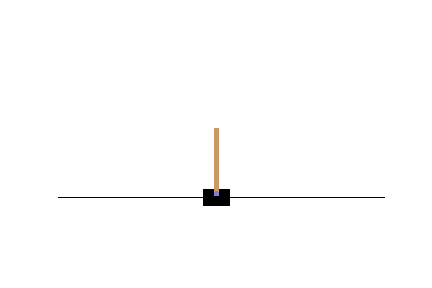
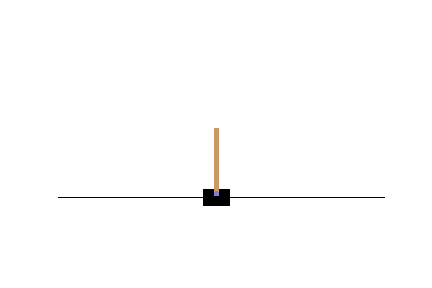
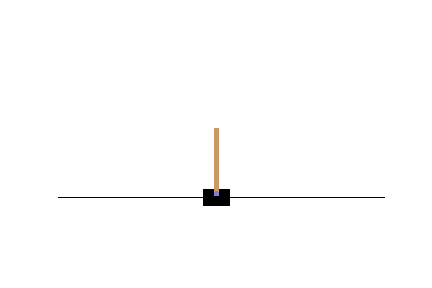
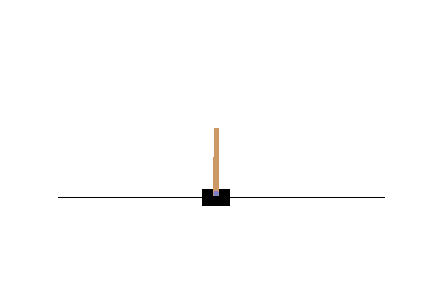
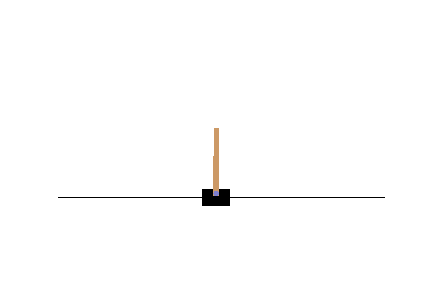
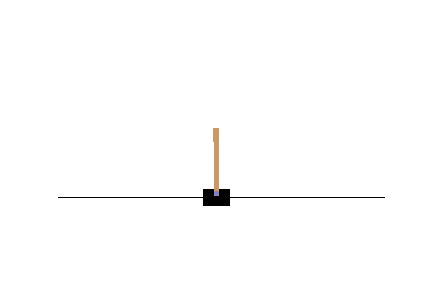
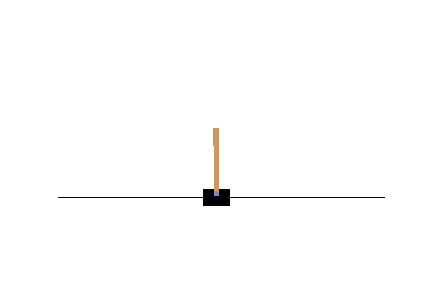
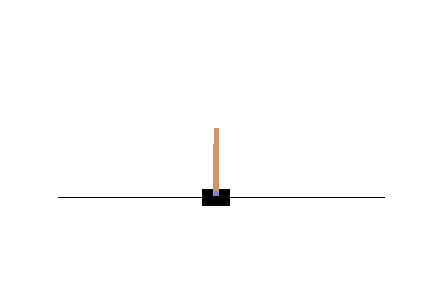
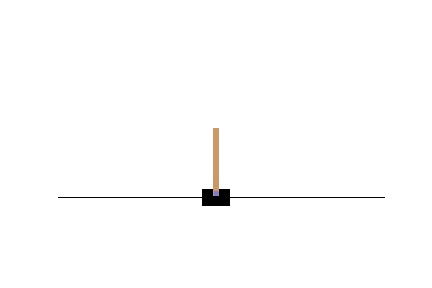
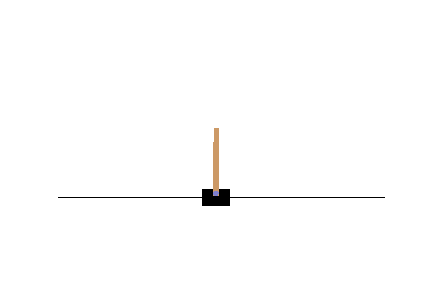
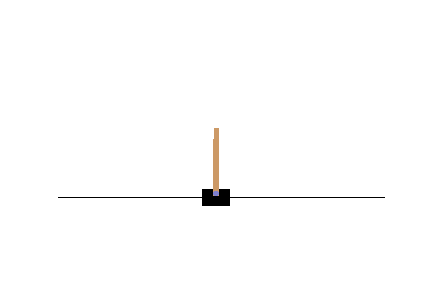
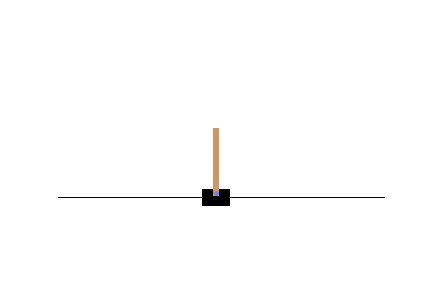
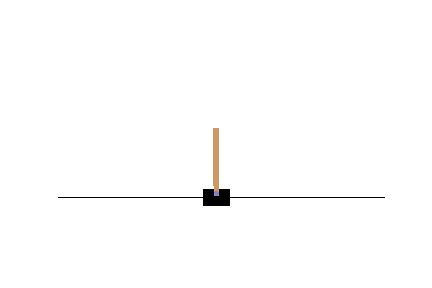
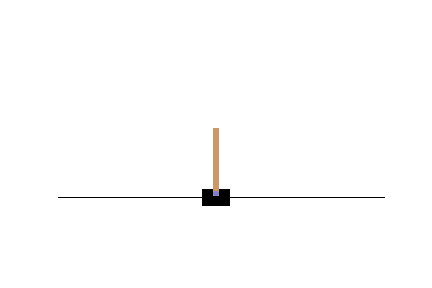
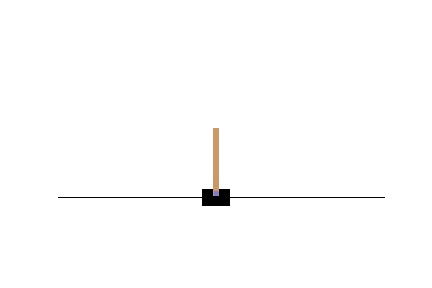
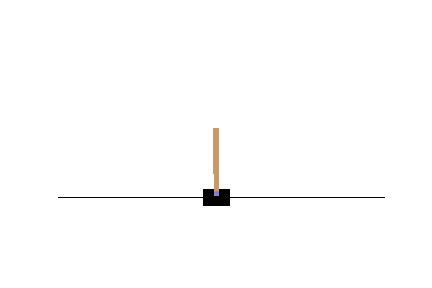
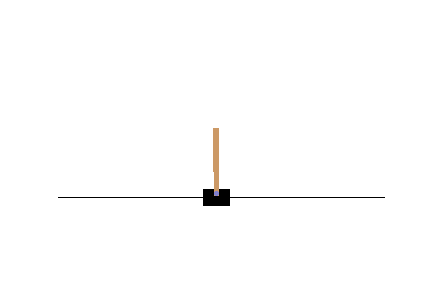
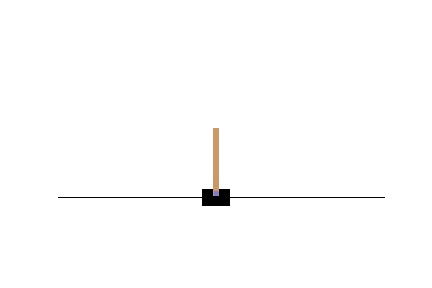
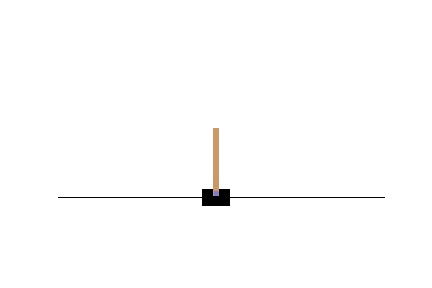
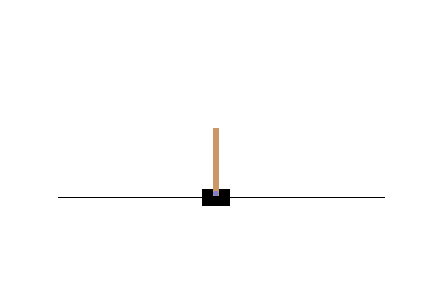
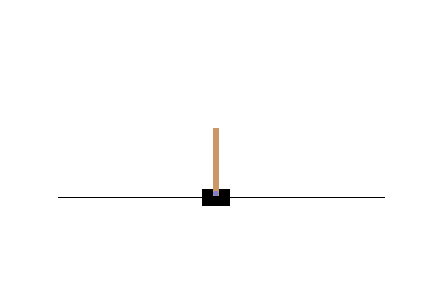
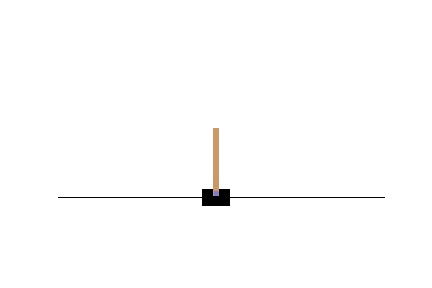
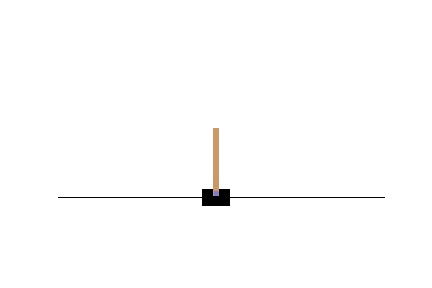
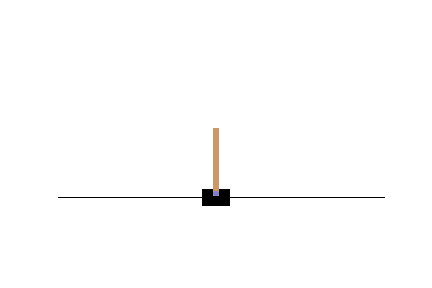
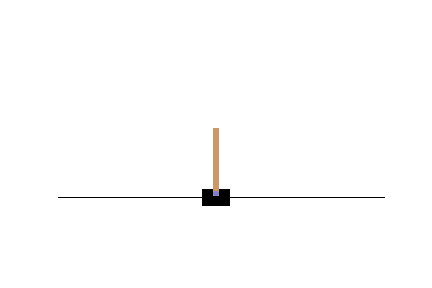
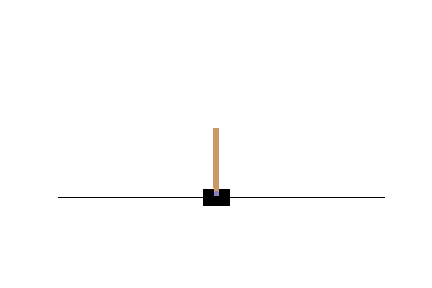
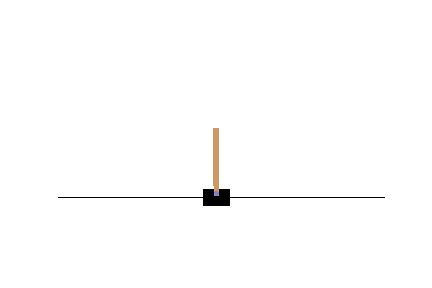
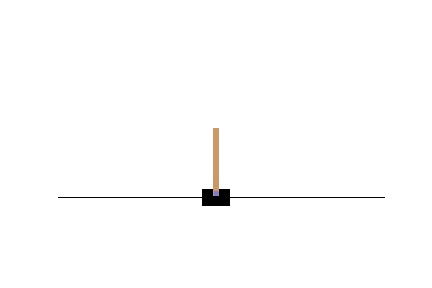
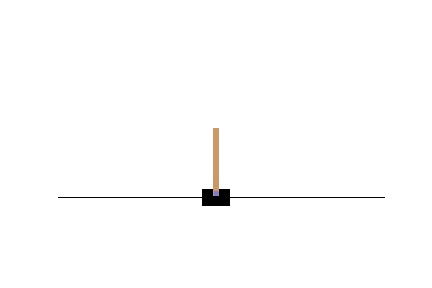
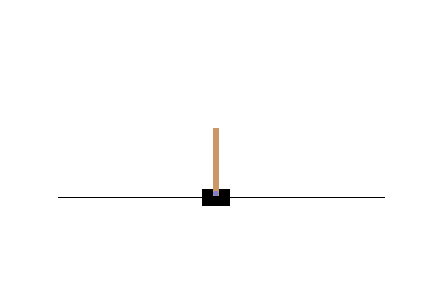
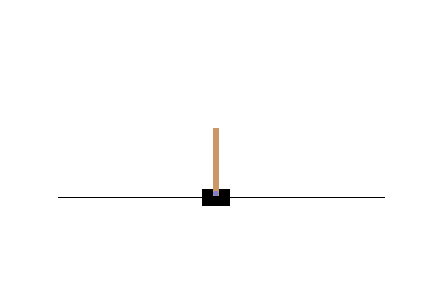
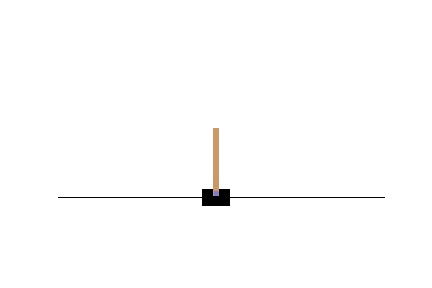
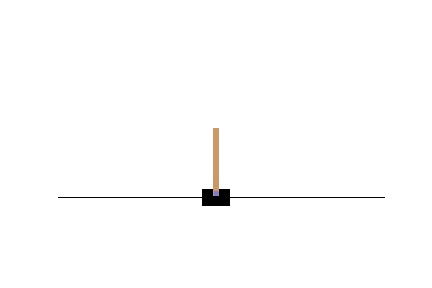
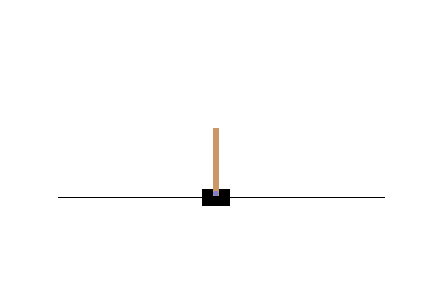
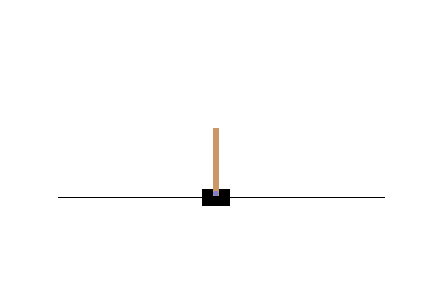
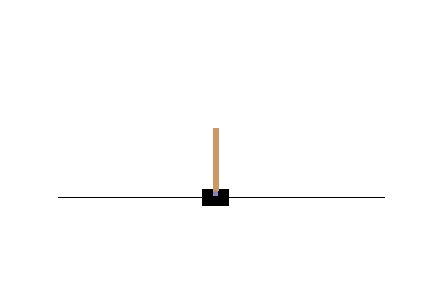
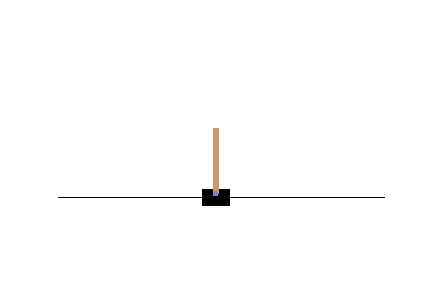
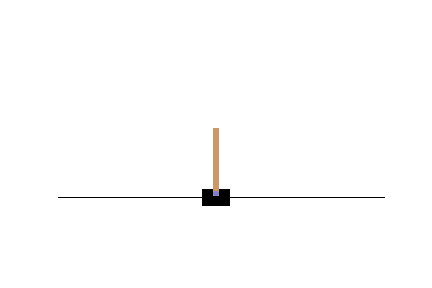
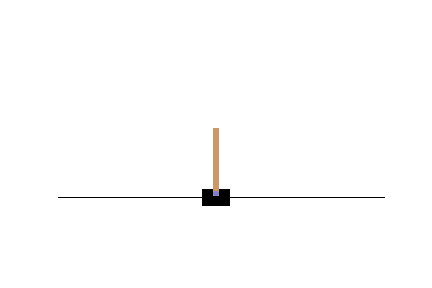
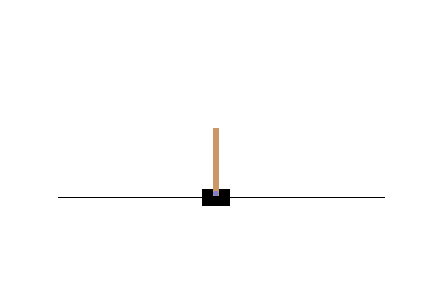
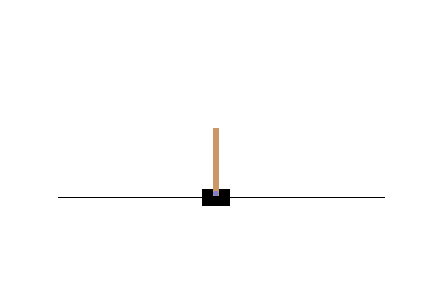
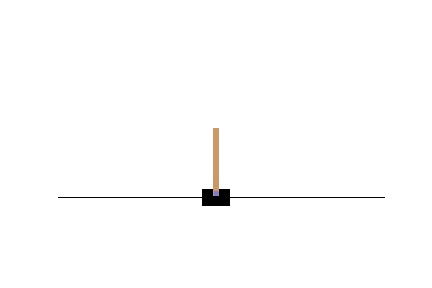
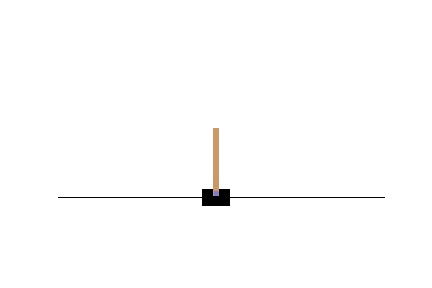
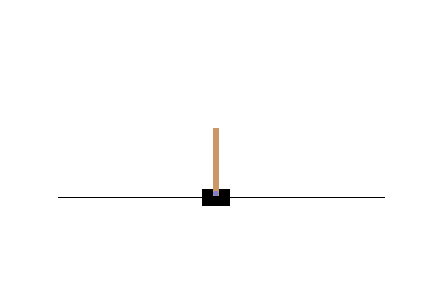
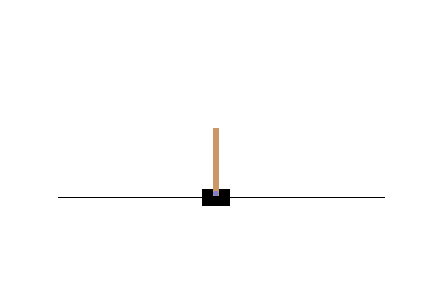
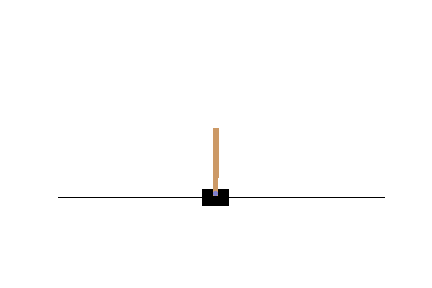
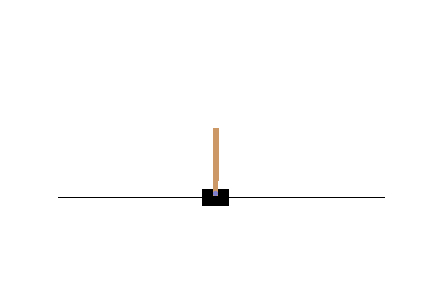
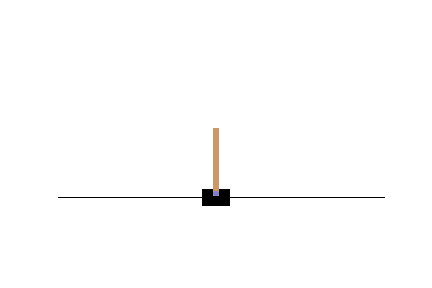
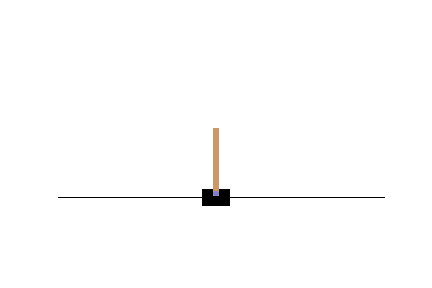
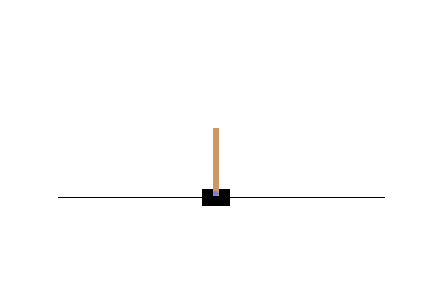
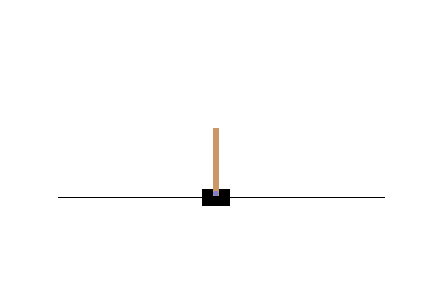
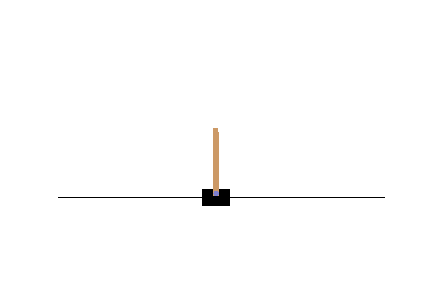
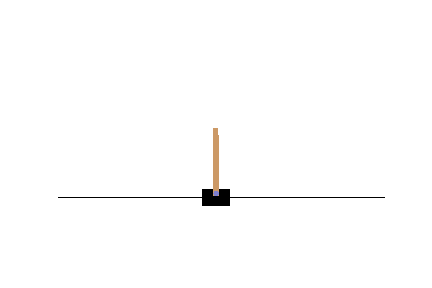
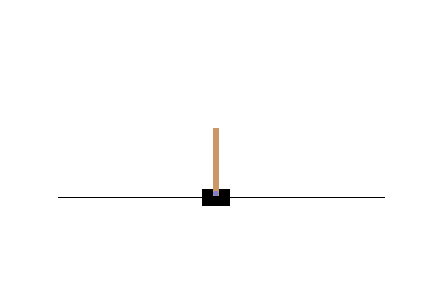
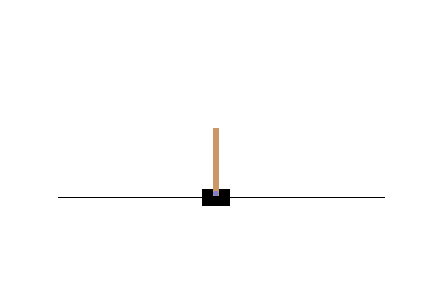
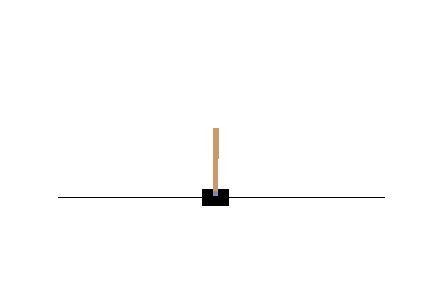
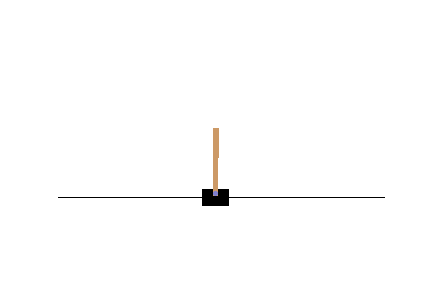
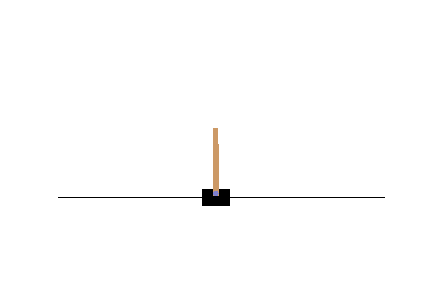
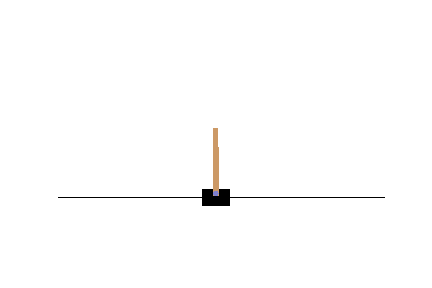

In [6]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = agent.control(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

# PPO Agent with Gaussian policy and Value Network

In [9]:
class PPOAgent_gaussian(object):
    def __init__(self, obs_dim, act_dim, clip_range=0.2, epochs=10, policy_lr=3e-4, value_lr=7e-4, hdim=64, max_std=1.0, seed=0):
        
        self.seed=seed
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.clip_range = clip_range
        
        self.epochs = epochs
        self.policy_lr = policy_lr
        self.value_lr = value_lr
        self.hdim = hdim
        self.max_std = max_std
        
        self._build_graph()
        self._init_session()
        
    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._value_nn()
            self._logprob()
            self._loss_train_op()
            self._kl_entropy()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, act_dim), 'act')
        self.adv_ph = tf.placeholder(tf.float32, (None,), 'adv')
        self.ret_ph = tf.placeholder(tf.float32, (None,), 'ret')

        # learning rate:
        self.policy_lr_ph = tf.placeholder(tf.float32, (), 'policy_lr')
        self.value_lr_ph = tf.placeholder(tf.float32, (), 'value_lr')
        
        # place holder for old parameters
        self.old_std_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_std')
        self.old_mean_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_means')
        
    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        with tf.variable_scope("policy"):
            # TWO HIDDEN LAYERS
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")

            # MEAN FUNCTION
            self.mean = tf.layers.dense(out, self.act_dim,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="mean")
            # UNI-VARIATE
            self.logits_std = tf.get_variable("logits_std",shape=(1,),initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed))
            self.std = self.max_std*tf.ones_like(self.mean)*tf.sigmoid(self.logits_std) # IMPORTANT TRICK

            # SAMPLE OPERATION
            self.sample_action = self.mean + tf.random_normal(tf.shape(self.mean),seed=self.seed)*self.std
    
    def _value_nn(self):
        hid1_size = self.hdim 
        hid2_size = self.hdim
        with tf.variable_scope("value"):
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h2")
            value = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name='output')
            self.value = tf.squeeze(value)
            
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER
        y = self.act_ph 
        mu = self.mean
        sigma = self.std
        
        self.logp = tf.reduce_sum(-0.5*tf.square((y-mu)/sigma)-tf.log(sigma)- 0.5*np.log(2.*np.pi),axis=1)

        # PROBABILITY WITH OLD (PREVIOUS) PARAMETER
        old_mu_ph = self.old_mean_ph
        old_sigma_ph = self.old_std_ph
                
        self.logp_old = tf.reduce_sum(-0.5*tf.square((y-old_mu_ph)/old_sigma_ph)-tf.log(old_sigma_ph)- 0.5*np.log(2.*np.pi),axis=1)
        
    def _kl_entropy(self):

        mean, std = self.mean, self.std
        old_mean, old_std = self.old_mean_ph, self.old_std_ph
 
        log_std_old = tf.log(old_std)
        log_std_new = tf.log(std)
        frac_std_old_new = old_std/std

        # KL DIVERGENCE BETWEEN TWO GAUSSIAN
        kl = tf.reduce_sum(log_std_new - log_std_old + 0.5*tf.square(frac_std_old_new) + 0.5*tf.square((mean - old_mean)/std)- 0.5,axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF GAUSSIAN
        entropy = tf.reduce_sum(log_std_new + 0.5 + 0.5*np.log(2*np.pi),axis=1)
        self.entropy = tf.reduce_mean(entropy)
            
    def _loss_train_op(self):
        
        # REINFORCE OBJECTIVE
        ratio = tf.exp(self.logp - self.logp_old)
        cliped_ratio = tf.clip_by_value(ratio,clip_value_min=1-self.clip_range,clip_value_max=1+self.clip_range)
        self.policy_loss = -tf.reduce_mean(tf.minimum(self.adv_ph*ratio,self.adv_ph*cliped_ratio))
        
        # POLICY OPTIMIZER
        self.pol_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="policy")
        optimizer = tf.train.AdamOptimizer(self.policy_lr_ph)
        self.train_policy = optimizer.minimize(self.policy_loss,var_list=self.pol_var_list)
            
        # L2 LOSS
        self.value_loss = tf.reduce_mean(0.5*tf.square(self.value - self.ret_ph))
            
        # VALUE OPTIMIZER 
        self.val_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="value")
        optimizer = tf.train.AdamOptimizer(self.value_lr_ph)
        self.train_value = optimizer.minimize(self.value_loss,var_list=self.val_var_list)
        
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
    
    def get_value(self, obs):
        feed_dict = {self.obs_ph: obs}
        value = self.sess.run(self.value, feed_dict=feed_dict)
        return value
    
    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action[0]
    
    def control(self, obs): # COMPUTE MEAN
        feed_dict = {self.obs_ph: obs}
        best_action = self.sess.run(self.mean,feed_dict=feed_dict)
        return best_action    
    
    def update(self, observes, actions, advantages, returns, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        old_means_np, old_std_np = self.sess.run([self.mean, self.std],{self.obs_ph: observes}) # COMPUTE OLD PARAMTER
        for e in range(self.epochs):
            observes, actions, advantages, returns, old_means_np, old_std_np = shuffle(observes, actions, advantages, returns, old_means_np, old_std_np, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end],
                     self.adv_ph: advantages[start:end],
                     self.ret_ph: returns[start:end],
                     self.old_std_ph: old_std_np[start:end,:],
                     self.old_mean_ph: old_means_np[start:end,:],
                     self.policy_lr_ph: self.policy_lr,
                     self.value_lr_ph: self.value_lr}        
                self.sess.run([self.train_policy,self.train_value], feed_dict)
            
        feed_dict = {self.obs_ph: observes,
             self.act_ph: actions,
             self.adv_ph: advantages,
             self.ret_ph: returns,
             self.old_std_ph: old_std_np,
             self.old_mean_ph: old_means_np,
             self.policy_lr_ph: self.policy_lr,
             self.value_lr_ph: self.value_lr}               
        policy_loss, value_loss, kl, entropy  = self.sess.run([self.policy_loss, self.value_loss, self.kl, self.entropy], feed_dict)
        return policy_loss, value_loss, kl, entropy
    
    def close_sess(self):
        self.sess.close()

# Training

In [10]:
env = gym.make('MountainCarContinuous-v0')

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed=seed)

obs_space = env.observation_space
act_space= env.action_space

obs_dim = obs_space.shape[0]
act_dim = act_space.shape[0]

agent = PPOAgent_gaussian(obs_dim, act_dim, epochs=10, hdim=64, policy_lr=1e-4, value_lr=1e-3, max_std=2.0,
                          clip_range=0.2, seed=seed)

avg_return_list = deque(maxlen=10)
avg_pol_loss_list = deque(maxlen=10)
avg_val_loss_list = deque(maxlen=10)

episode_size = 10
batch_size = 64
nupdates = 300

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episode_size)
    add_value(trajectories, agent)
    add_gae(trajectories)
    add_rets(trajectories)
    observes, actions, advantages, returns = build_train_set(trajectories)

    pol_loss, val_loss, kl, entropy = agent.update(observes, actions, advantages, returns, batch_size=batch_size)

    avg_pol_loss_list.append(pol_loss)
    avg_val_loss_list.append(val_loss)
    
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%10) == 0:
        print('[{}/{}] return : {:.3f}, value loss : {:.3f}, policy loss : {:.3f}, policy kl : {:.5f}, policy entropy : {:.3f}'.format(
            update, nupdates, np.mean(avg_return_list), np.mean(avg_val_loss_list), np.mean(avg_pol_loss_list), kl, entropy))
        
    if (np.mean(avg_return_list) > 90): # Threshold return to success cartpole
        print('[{}/{}] return : {:.3f}, value loss : {:.3f}, policy loss : {:.3f}'.format(update,nupdates, np.mean(avg_return_list), np.mean(avg_val_loss_list), np.mean(avg_pol_loss_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/300] return : -100.291, value loss : 2.370, policy loss : -0.012, policy kl : 0.00314, policy entropy : 1.362
[10/300] return : -55.364, value loss : 30.251, policy loss : -0.003, policy kl : 0.00138, policy entropy : 1.108
[20/300] return : 35.142, value loss : 208.346, policy loss : -0.003, policy kl : 0.00125, policy entropy : 0.972
[30/300] return : 73.645, value loss : 312.759, policy loss : -0.002, policy kl : 0.00142, policy entropy : 0.909
[40/300] return : 78.645, value loss : 306.805, policy loss : -0.002, policy kl : 0.00142, policy entropy : 0.849
[50/300] return : 78.899, value loss : 296.658, policy loss : -0.002, policy kl : 0.00031, policy entropy : 0.800
[60/300] return : 83.504, value loss : 283.526, policy loss : -0.002, policy kl : 0.00083, policy entropy : 0.754
[70/3

# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 90.69



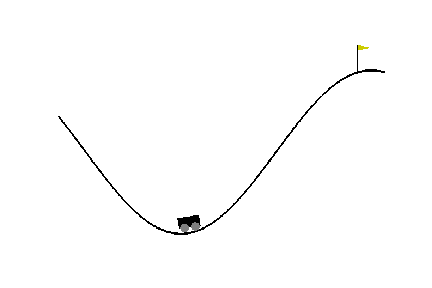
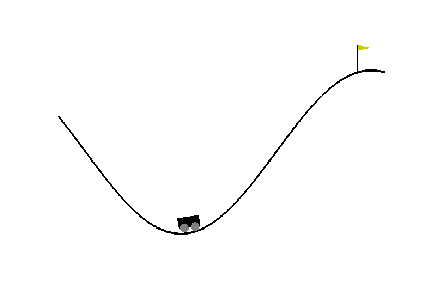
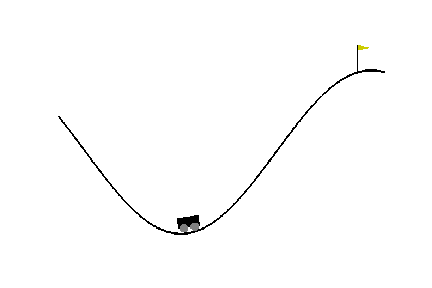
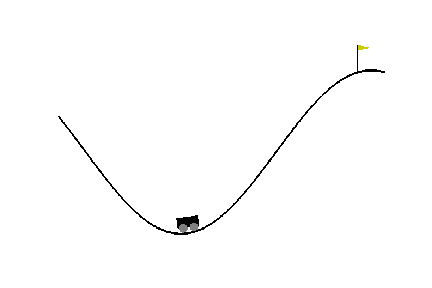
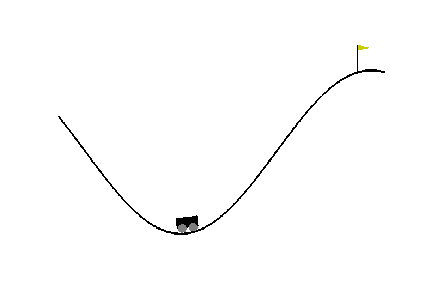
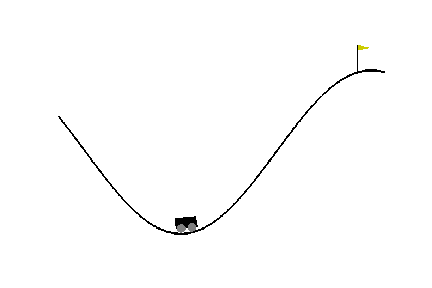
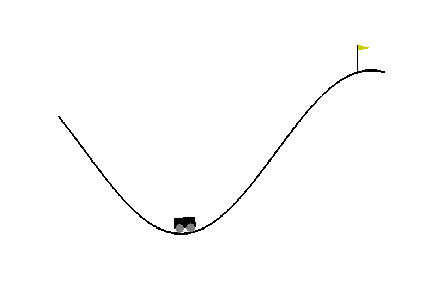
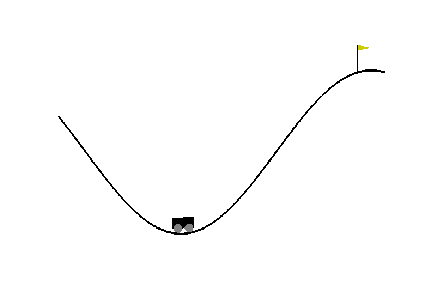
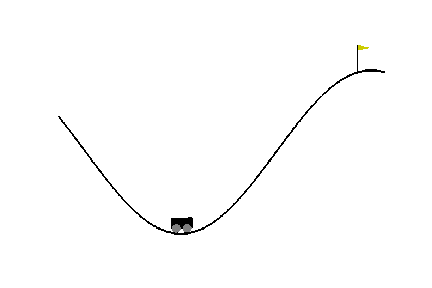
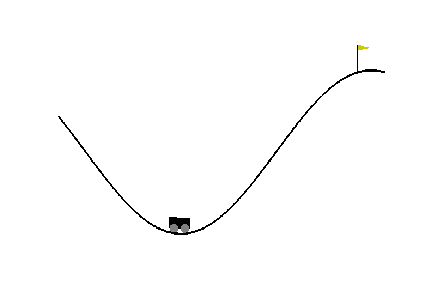
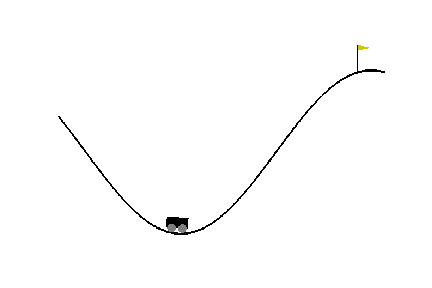
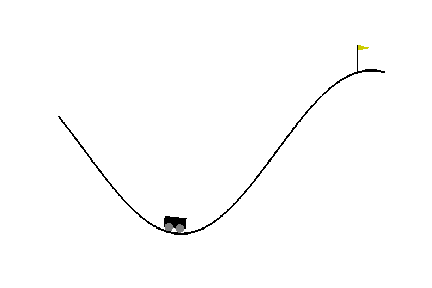
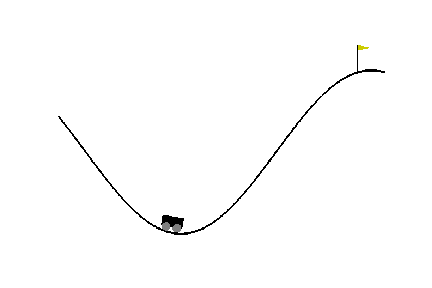
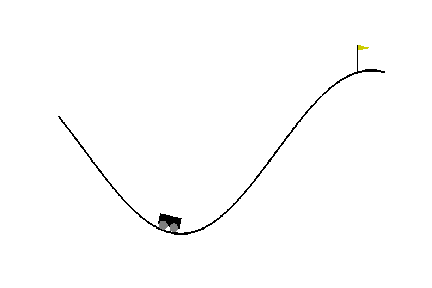
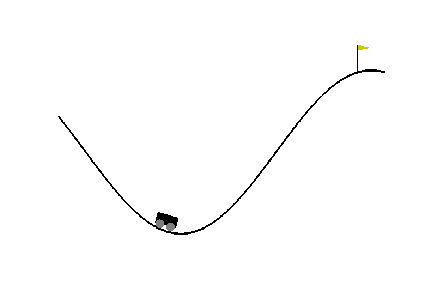
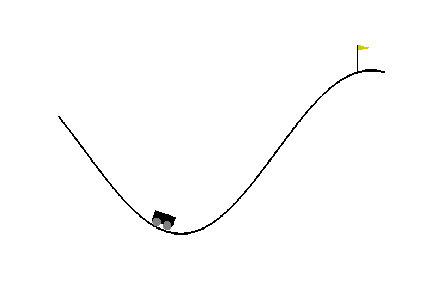
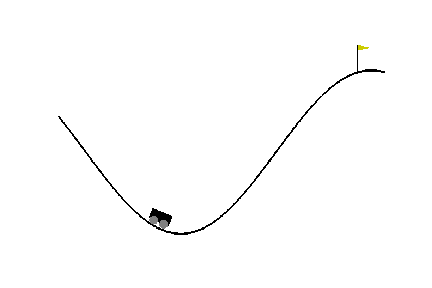
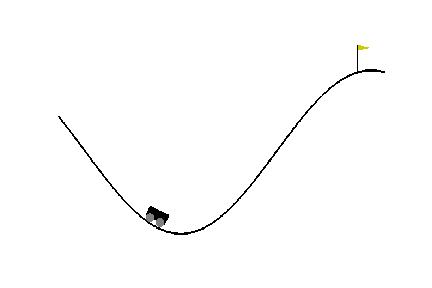
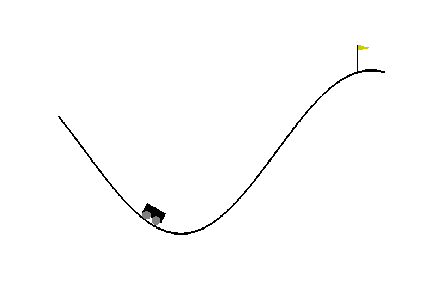
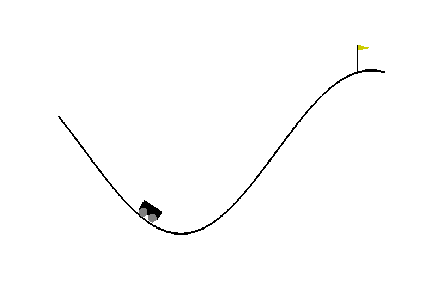
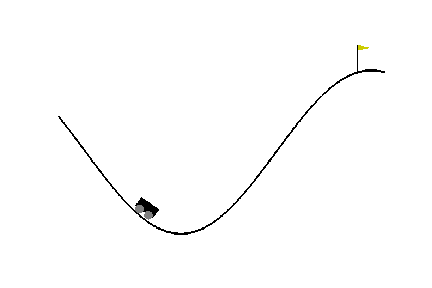
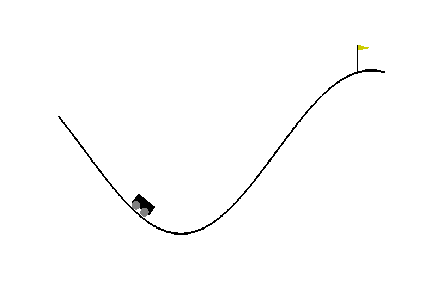
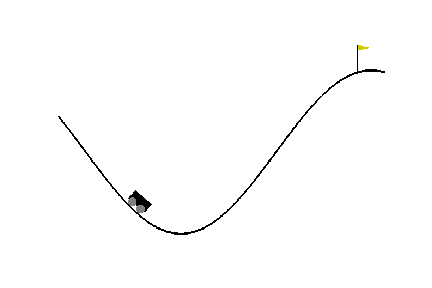
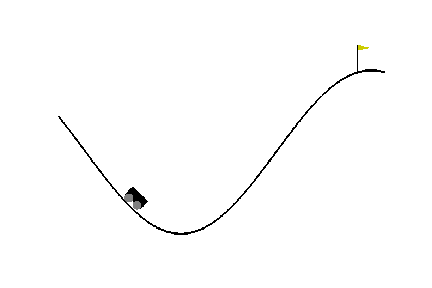
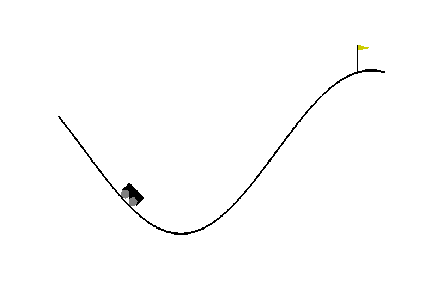
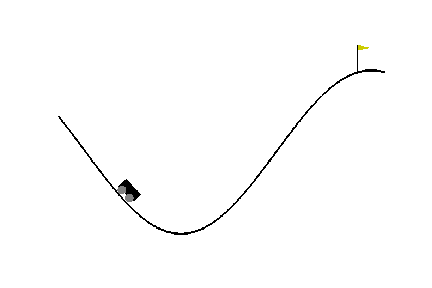
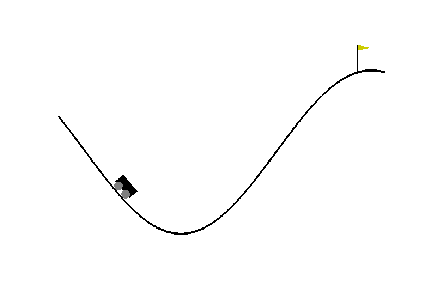
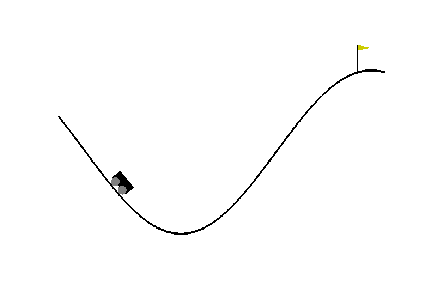
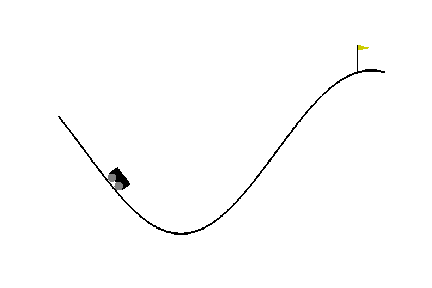
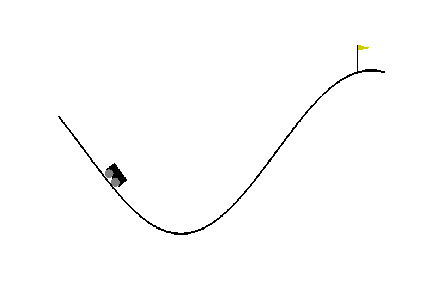
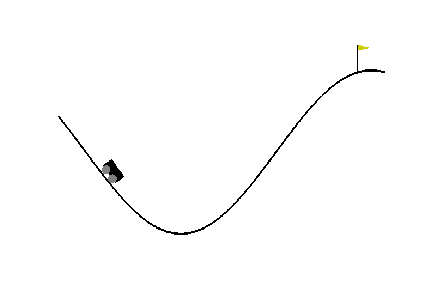
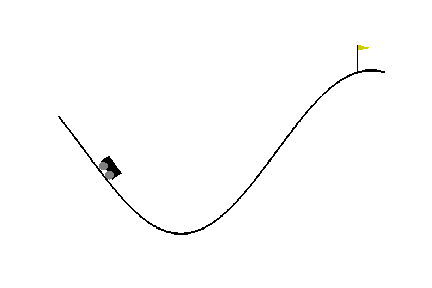
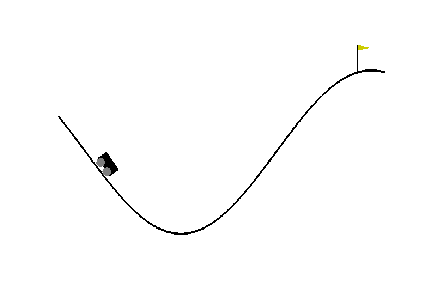
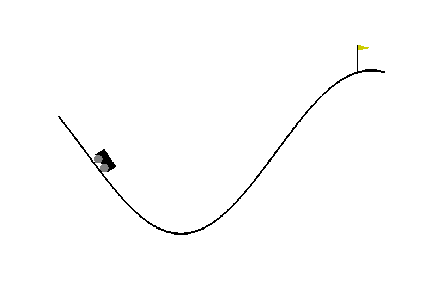
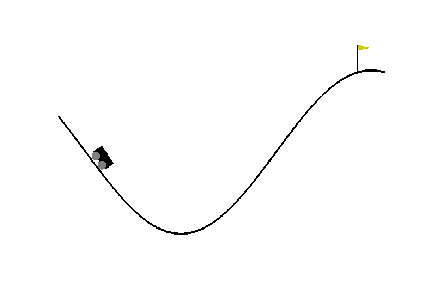
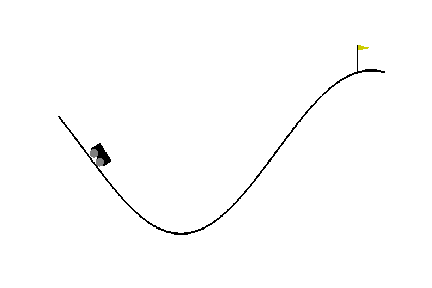
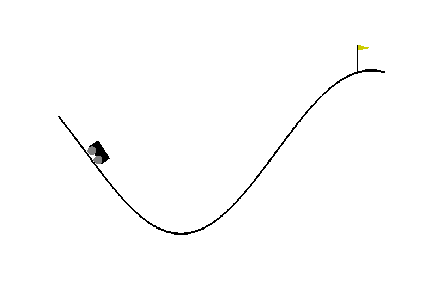
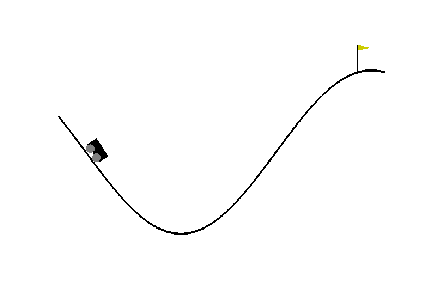
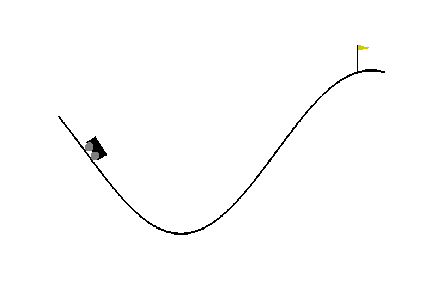
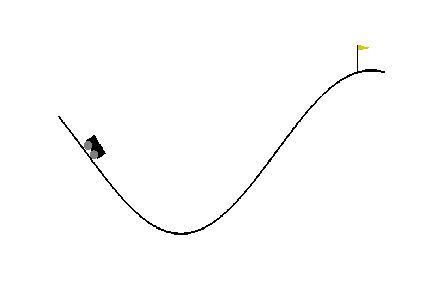
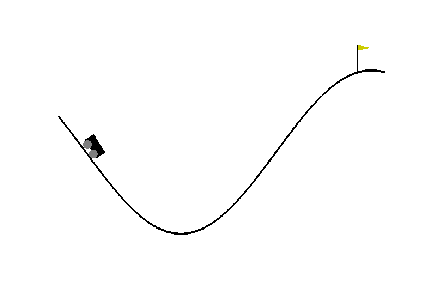
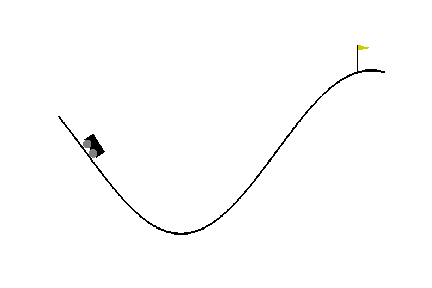
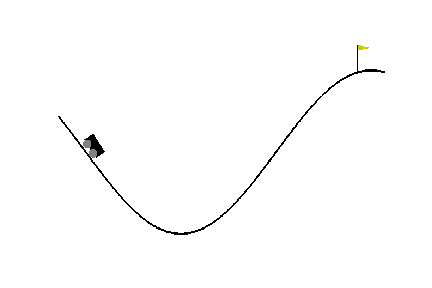
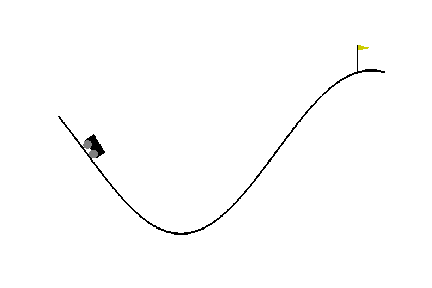
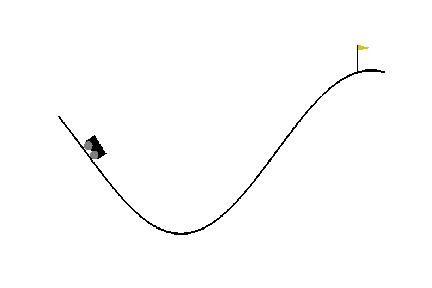
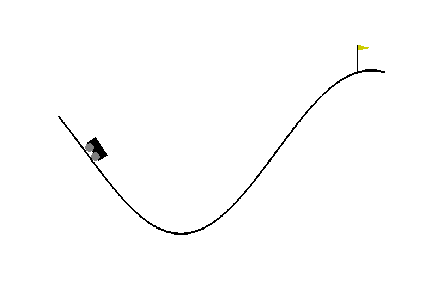
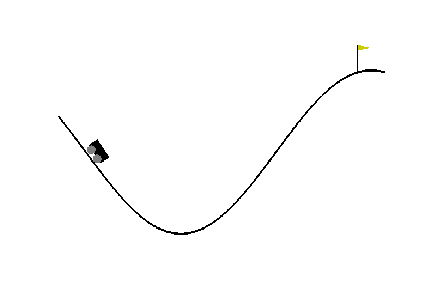
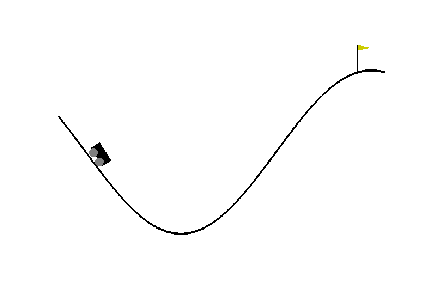
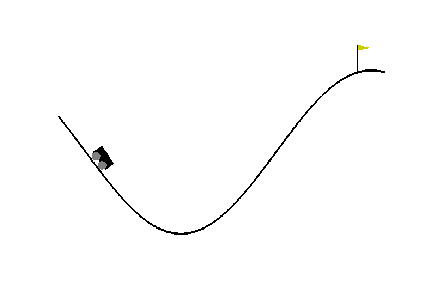
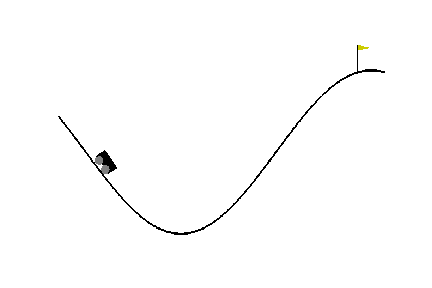
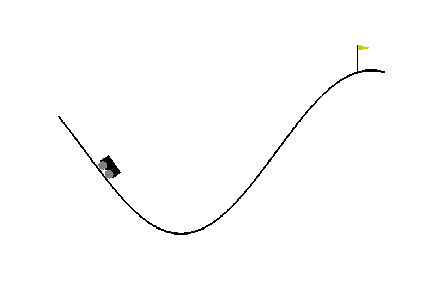
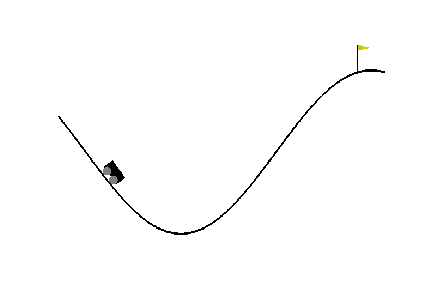
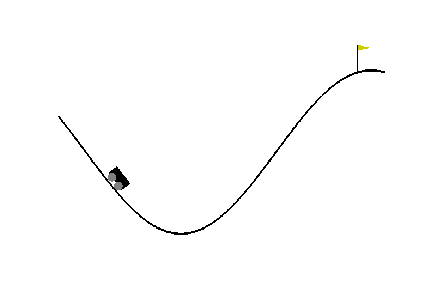
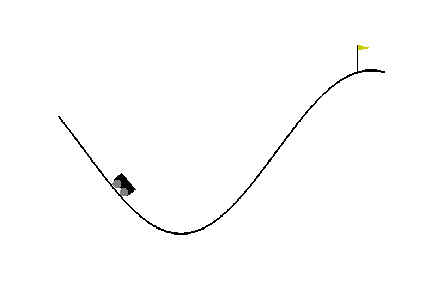
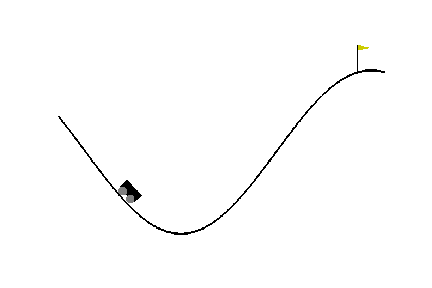
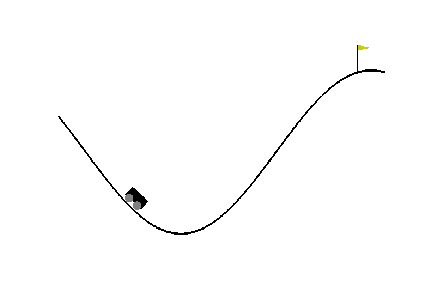
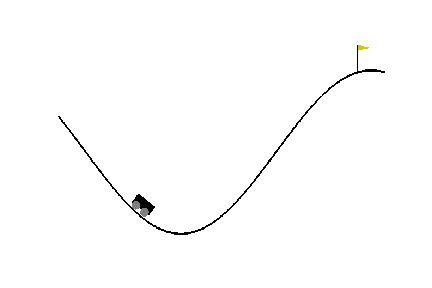
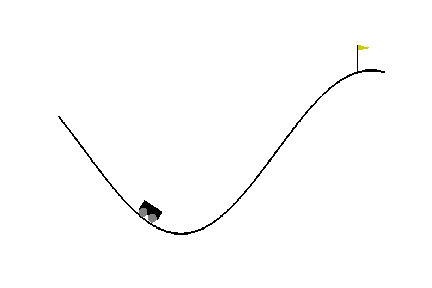
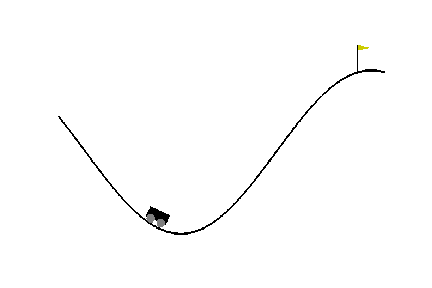
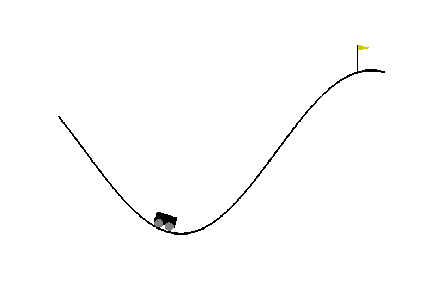
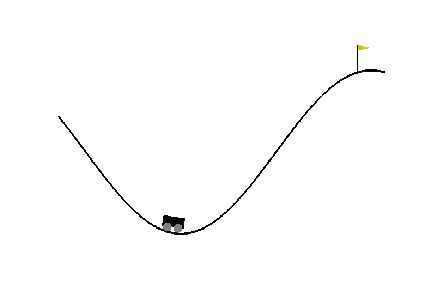
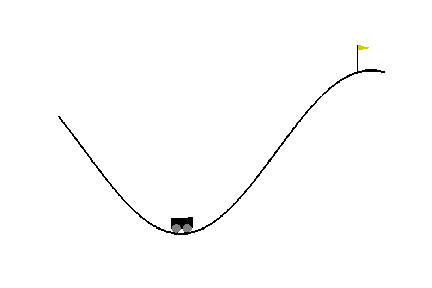
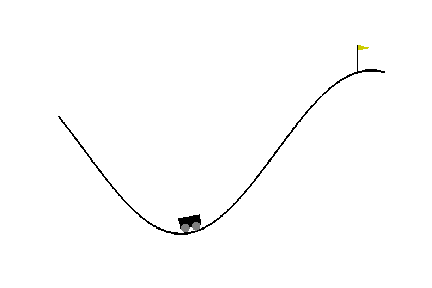
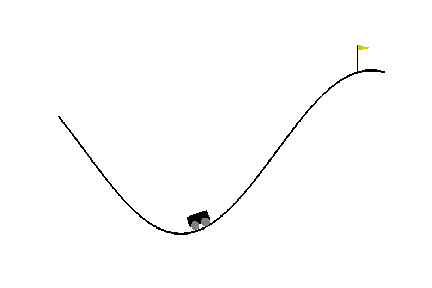
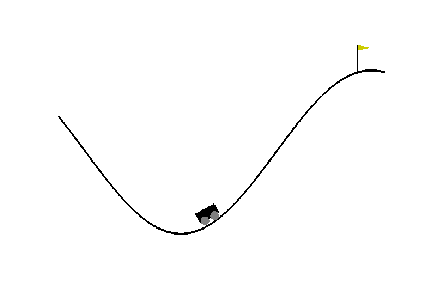
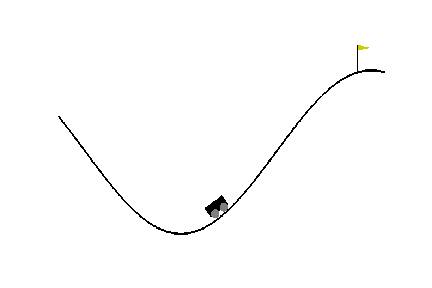
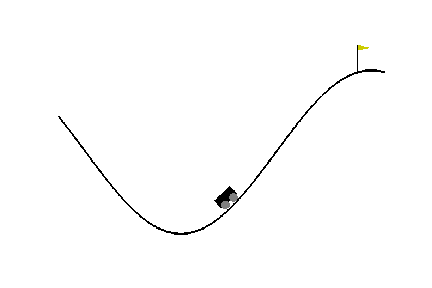
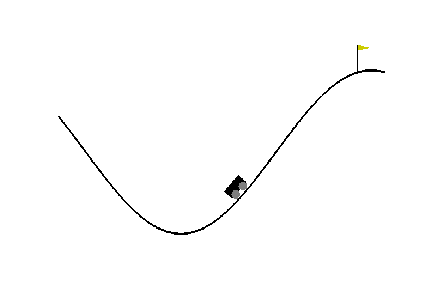
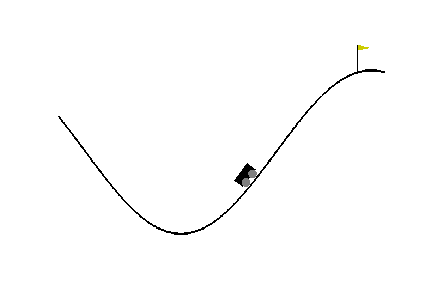
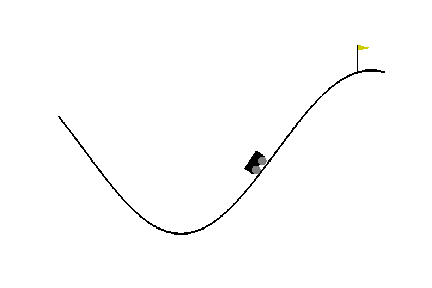
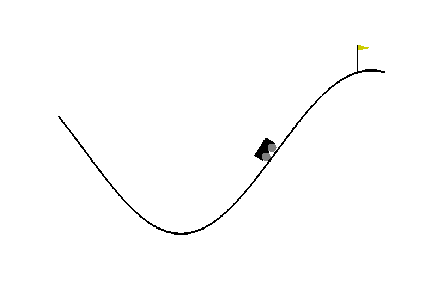
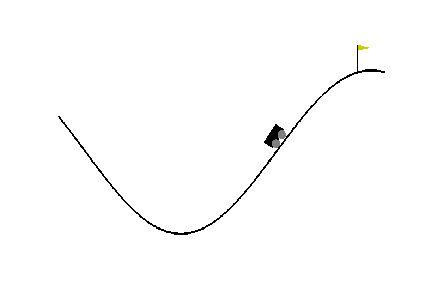
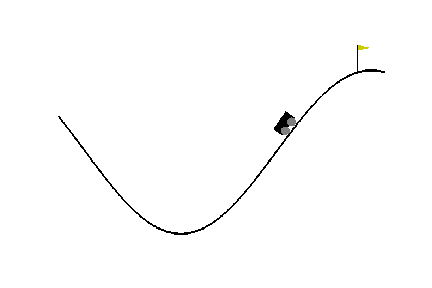
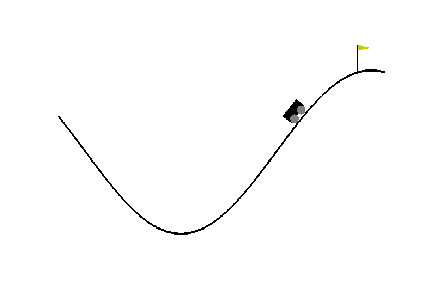
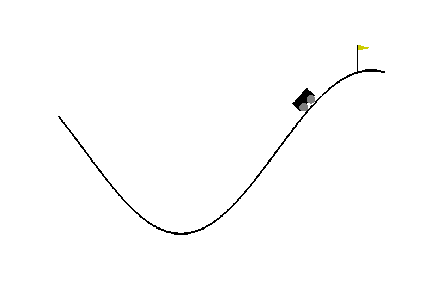
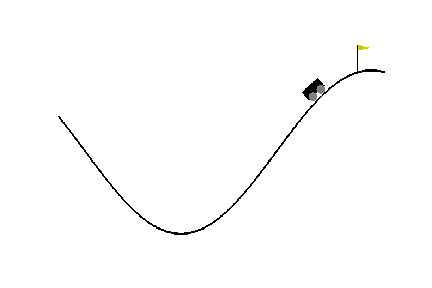
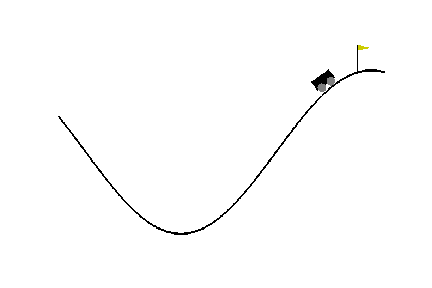
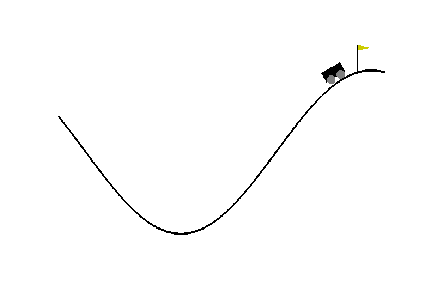
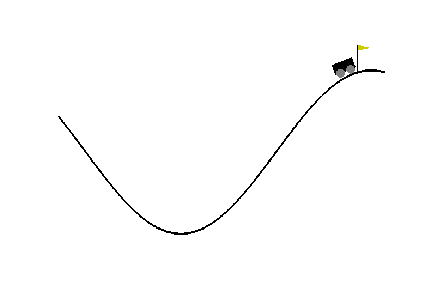
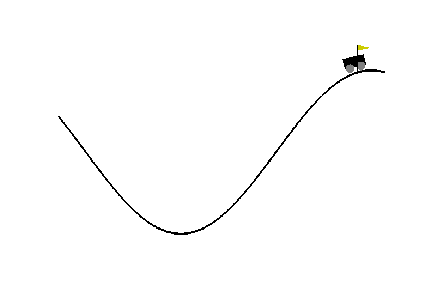

In [11]:
env = gym.make('MountainCarContinuous-v0')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = agent.control(obs).reshape((1, -1)).astype(np.float32)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

# Conjugate Gradient for TRPO

In [12]:
def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10): # solve Ax = b
    '''
        cg_iters : the number of iteration
        residual_tol : accuracy of solution
    '''
    p = b.copy()
    r = b.copy()
    x = np.zeros_like(b)
    rdotr = r.dot(r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / p.dot(z)
        x += v * p
        r -= v * z
        newrdotr = r.dot(r)
        mu = newrdotr / rdotr
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

# TRPO Agent with Gaussian policy and Value Network

In [13]:
class TRPOAgent_gaussian(object):
    def __init__(self, obs_dim, act_dim, value_lr=1e-3,
                 hdim=64, max_std=5.0,
                 cg_damping=1e-3, max_kl=0.01,
                 seed=0):
        
        self.seed=seed
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim

        self.value_lr = value_lr
        self.hdim = hdim
        self.max_std = max_std
        
        self.cg_damping = cg_damping
        self.max_kl = max_kl
        
        self._build_graph()
        
    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._value_nn()
            self._logprob()
            self._loss()
            self._kl_entropy()
            self._trpo_optimizer()
            
            self.init = tf.global_variables_initializer()
            self._init_session()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        self.adv_ph = tf.placeholder(tf.float32, (None,), 'adv')
        self.ret_ph = tf.placeholder(tf.float32, (None,), 'ret')

        # learning rate:
        self.value_lr_ph = tf.placeholder(tf.float32, (), 'value_lr')
        
        # place holder for old parameters
        self.old_std_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_std')
        self.old_mean_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_means')
        
    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        with tf.variable_scope("policy"):
            # TWO HIDDEN LAYERS
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="h2")

            # MEAN FUNCTION
            self.mean = tf.layers.dense(out, self.act_dim,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01), 
                                    name="mean")
            # UNI-VARIATE
            self.logits_std = tf.get_variable("logits_std",shape=(1,),initializer=tf.random_normal_initializer(stddev=0.01))
            self.std = self.max_std*tf.ones_like(self.mean)*tf.sigmoid(self.logits_std) # IMPORTANT TRICK

            # SAMPLE OPERATION
            self.sample_action = self.mean + tf.random_normal(tf.shape(self.mean),seed=self.seed)*self.std
            
    def _value_nn(self):
        hid1_size = self.hdim 
        hid2_size = self.hdim
        with tf.variable_scope("value"):
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01), name="h1")
            value = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01), name='output')
            self.value = tf.squeeze(value)
            
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER
        y = self.act_ph 
        mu = self.mean
        sigma = self.std
        
        self.logp = tf.reduce_sum(-0.5*tf.square((y-mu)/sigma)-tf.log(sigma)- 0.5*np.log(2.*np.pi),axis=1)

        # PROBABILITY WITH OLD (PREVIOUS) PARAMETER
        old_mu_ph = self.old_mean_ph
        old_sigma_ph = self.old_std_ph
                
        self.logp_old = tf.reduce_sum(-0.5*tf.square((y-old_mu_ph)/old_sigma_ph)-tf.log(old_sigma_ph)- 0.5*np.log(2.*np.pi),axis=1)
    def _loss(self):
        
        # Proximal Policy Optimization CLIPPED LOSS FUNCTION
        ratio = tf.exp(self.logp - self.logp_old) 
        self.policy_loss = -tf.reduce_mean(self.adv_ph*ratio)
                    
        # L2 LOSS
        self.value_loss = tf.reduce_mean(0.5*tf.square(self.value - self.ret_ph))
            
        # VALUE OPTIMIZER 
        self.val_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="value")
        optimizer = tf.train.AdamOptimizer(self.value_lr_ph)
        self.train_value = optimizer.minimize(self.value_loss,var_list=self.val_var_list)
        
    def _kl_entropy(self):

        mean, std = self.mean, self.std
        old_mean, old_std = self.old_mean_ph, self.old_std_ph
 
        log_std_old = tf.log(old_std)
        log_std_new = tf.log(std)
        frac_std_old_new = old_std/std

        # KL DIVERGENCE BETWEEN TWO GAUSSIAN
        kl = tf.reduce_sum(log_std_new - log_std_old + 0.5*tf.square(frac_std_old_new) + 0.5*tf.square((mean - old_mean)/std)- 0.5,axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF GAUSSIAN
        entropy = tf.reduce_sum(log_std_new + 0.5 + 0.5*np.log(2*np.pi),axis=1)
        self.entropy = tf.reduce_mean(entropy)
         
    def _trpo_optimizer(self):
        # GRADIENT OF KL
        var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="policy")
        
        self.flat_var = tf.concat([tf.reshape(v, [np.prod(v.shape)]) for v in var_list], 0)
        
        pg_grads = tf.gradients(self.policy_loss, var_list)
        self.pg = tf.concat([tf.reshape(pg_grad, [np.prod(v.shape)]) for (v, pg_grad) in zip(var_list, pg_grads)], 0)
        
        grads = tf.gradients(self.kl, var_list)
        self.flat_tangent = tf.placeholder(tf.float32, shape=(None))
        shapes = [v.shape for v in var_list]
        start = 0
        tangents = []
        for shape in shapes:
            size = int(np.prod(shape))
            param = tf.reshape(self.flat_tangent[start:(start + size)], shape)
            tangents.append(param)
            start += size
        gvp = [tf.reduce_sum(g * t) for (g, t) in zip(grads, tangents)]
        
        gvp_grads = tf.gradients(gvp, var_list)
        self.fvp =  tf.concat([tf.reshape(gvp_grad, [np.prod(v.shape)]) for (v, gvp_grad) in zip(var_list, gvp_grads)], 0)
        
        assigns = []
        total_size = sum(int(np.prod(shape)) for shape in shapes)
        self.theta = tf.placeholder(tf.float32, shape=(total_size))
        start = 0
        for (shape, v) in zip(shapes, var_list):
            size = int(np.prod(shape))
            assigns.append(v.assign(tf.reshape(self.theta[start:start+size],shape)))
            start += size
        self.set_from_flat = assigns
        
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
        
    def get_value(self, obs):
        feed_dict = {self.obs_ph: obs}
        value = self.sess.run(self.value, feed_dict=feed_dict)
        return value
    
    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action, = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action
    
    def control(self, obs): # COMPUTE MEAN
        obs = obs.squeeze()
        feed_dict = {self.obs_ph: [obs]}
        best_action = self.sess.run(self.mean,feed_dict=feed_dict)
        return best_action        
    
    def update(self, observes, actions, advantages, returns, val_epochs=1, batch_size=batch_size): # TRAIN POLICY
        
        old_means_np, old_std_np = self.sess.run([self.mean, self.std],{self.obs_ph: observes}) # COMPUTE OLD PARAMTER
        observes, actions, advantages, returns, old_means_np, old_std_np = shuffle(observes, actions, advantages, returns, old_means_np, old_std_np, random_state=self.seed)
        
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.adv_ph: advantages,
                     self.old_mean_ph: old_means_np,
                     self.old_std_ph: old_std_np}          
        
        # TRAIN POLICY NETWORK USING TRPO
        thprev = self.sess.run(self.flat_var)

        def hessian_vector_product(p):
            feed_dict[self.flat_tangent] = p
            return self.sess.run(self.fvp, feed_dict) + p * self.cg_damping

        g = self.sess.run(self.pg, feed_dict=feed_dict)
        stepdir = conjugate_gradient(hessian_vector_product, -g)
        shs = (.5 * stepdir.dot(hessian_vector_product(stepdir)) )

        lm = np.sqrt(shs/ self.max_kl) 

        fullstep = stepdir / lm
        expectedimprove = g.dot(fullstep)
        surrbefore = self.sess.run(self.policy_loss, feed_dict=feed_dict)
        stepsize = 1.

        for _ in range(5):
            thnew = thprev + fullstep * stepsize
            self.sess.run(self.set_from_flat, feed_dict={self.theta:thnew})

            surr, kl = self.sess.run([self.policy_loss, self.kl], feed_dict=feed_dict)
            improve = surr - surrbefore

            if not np.isfinite(surr).all():
                self.sess.run(self.set_from_flat, feed_dict={self.theta:thprev})
                break
            elif kl > self.max_kl * 1.5:
                stepsize *= .5
            elif improve < 0:
                stepsize *= .5
            else:
                break
                
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        # TRAIN VALUE NETWORK
        for e in range(val_epochs):
            observes, actions, advantages, returns, old_means_np, old_std_np = shuffle(observes, actions, advantages, returns, old_means_np, old_std_np, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.ret_ph: returns[start:end],
                     self.value_lr_ph: self.value_lr}        
                self.sess.run([self.train_value], feed_dict)
        
        feed_dict = {self.obs_ph: observes,
             self.act_ph: actions,
             self.adv_ph: advantages,
             self.ret_ph: returns,
             self.old_std_ph: old_std_np,
             self.old_mean_ph: old_means_np,
             self.value_lr_ph: self.value_lr}
        
        policy_loss, value_loss, kl, entropy  = self.sess.run([self.policy_loss, self.value_loss, self.kl, self.entropy], feed_dict)
        return policy_loss, value_loss, kl, entropy
    
    def close_sess(self):
        self.sess.close()

# Train TRPO Agent

In [14]:
env = gym.make('Pendulum-v0')

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

agent = TRPOAgent_gaussian(obs_dim, act_dim, hdim=32, value_lr=1e-3, max_kl=0.03, max_std=2.0,seed=seed)

episode_size = 10
nupdates = 1000

avg_return_list = deque(maxlen=10)
avg_pol_loss_list = deque(maxlen=10)
avg_val_loss_list = deque(maxlen=10)

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episode_size)
    add_value(trajectories, agent)
    add_gae(trajectories)
    add_rets(trajectories)
    observes, actions, advantages, returns = build_train_set(trajectories)

    pol_loss, val_loss, kl, entropy = agent.update(observes, actions, advantages, returns, batch_size=batch_size)

    avg_pol_loss_list.append(pol_loss)
    avg_val_loss_list.append(val_loss)
    
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%100) == 0:
        print('[{}/{}] return : {:.3f}, value loss : {:.3f}, policy loss : {:.3f}, policy kl : {:.5f}, policy entropy : {:.3f}'.format(
            update, nupdates, np.mean(avg_return_list), np.mean(avg_val_loss_list), np.mean(avg_pol_loss_list), kl, entropy))
        
    if (np.mean(avg_return_list) > -180): # Threshold return to success cartpole
        print('[{}/{}] return : {:.3f}, value loss : {:.3f}, policy loss : {:.3f}'.format(update,nupdates, np.mean(avg_return_list), np.mean(avg_val_loss_list), np.mean(avg_pol_loss_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/1000] return : -1391.920, value loss : 99631.484, policy loss : -0.000, policy kl : 0.00008, policy entropy : 1.429
[100/1000] return : -1053.561, value loss : 28520.182, policy loss : -0.002, policy kl : 0.00011, policy entropy : 1.303
[200/1000] return : -897.191, value loss : 9641.524, policy loss : -0.002, policy kl : 0.00012, policy entropy : 1.299
[300/1000] return : -825.062, value loss : 5521.466, policy loss : -0.002, policy kl : 0.00012, policy entropy : 1.282
[400/1000] return : -721.071, value loss : 3299.406, policy loss : -0.002, policy kl : 0.00012, policy entropy : 1.199
[500/1000] return : -502.189, value loss : 1604.711, policy loss : -0.002, policy kl : 0.00012, policy entropy : 1.128
[600/1000] return : -199.593, value loss : 311.964, policy loss : -0.003, policy kl : 

# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : -237.38



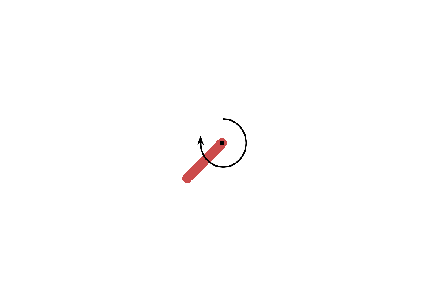
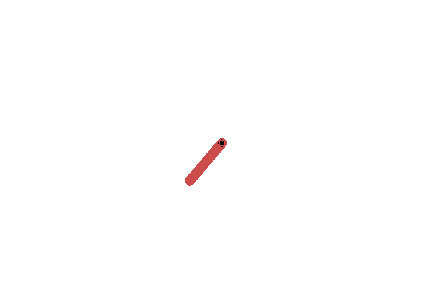
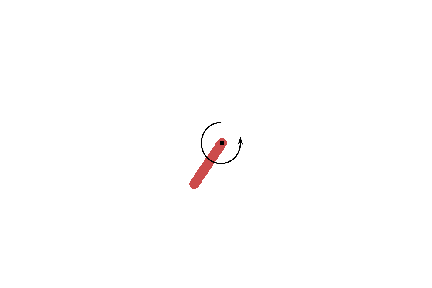
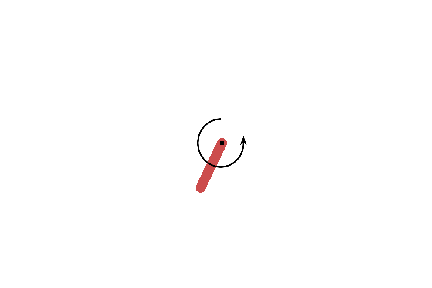
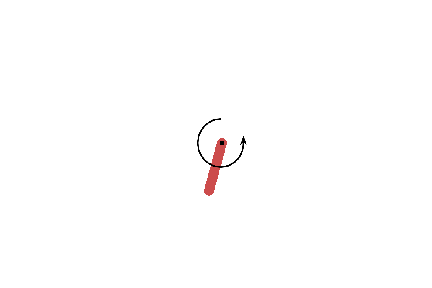
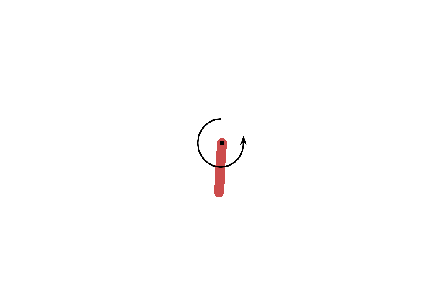
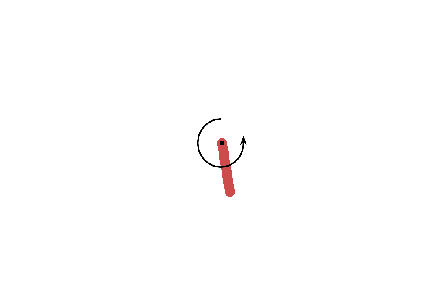
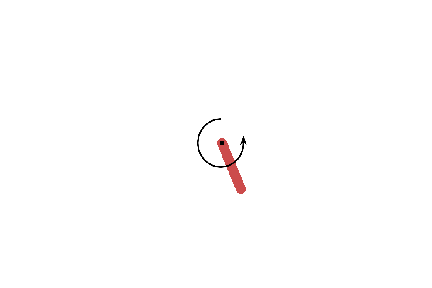
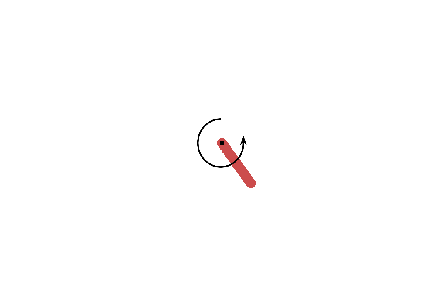
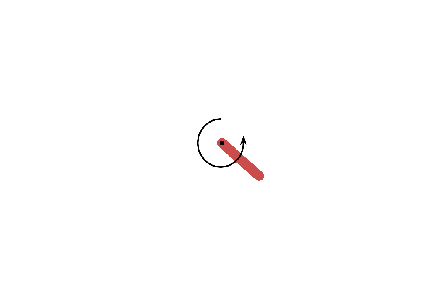
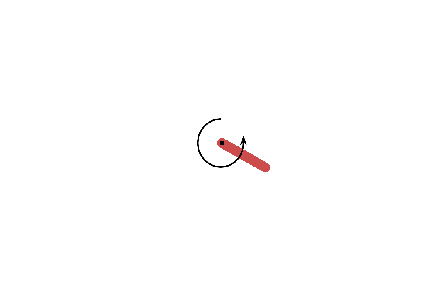
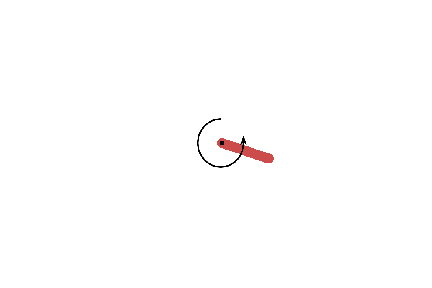
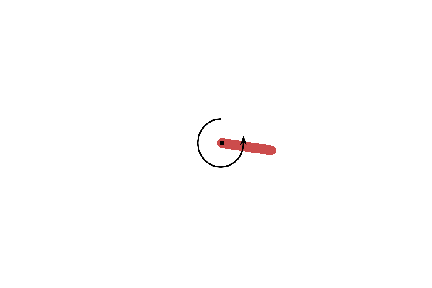
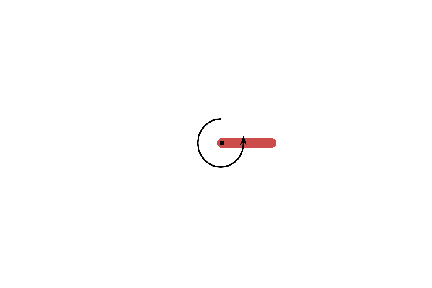
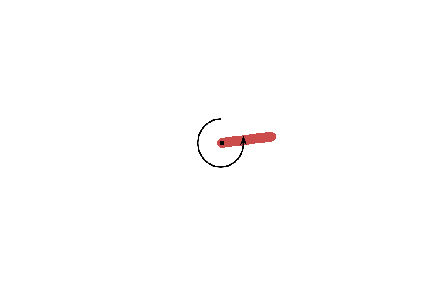
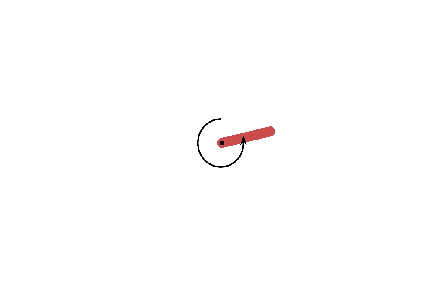
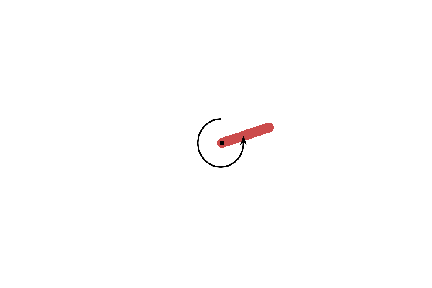
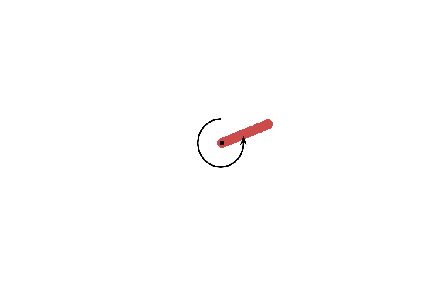
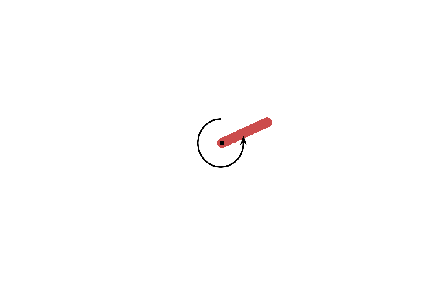
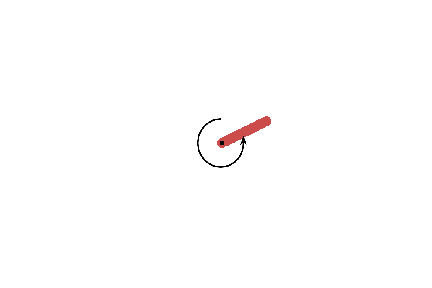
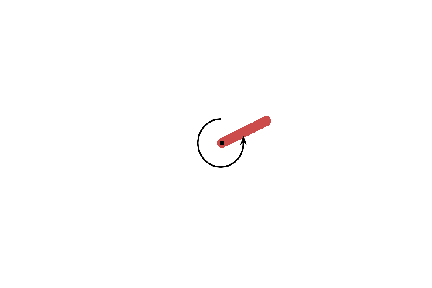
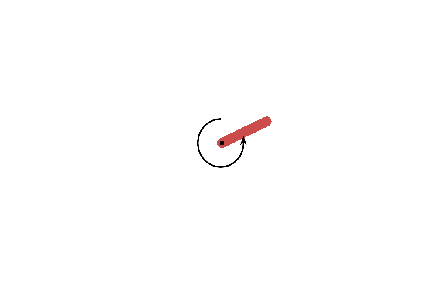
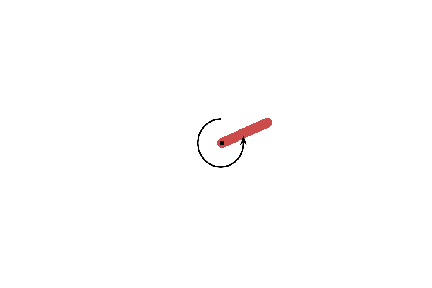
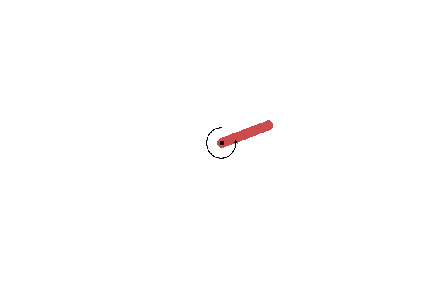
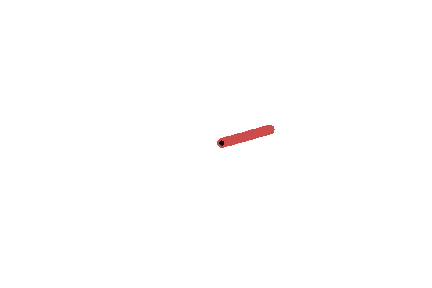
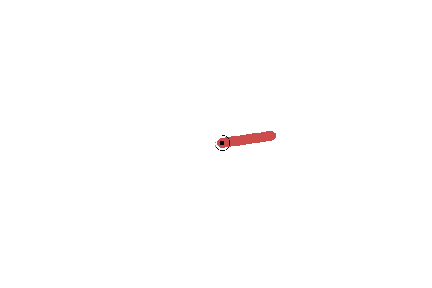
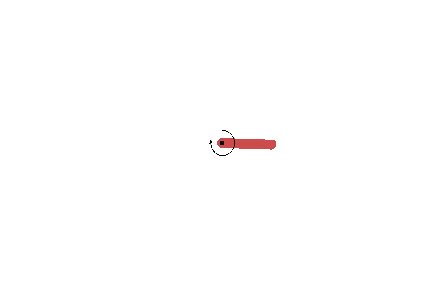
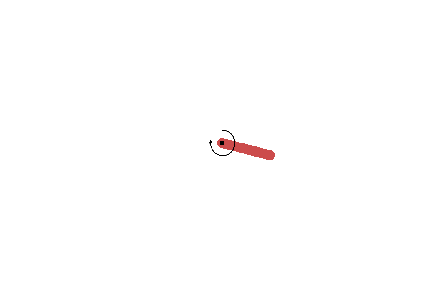
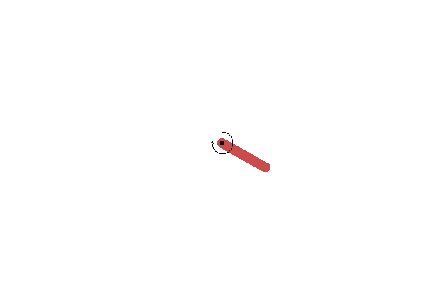
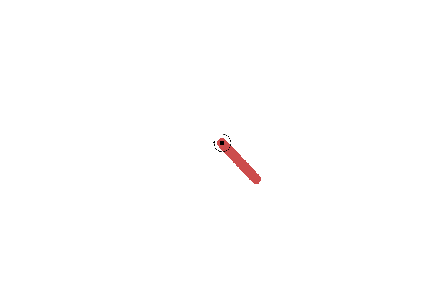
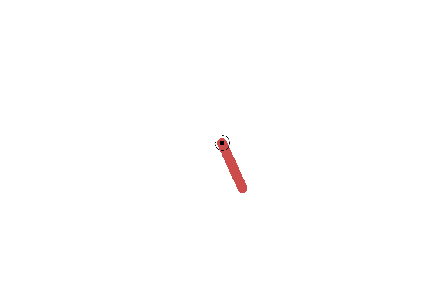
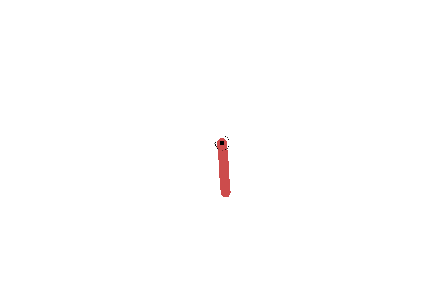
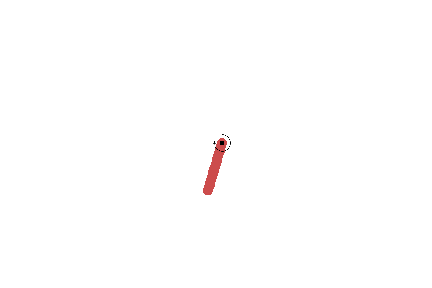
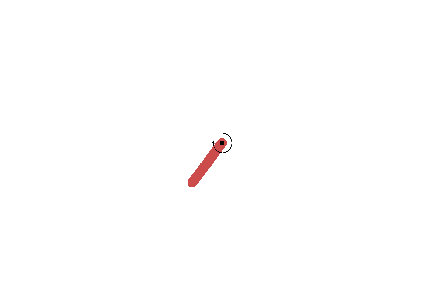
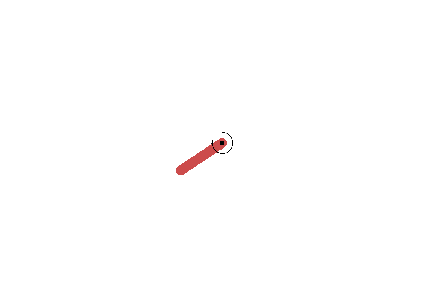
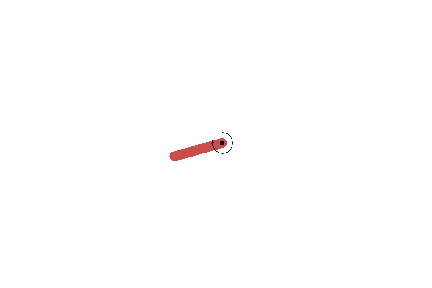
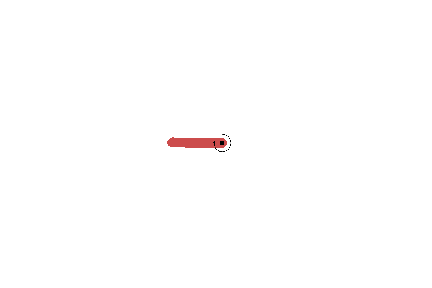
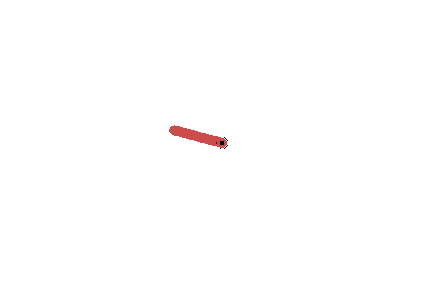
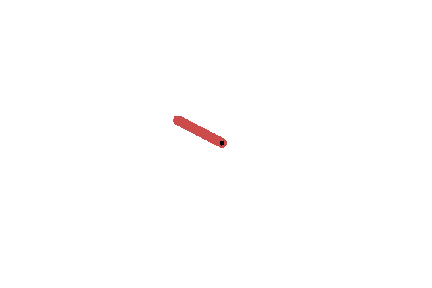
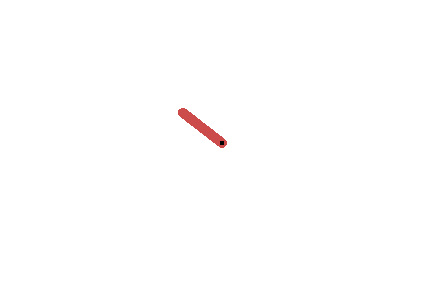
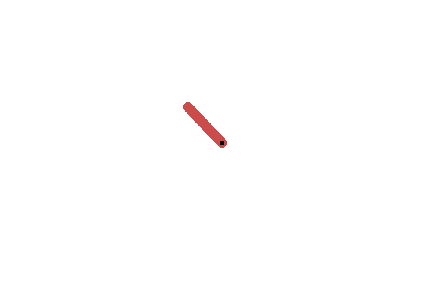
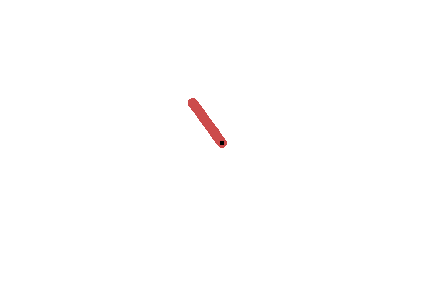
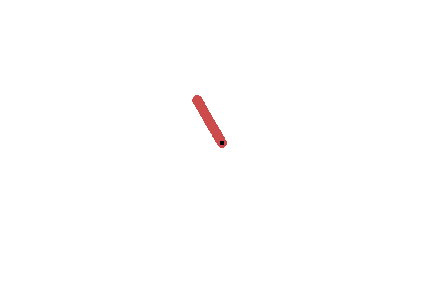
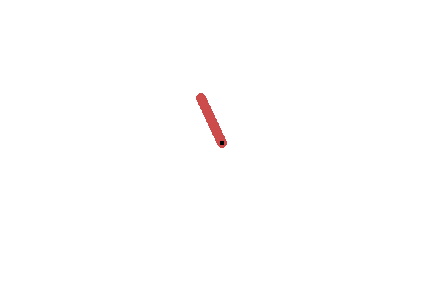
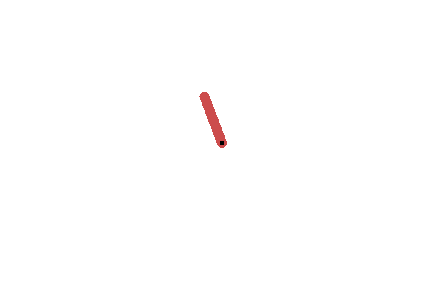
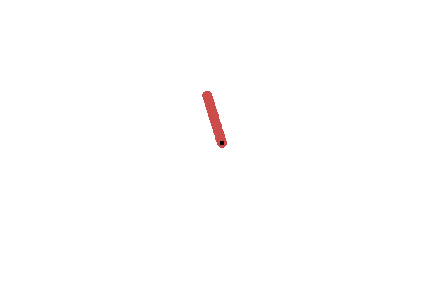
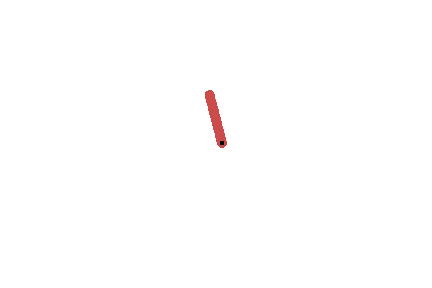
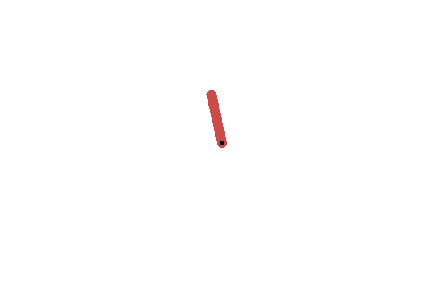
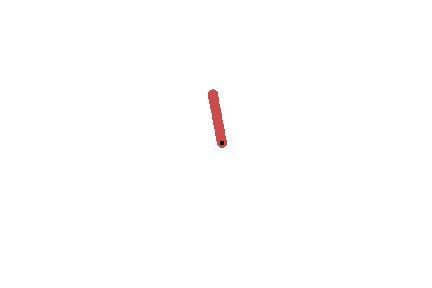
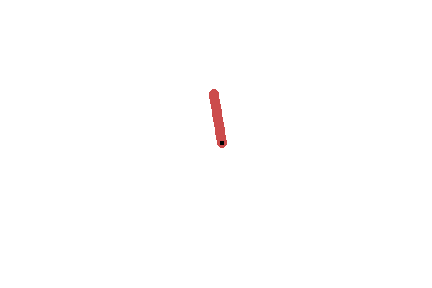
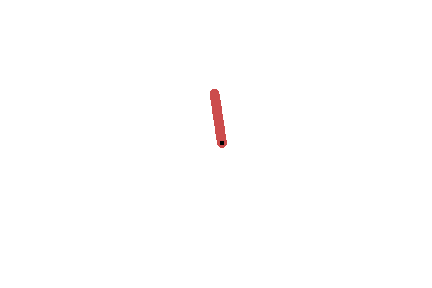
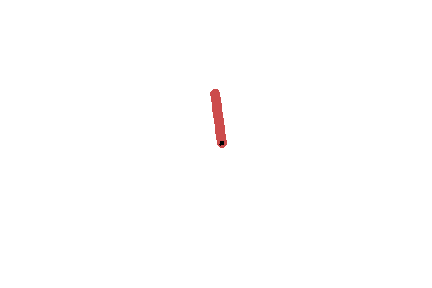
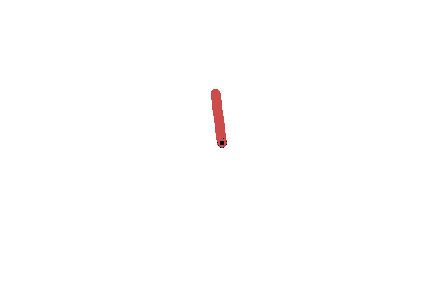
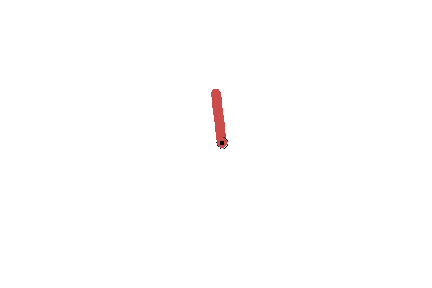
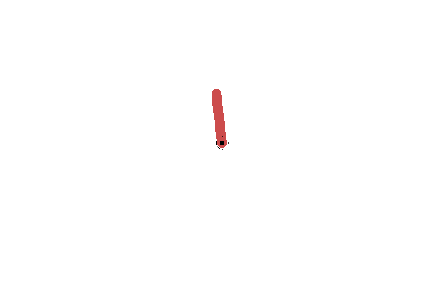
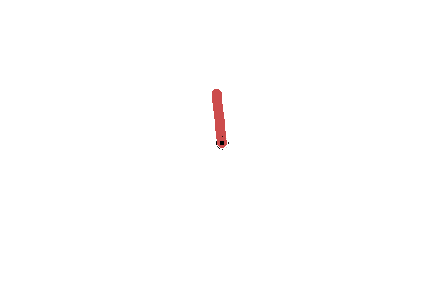
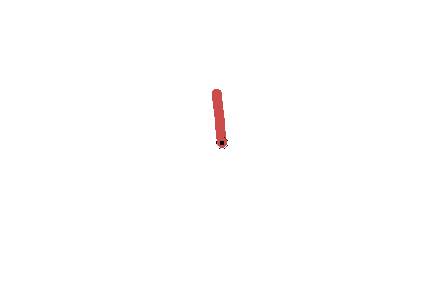
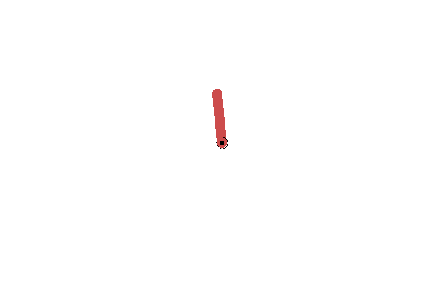
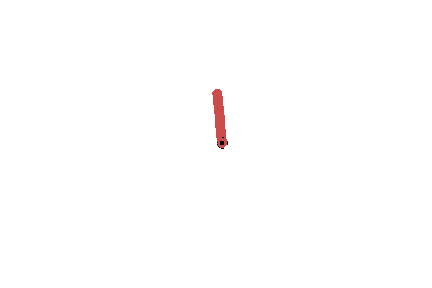
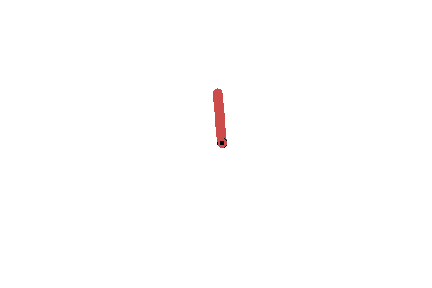
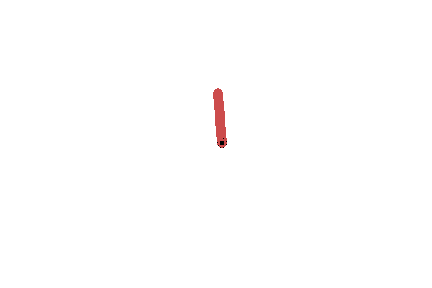
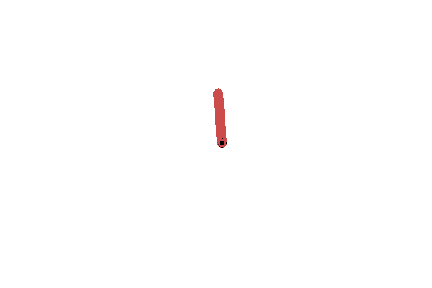
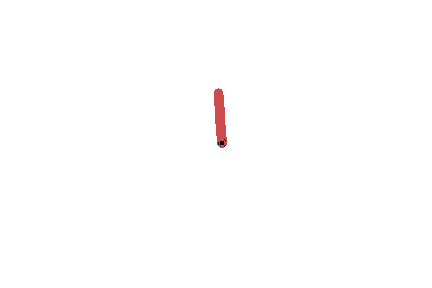
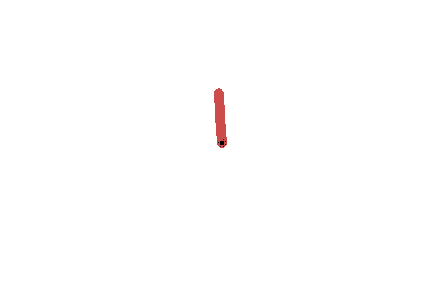
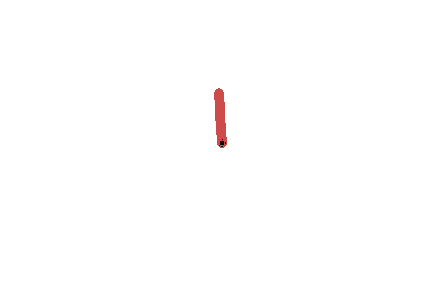
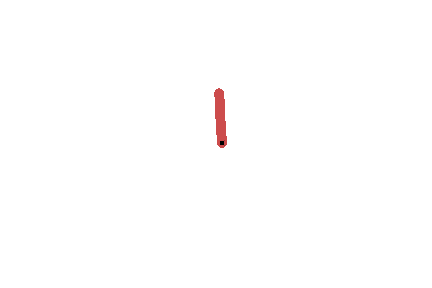
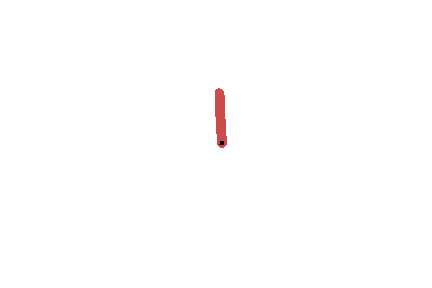
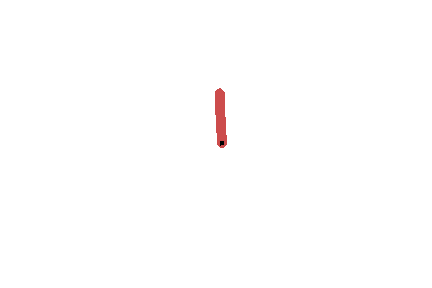
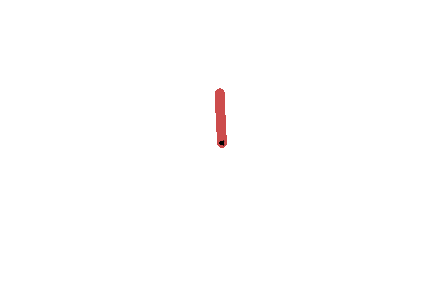
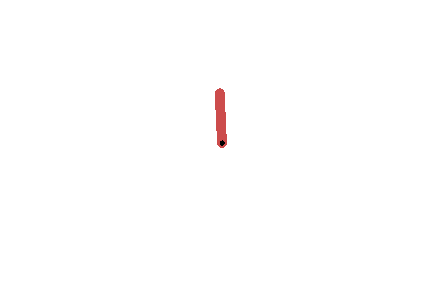
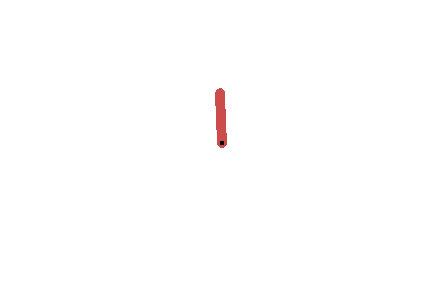
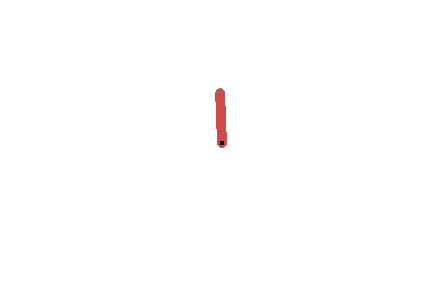
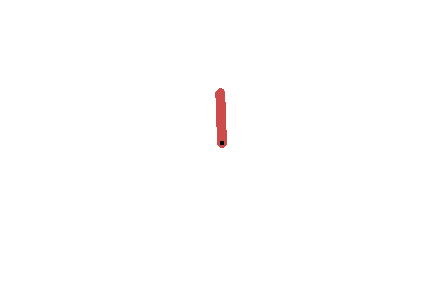
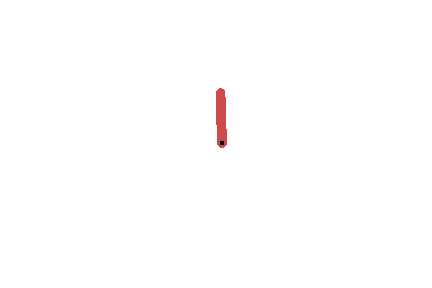
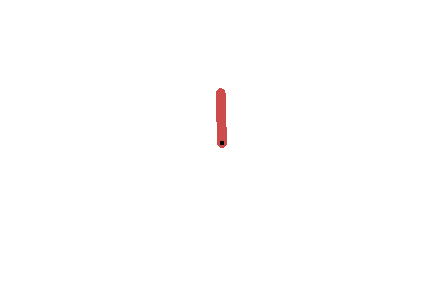
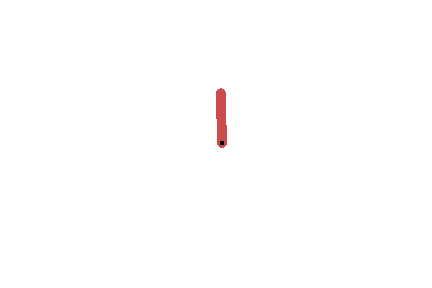
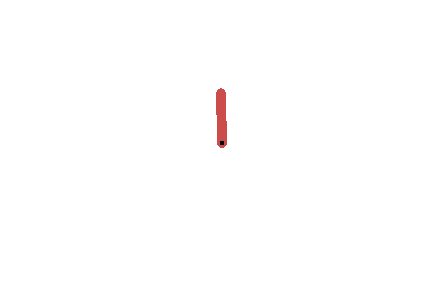
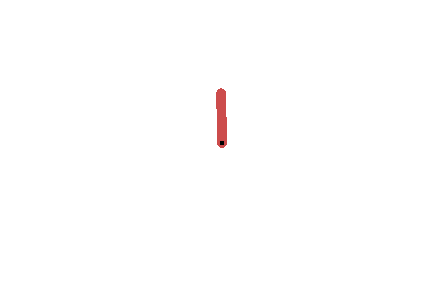
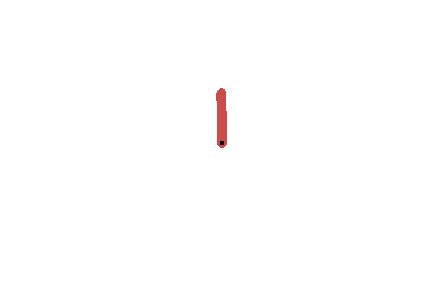
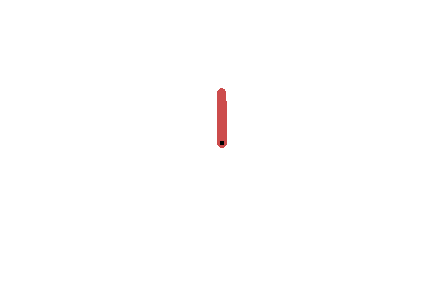
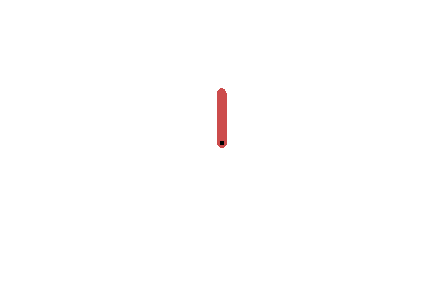
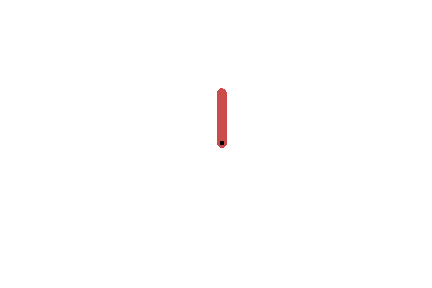
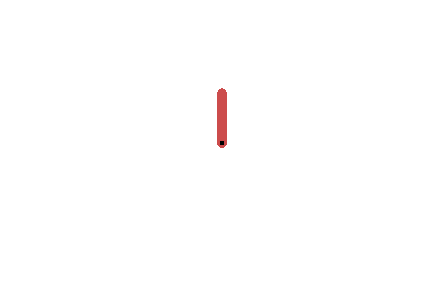
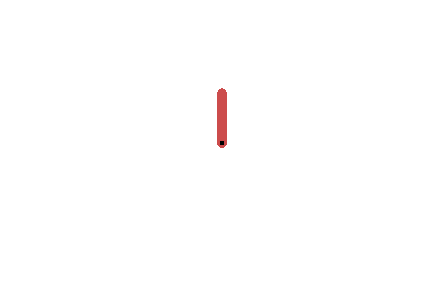
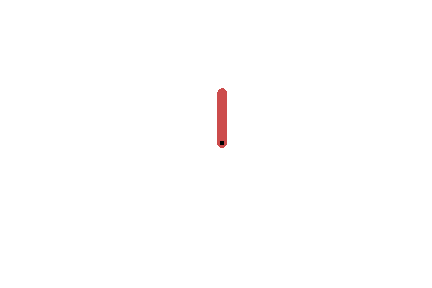
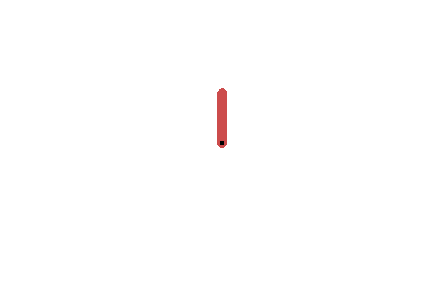
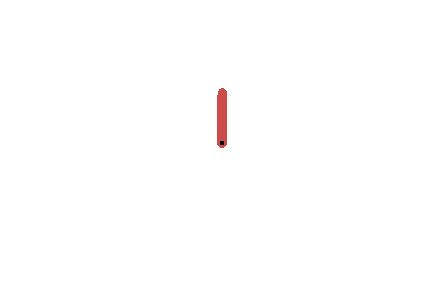
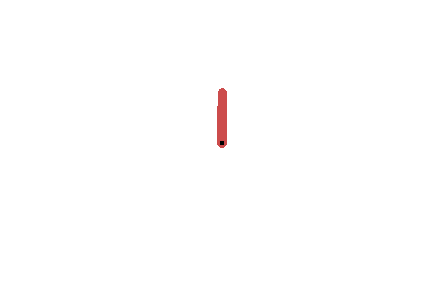
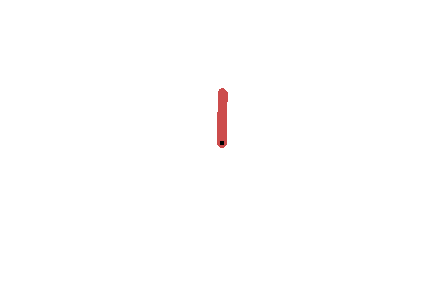
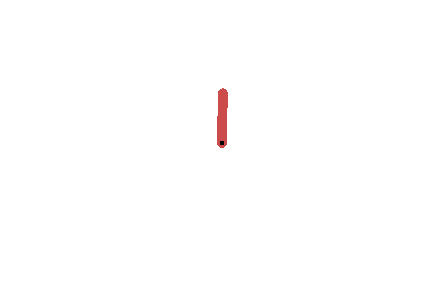
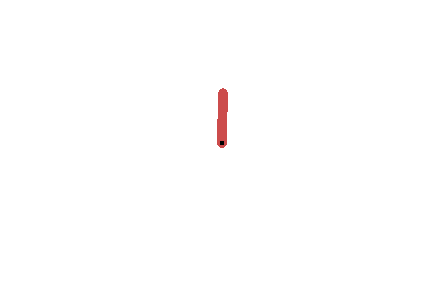
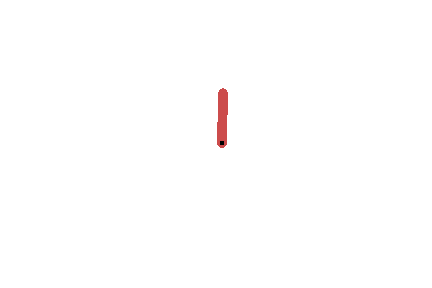
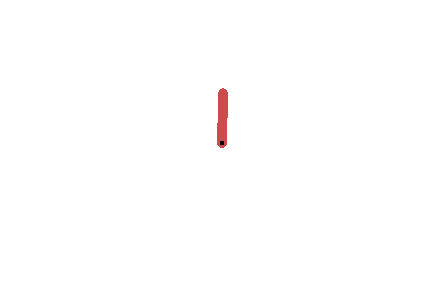
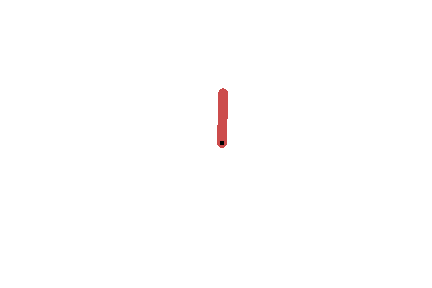
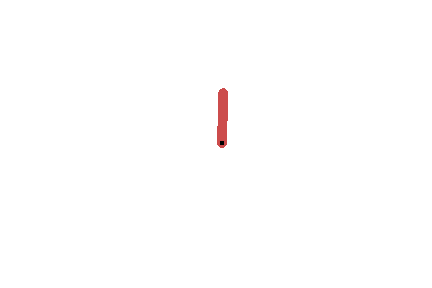
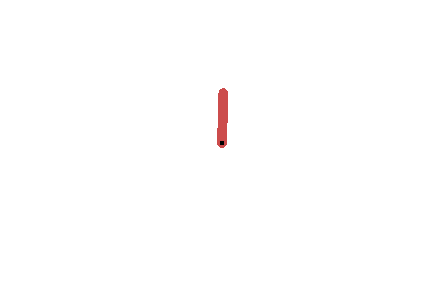
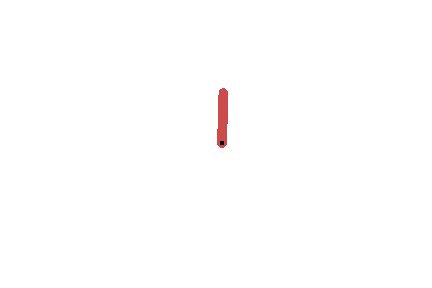
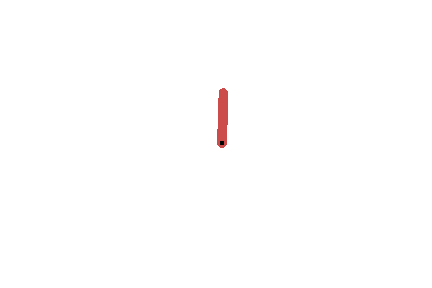
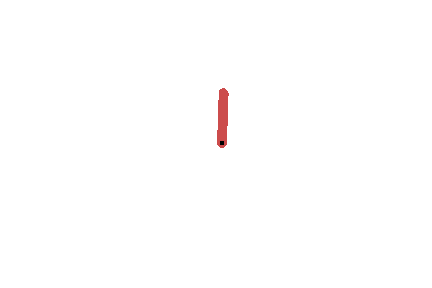
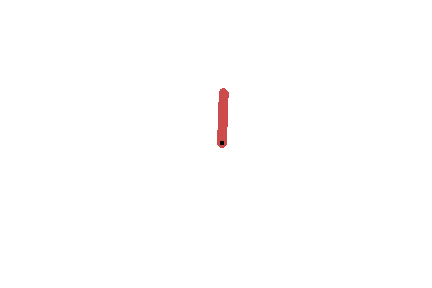
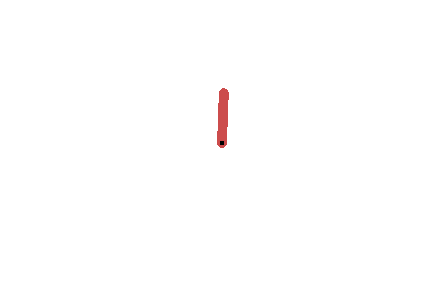
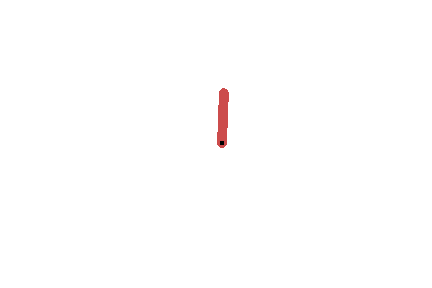
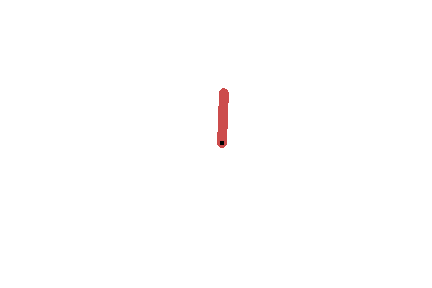
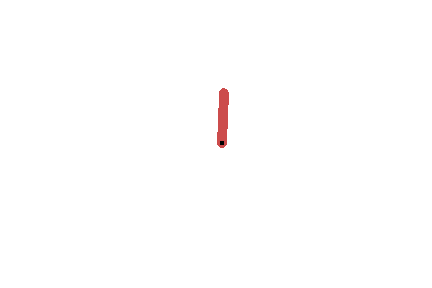
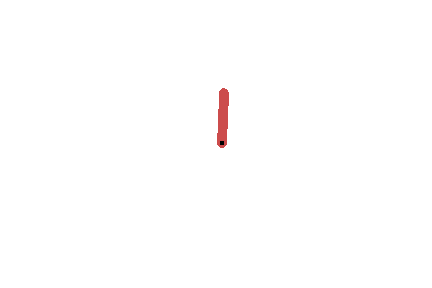
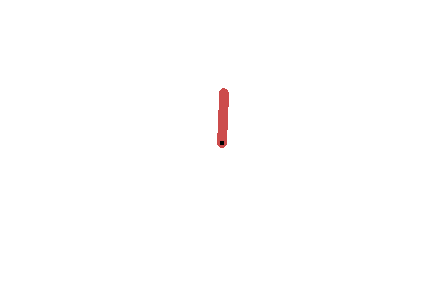
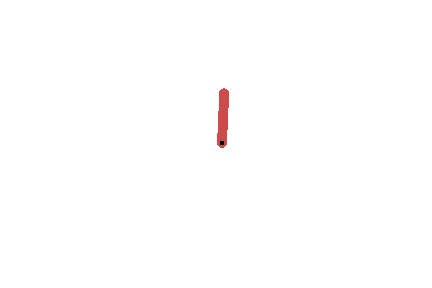
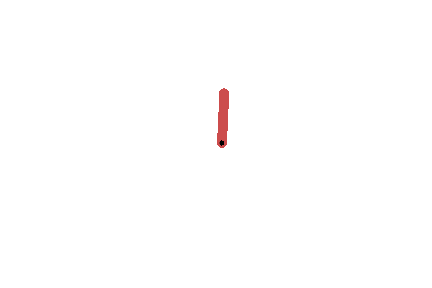
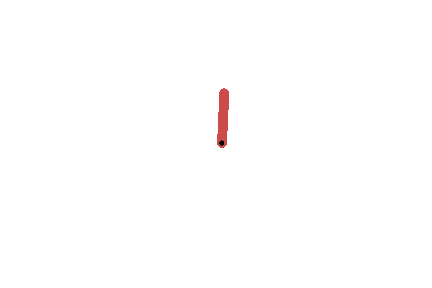
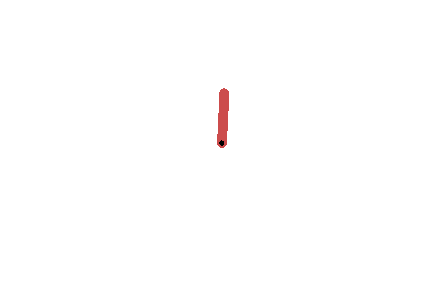
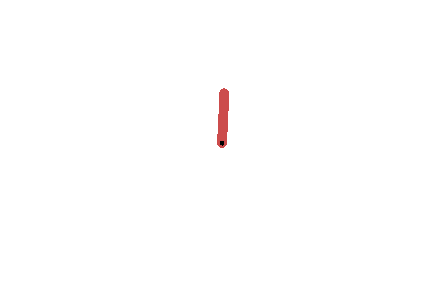
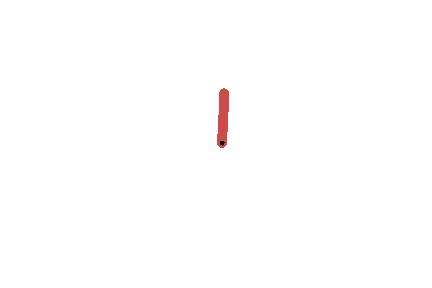
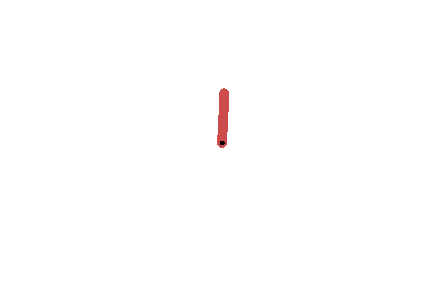
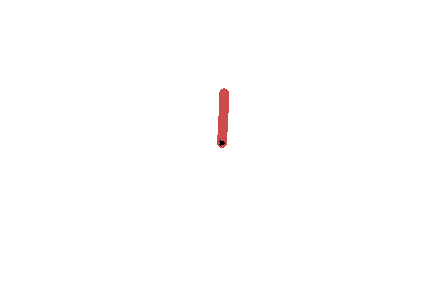
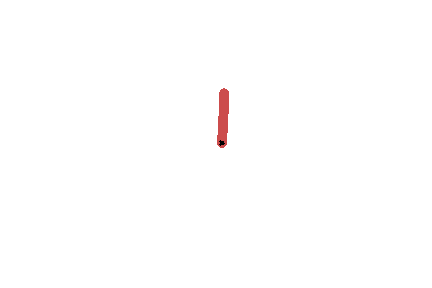
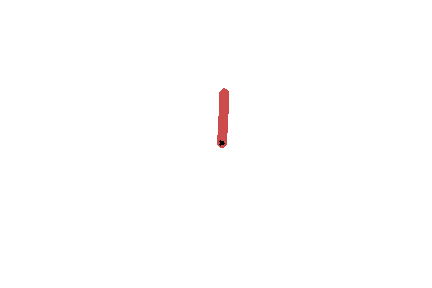
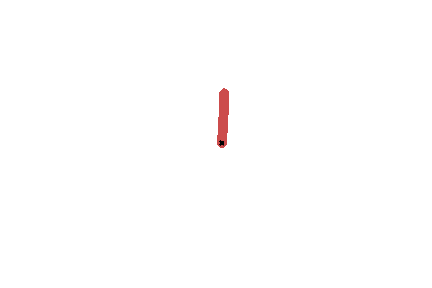
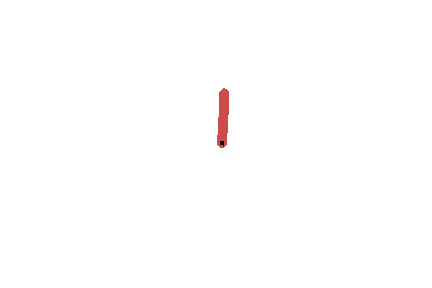
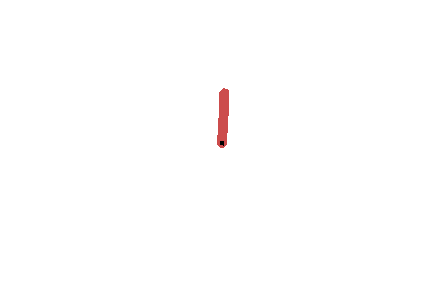
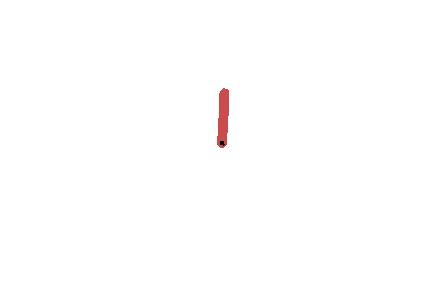
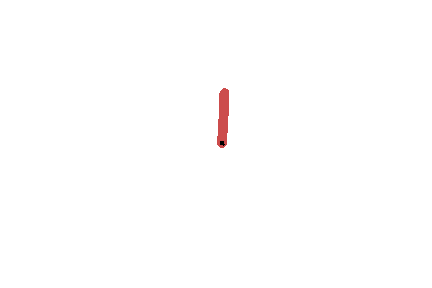
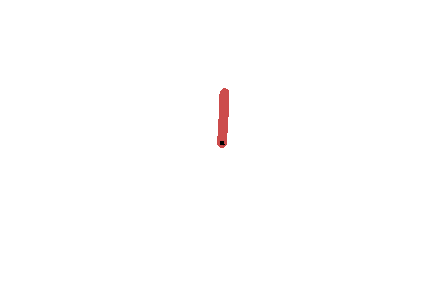
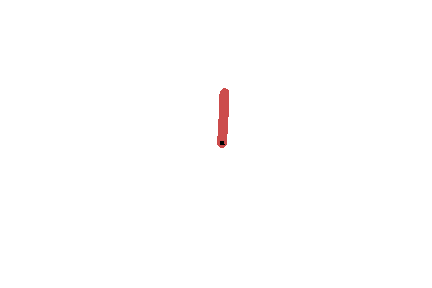
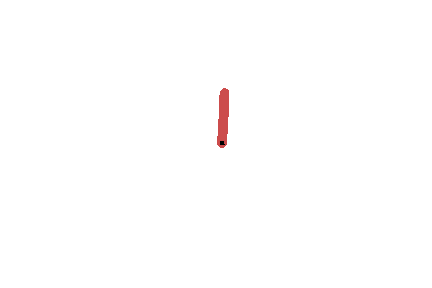
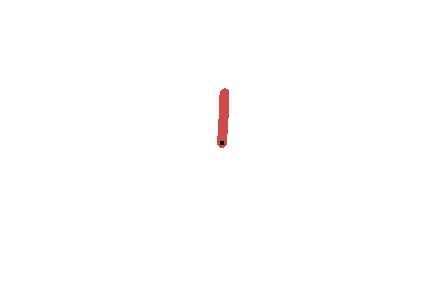
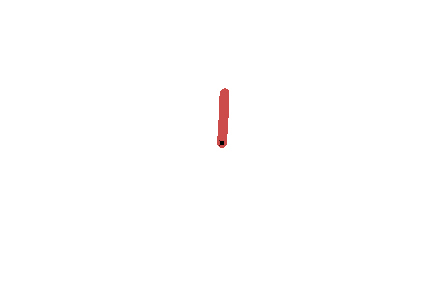
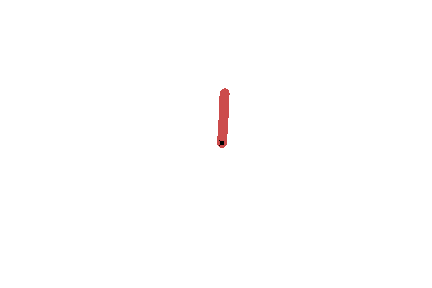
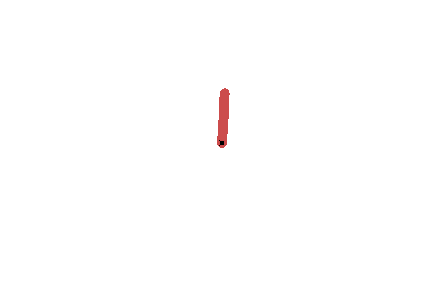
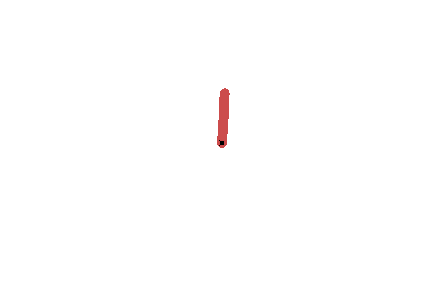
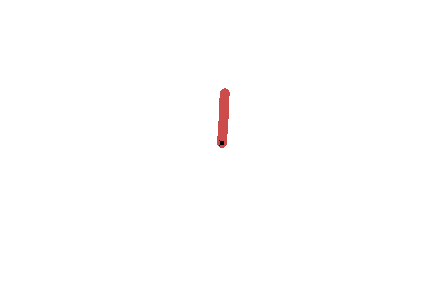
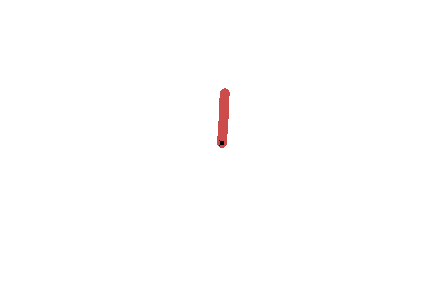
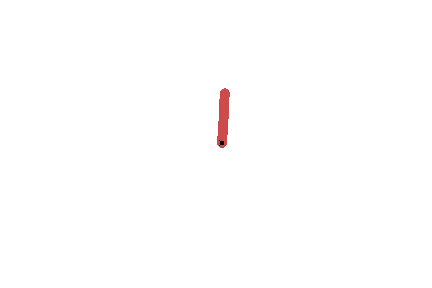
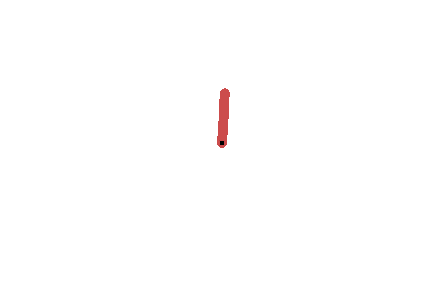
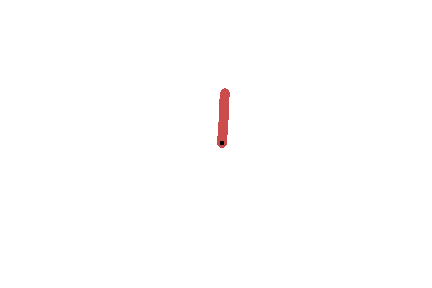
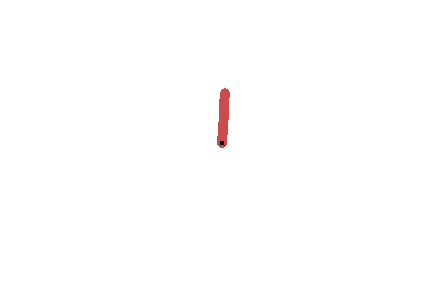
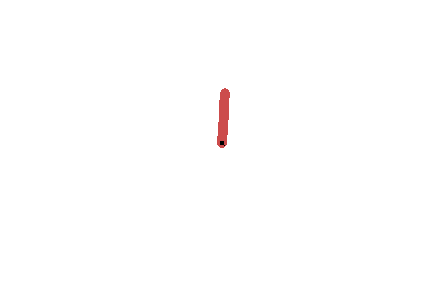
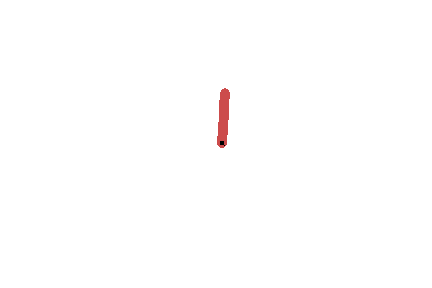
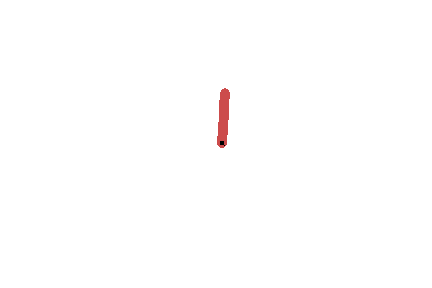
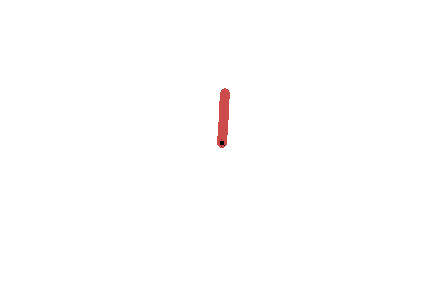
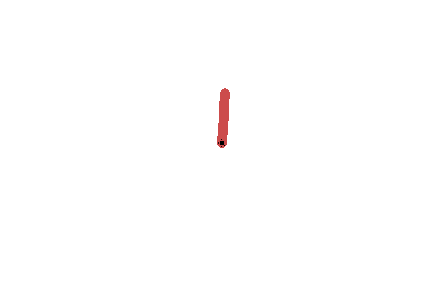
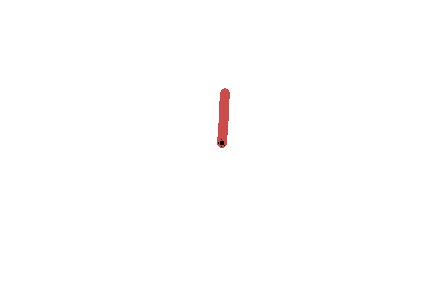
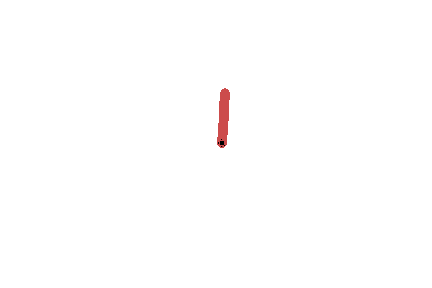
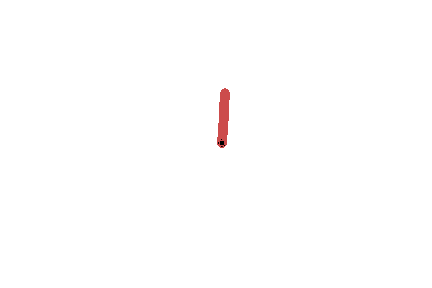
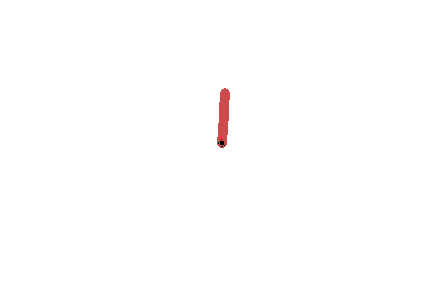
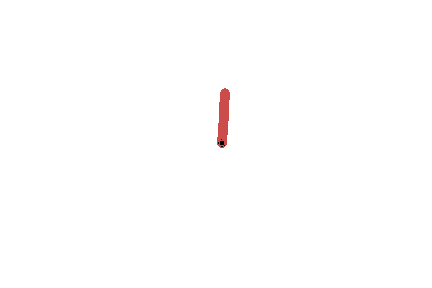
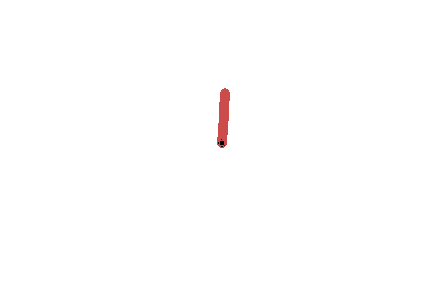
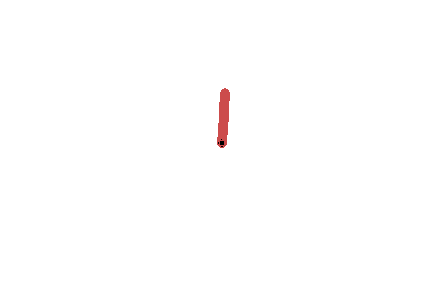
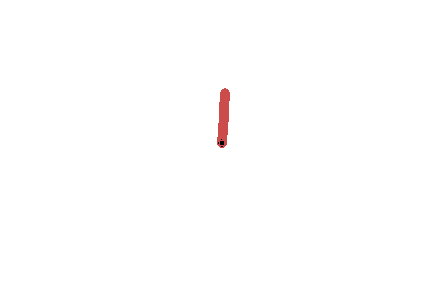
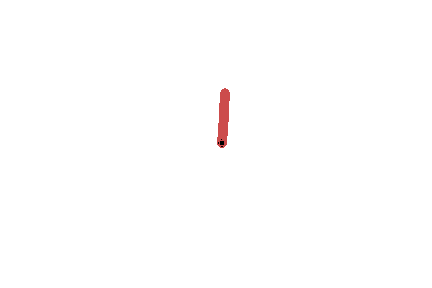
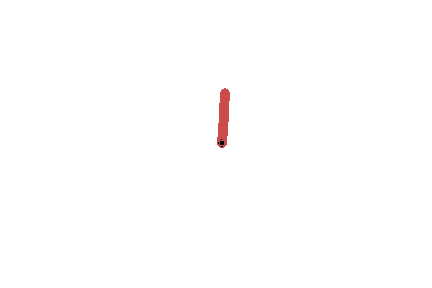
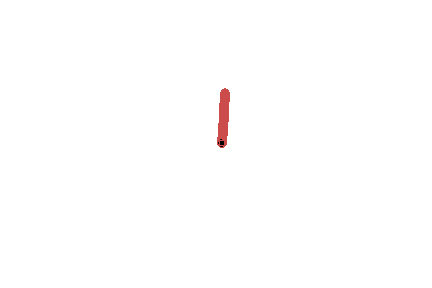
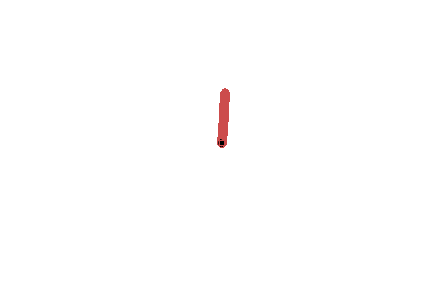
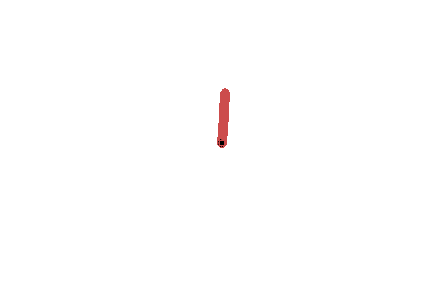
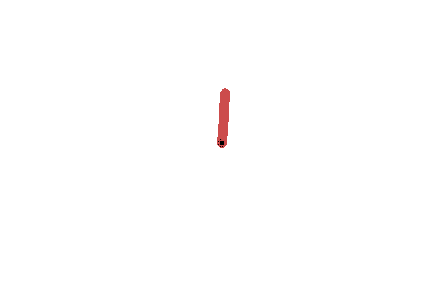
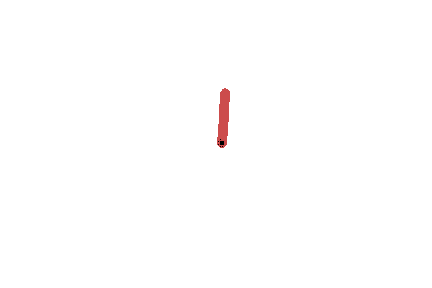
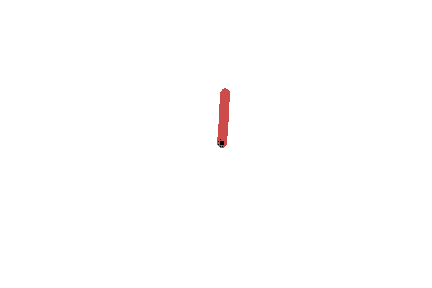
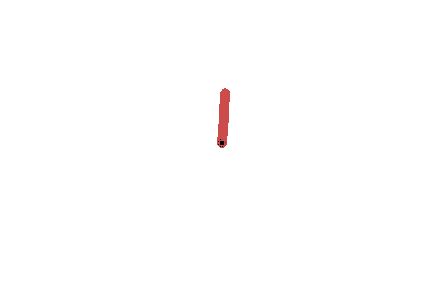
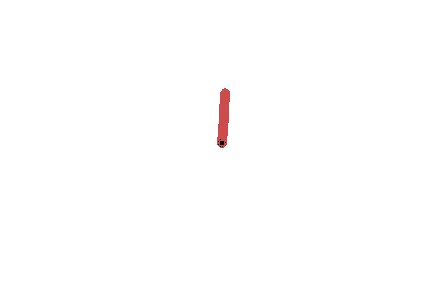
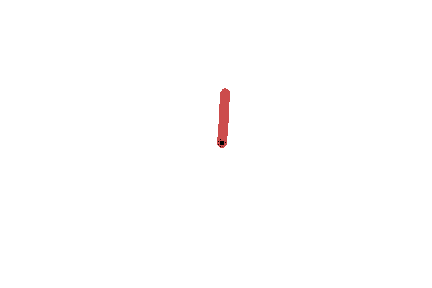
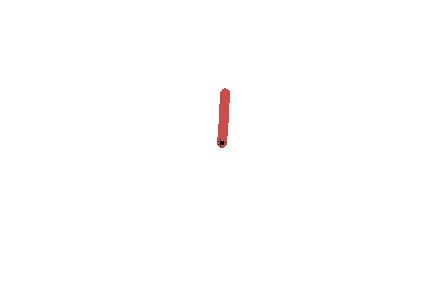
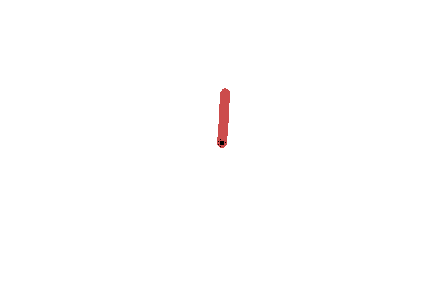
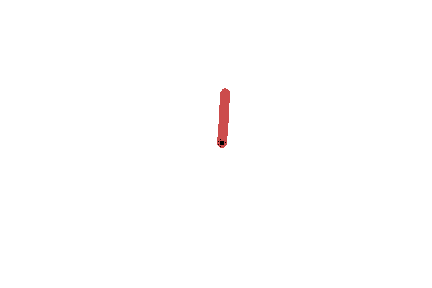
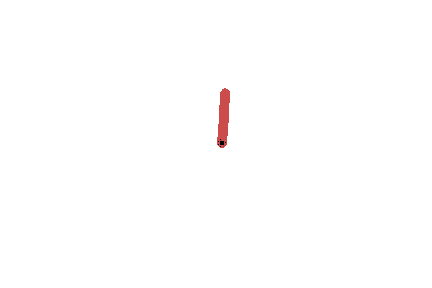
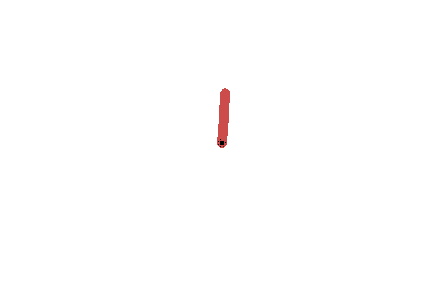
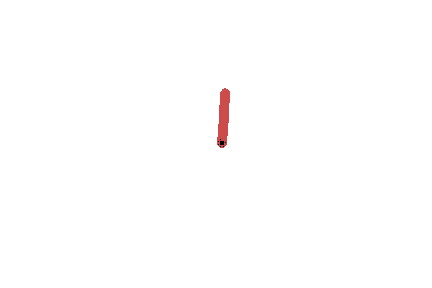
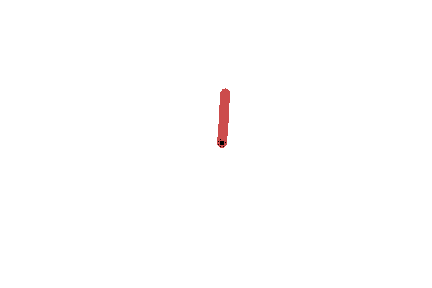
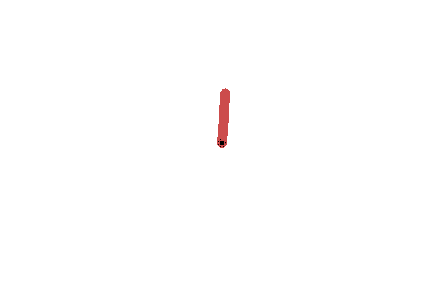
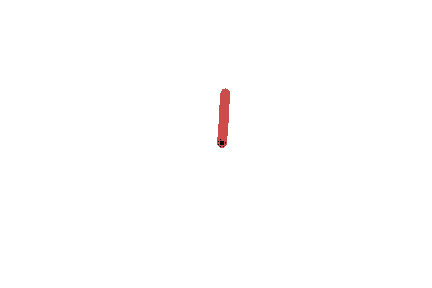
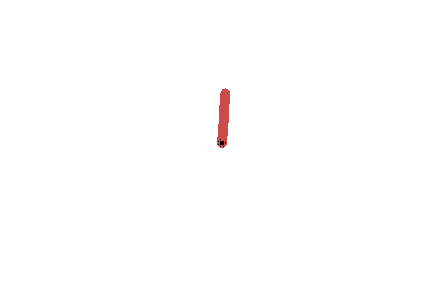
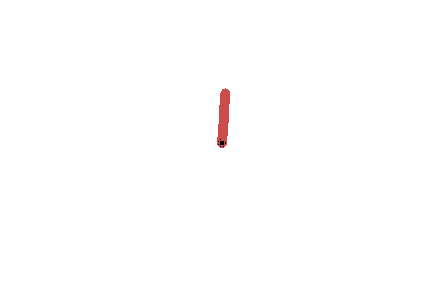
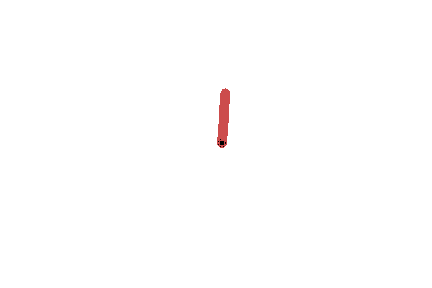
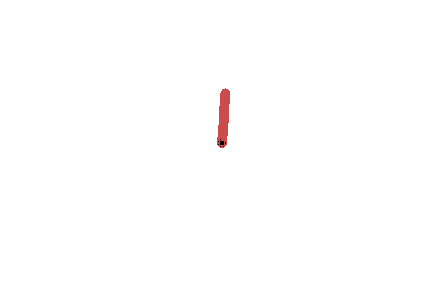
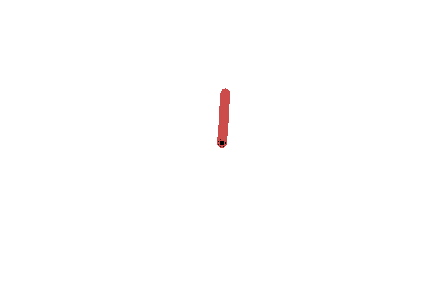
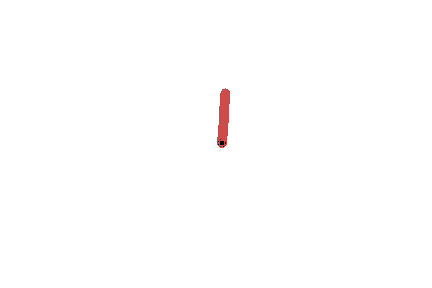
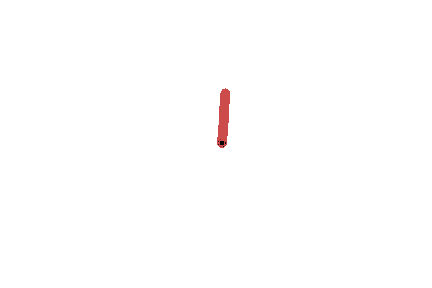
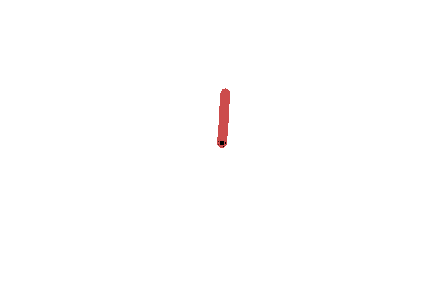
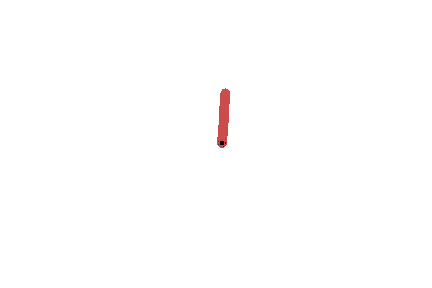
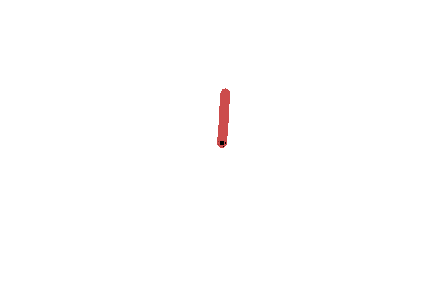
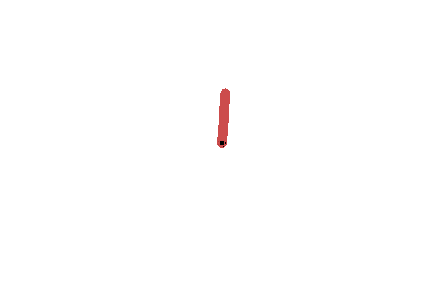
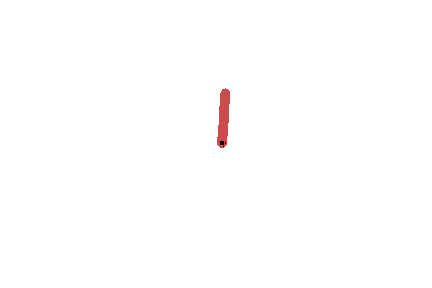
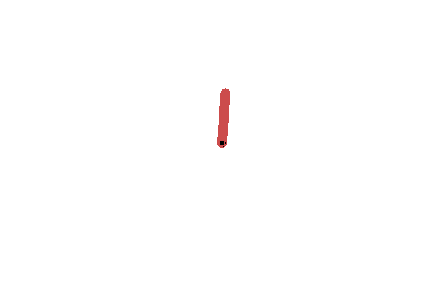
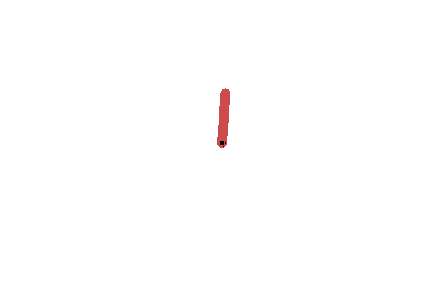
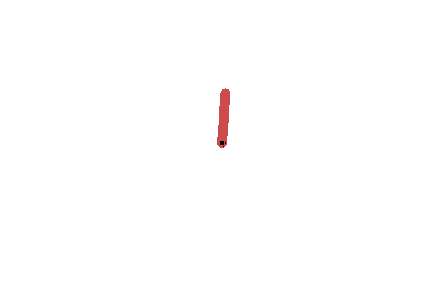
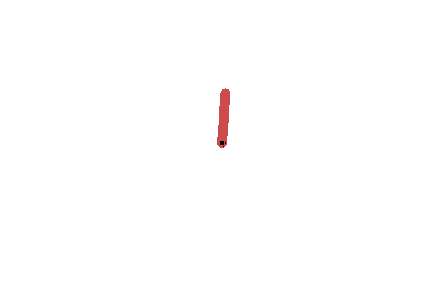
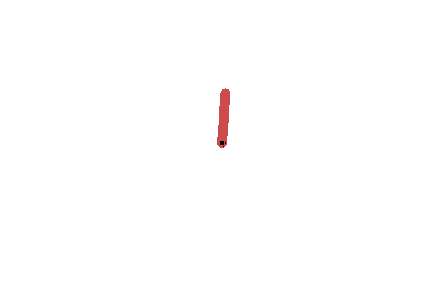
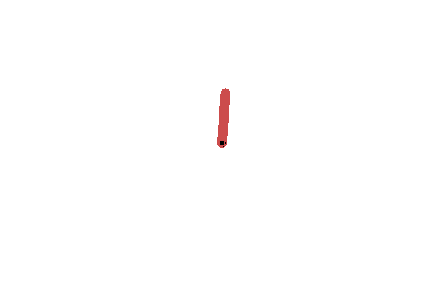
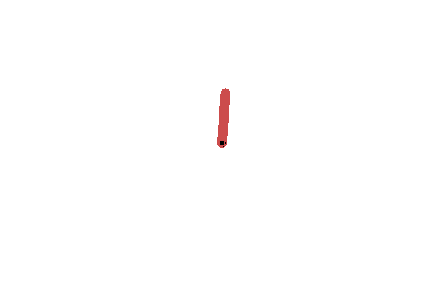
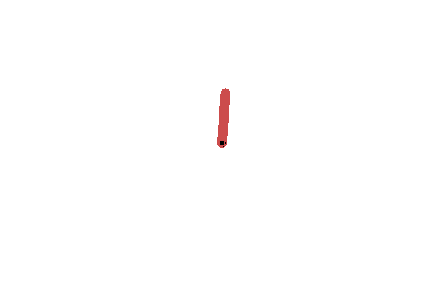
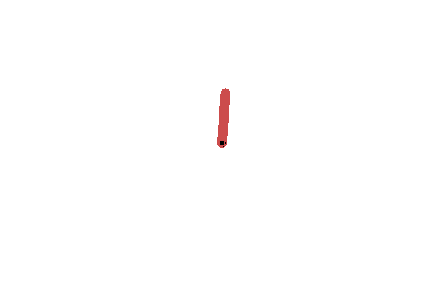
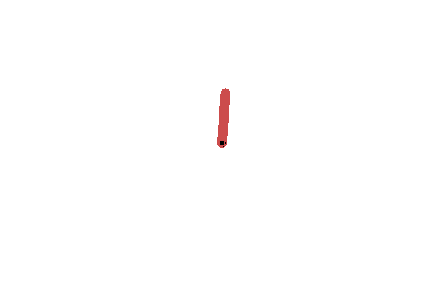
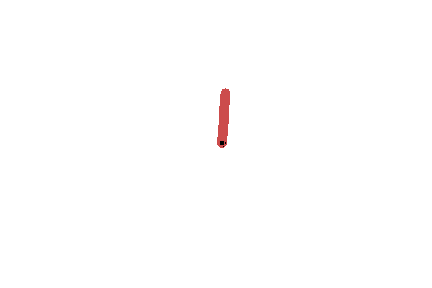
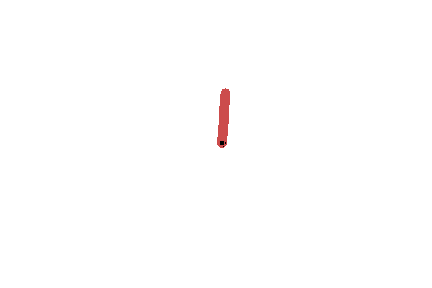
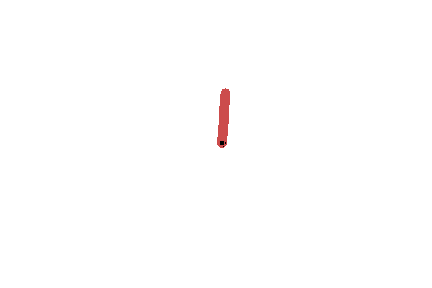
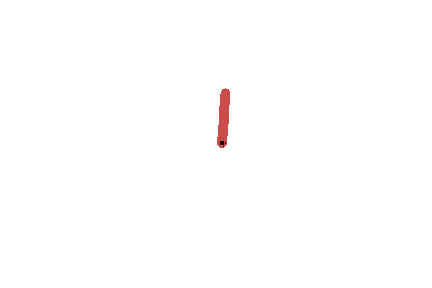
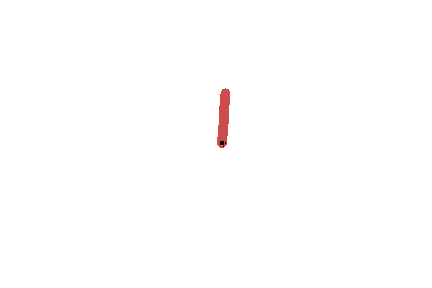
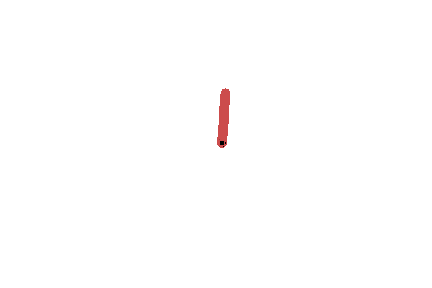
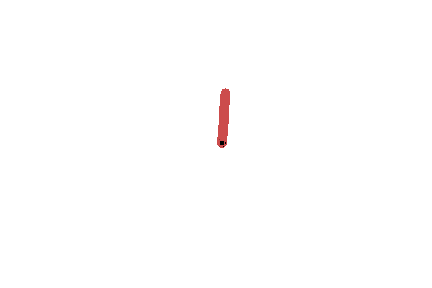
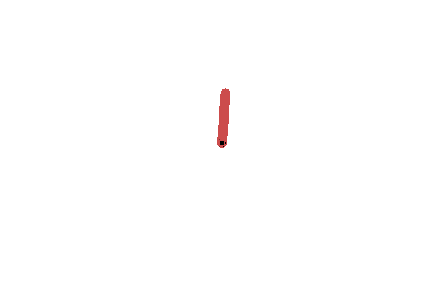
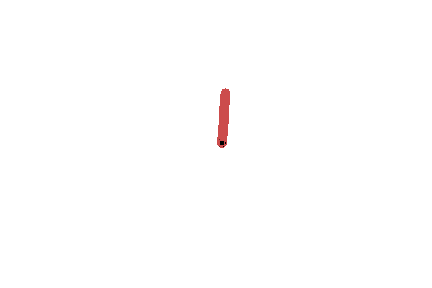
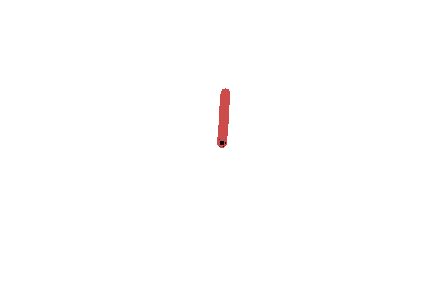

In [16]:
env = gym.make('Pendulum-v0')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = agent.control(obs).reshape((1, -1)).astype(np.float32)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)